## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


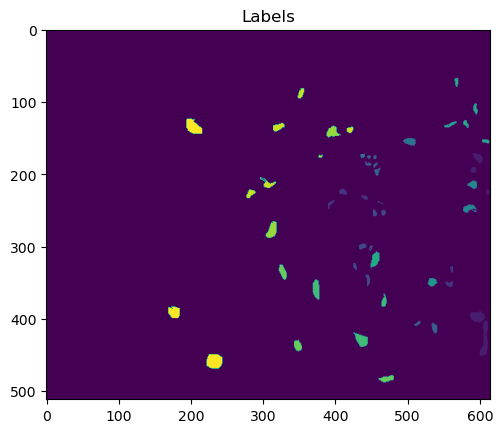

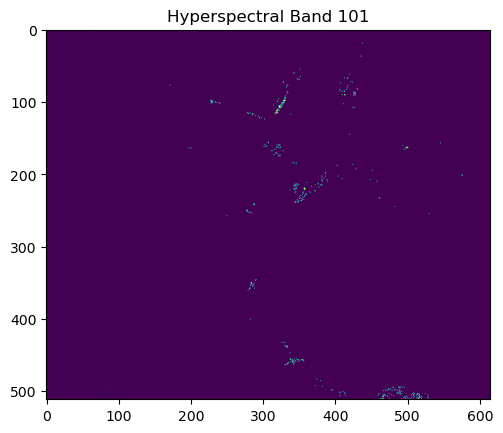

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(260, 5, 5, 176)
(65, 5, 5, 176)
(4886, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2488, PSNR: 6.0408


Epoch [1/50] Training Loss: 0.2356, PSNR: 6.2817
	[Val]   Batch [1/17] Loss: 0.2189, PSNR: 6.5983
	[Val]   Batch [10/17] Loss: 0.2196, PSNR: 6.5845
Epoch [1/50] Validation Loss: 0.2192, PSNR: 6.5918

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2130, PSNR: 6.7168


Epoch [2/50] Training Loss: 0.1971, PSNR: 7.0580
	[Val]   Batch [1/17] Loss: 0.1738, PSNR: 7.6004
	[Val]   Batch [10/17] Loss: 0.1770, PSNR: 7.5206
Epoch [2/50] Validation Loss: 0.1758, PSNR: 7.5499

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1750, PSNR: 7.5693


Epoch [3/50] Training Loss: 0.1615, PSNR: 7.9245
	[Val]   Batch [1/17] Loss: 0.1401, PSNR: 8.5367
	[Val]   Batch [10/17] Loss: 0.1436, PSNR: 8.4298
Epoch [3/50] Validation Loss: 0.1422, PSNR: 8.4717

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1421, PSNR: 8.4750


Epoch [4/50] Training Loss: 0.1301, PSNR: 8.8661
	[Val]   Batch [1/17] Loss: 0.1124, PSNR: 9.4927
	[Val]   Batch [10/17] Loss: 0.1147, PSNR: 9.4034
Epoch [4/50] Validation Loss: 0.1137, PSNR: 9.4429

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1130, PSNR: 9.4704


Epoch [5/50] Training Loss: 0.1038, PSNR: 9.1773
	[Val]   Batch [1/17] Loss: 0.0898, PSNR: 10.4680
	[Val]   Batch [10/17] Loss: 0.0921, PSNR: 10.3566
Epoch [5/50] Validation Loss: 0.0910, PSNR: 10.4078

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0904, PSNR: 10.4387


Epoch [6/50] Training Loss: 0.0830, PSNR: 10.8180
	[Val]   Batch [1/17] Loss: 0.0723, PSNR: 11.4073
	[Val]   Batch [10/17] Loss: 0.0734, PSNR: 11.3425
Epoch [6/50] Validation Loss: 0.0728, PSNR: 11.3797

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0724, PSNR: 11.4053


Epoch [7/50] Training Loss: 0.0671, PSNR: 11.7393
	[Val]   Batch [1/17] Loss: 0.0603, PSNR: 12.2001
	[Val]   Batch [10/17] Loss: 0.0615, PSNR: 12.1080
Epoch [7/50] Validation Loss: 0.0609, PSNR: 12.1554

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0593, PSNR: 12.2721


Epoch [8/50] Training Loss: 0.0551, PSNR: 12.5956
	[Val]   Batch [1/17] Loss: 0.0507, PSNR: 12.9482
	[Val]   Batch [10/17] Loss: 0.0515, PSNR: 12.8783
Epoch [8/50] Validation Loss: 0.0510, PSNR: 12.9201

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0493, PSNR: 13.0711


Epoch [9/50] Training Loss: 0.0460, PSNR: 13.3775
	[Val]   Batch [1/17] Loss: 0.0419, PSNR: 13.7755
	[Val]   Batch [10/17] Loss: 0.0423, PSNR: 13.7333
Epoch [9/50] Validation Loss: 0.0420, PSNR: 13.7642

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0417, PSNR: 13.7990


Epoch [10/50] Training Loss: 0.0391, PSNR: 14.0867
	[Val]   Batch [1/17] Loss: 0.0363, PSNR: 14.3986
	[Val]   Batch [10/17] Loss: 0.0369, PSNR: 14.3289
Epoch [10/50] Validation Loss: 0.0366, PSNR: 14.3660

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0356, PSNR: 14.4821


Epoch [11/50] Training Loss: 0.0336, PSNR: 14.7440
	[Val]   Batch [1/17] Loss: 0.0315, PSNR: 15.0157
	[Val]   Batch [10/17] Loss: 0.0318, PSNR: 14.9776
Epoch [11/50] Validation Loss: 0.0316, PSNR: 15.0016

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0307, PSNR: 15.1239


Epoch [12/50] Training Loss: 0.0293, PSNR: 15.3338
	[Val]   Batch [1/17] Loss: 0.0279, PSNR: 15.5383
	[Val]   Batch [10/17] Loss: 0.0283, PSNR: 15.4849
Epoch [12/50] Validation Loss: 0.0281, PSNR: 15.5167

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0273, PSNR: 15.6334


Epoch [13/50] Training Loss: 0.0258, PSNR: 15.8859
	[Val]   Batch [1/17] Loss: 0.0245, PSNR: 16.1065
	[Val]   Batch [10/17] Loss: 0.0247, PSNR: 16.0708
Epoch [13/50] Validation Loss: 0.0246, PSNR: 16.0962

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0240, PSNR: 16.1932


Epoch [14/50] Training Loss: 0.0229, PSNR: 16.3951
	[Val]   Batch [1/17] Loss: 0.0221, PSNR: 16.5632
	[Val]   Batch [10/17] Loss: 0.0224, PSNR: 16.4988
Epoch [14/50] Validation Loss: 0.0222, PSNR: 16.5322

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0214, PSNR: 16.7011


Epoch [15/50] Training Loss: 0.0206, PSNR: 16.2018
	[Val]   Batch [1/17] Loss: 0.0199, PSNR: 17.0183
	[Val]   Batch [10/17] Loss: 0.0201, PSNR: 16.9621
Epoch [15/50] Validation Loss: 0.0200, PSNR: 16.9912

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0191, PSNR: 17.1859


Epoch [16/50] Training Loss: 0.0186, PSNR: 16.6230
	[Val]   Batch [1/17] Loss: 0.0182, PSNR: 17.3978
	[Val]   Batch [10/17] Loss: 0.0185, PSNR: 17.3378
Epoch [16/50] Validation Loss: 0.0183, PSNR: 17.3697

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0174, PSNR: 17.5946


Epoch [17/50] Training Loss: 0.0168, PSNR: 17.7384
	[Val]   Batch [1/17] Loss: 0.0163, PSNR: 17.8777
	[Val]   Batch [10/17] Loss: 0.0165, PSNR: 17.8308
Epoch [17/50] Validation Loss: 0.0164, PSNR: 17.8582

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0160, PSNR: 17.9682


Epoch [18/50] Training Loss: 0.0154, PSNR: 18.1260
	[Val]   Batch [1/17] Loss: 0.0150, PSNR: 18.2282
	[Val]   Batch [10/17] Loss: 0.0153, PSNR: 18.1644
Epoch [18/50] Validation Loss: 0.0151, PSNR: 18.1990

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0145, PSNR: 18.3863


Epoch [19/50] Training Loss: 0.0142, PSNR: 17.7993
	[Val]   Batch [1/17] Loss: 0.0138, PSNR: 18.6121
	[Val]   Batch [10/17] Loss: 0.0140, PSNR: 18.5519
Epoch [19/50] Validation Loss: 0.0139, PSNR: 18.5832

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0134, PSNR: 18.7303


Epoch [20/50] Training Loss: 0.0130, PSNR: 18.8542
	[Val]   Batch [1/17] Loss: 0.0127, PSNR: 18.9618
	[Val]   Batch [10/17] Loss: 0.0129, PSNR: 18.8924
Epoch [20/50] Validation Loss: 0.0128, PSNR: 18.9316

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0126, PSNR: 18.9976


Epoch [21/50] Training Loss: 0.0120, PSNR: 19.1951
	[Val]   Batch [1/17] Loss: 0.0118, PSNR: 19.2674
	[Val]   Batch [10/17] Loss: 0.0120, PSNR: 19.2011
Epoch [21/50] Validation Loss: 0.0119, PSNR: 19.2380

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0116, PSNR: 19.3644


Epoch [22/50] Training Loss: 0.0112, PSNR: 18.8295
	[Val]   Batch [1/17] Loss: 0.0111, PSNR: 19.5525
	[Val]   Batch [10/17] Loss: 0.0113, PSNR: 19.4830
Epoch [22/50] Validation Loss: 0.0112, PSNR: 19.5172

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0106, PSNR: 19.7515


Epoch [23/50] Training Loss: 0.0104, PSNR: 19.8198
	[Val]   Batch [1/17] Loss: 0.0104, PSNR: 19.8447
	[Val]   Batch [10/17] Loss: 0.0106, PSNR: 19.7668
Epoch [23/50] Validation Loss: 0.0105, PSNR: 19.8041

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0100, PSNR: 19.9875


Epoch [24/50] Training Loss: 0.0097, PSNR: 20.1353
	[Val]   Batch [1/17] Loss: 0.0095, PSNR: 20.2046
	[Val]   Batch [10/17] Loss: 0.0097, PSNR: 20.1298
Epoch [24/50] Validation Loss: 0.0096, PSNR: 20.1677

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0094, PSNR: 20.2818


Epoch [25/50] Training Loss: 0.0091, PSNR: 20.4314
	[Val]   Batch [1/17] Loss: 0.0090, PSNR: 20.4546
	[Val]   Batch [10/17] Loss: 0.0092, PSNR: 20.3762
Epoch [25/50] Validation Loss: 0.0091, PSNR: 20.4157

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0087, PSNR: 20.6148


Epoch [26/50] Training Loss: 0.0085, PSNR: 20.6985
	[Val]   Batch [1/17] Loss: 0.0084, PSNR: 20.7546
	[Val]   Batch [10/17] Loss: 0.0086, PSNR: 20.6707
Epoch [26/50] Validation Loss: 0.0085, PSNR: 20.7122

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0083, PSNR: 20.8009


Epoch [27/50] Training Loss: 0.0080, PSNR: 20.2987
	[Val]   Batch [1/17] Loss: 0.0080, PSNR: 20.9682
	[Val]   Batch [10/17] Loss: 0.0082, PSNR: 20.8770
Epoch [27/50] Validation Loss: 0.0081, PSNR: 20.9166

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0078, PSNR: 21.0892


Epoch [28/50] Training Loss: 0.0075, PSNR: 21.2457
	[Val]   Batch [1/17] Loss: 0.0075, PSNR: 21.2723
	[Val]   Batch [10/17] Loss: 0.0076, PSNR: 21.1847
Epoch [28/50] Validation Loss: 0.0075, PSNR: 21.2268

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0073, PSNR: 21.3926


Epoch [29/50] Training Loss: 0.0071, PSNR: 21.4908
	[Val]   Batch [1/17] Loss: 0.0070, PSNR: 21.5256
	[Val]   Batch [10/17] Loss: 0.0072, PSNR: 21.4343
Epoch [29/50] Validation Loss: 0.0071, PSNR: 21.4778

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0068, PSNR: 21.6815


Epoch [30/50] Training Loss: 0.0067, PSNR: 21.0571
	[Val]   Batch [1/17] Loss: 0.0067, PSNR: 21.7563
	[Val]   Batch [10/17] Loss: 0.0068, PSNR: 21.6520
Epoch [30/50] Validation Loss: 0.0068, PSNR: 21.6982

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0065, PSNR: 21.8804


Epoch [31/50] Training Loss: 0.0063, PSNR: 21.2999
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 21.9972
	[Val]   Batch [10/17] Loss: 0.0065, PSNR: 21.8943
Epoch [31/50] Validation Loss: 0.0064, PSNR: 21.9401

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 22.0366


Epoch [32/50] Training Loss: 0.0060, PSNR: 22.2041
	[Val]   Batch [1/17] Loss: 0.0060, PSNR: 22.2350
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1212
Epoch [32/50] Validation Loss: 0.0061, PSNR: 22.1716

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0059, PSNR: 22.2923


Epoch [33/50] Training Loss: 0.0057, PSNR: 22.4330
	[Val]   Batch [1/17] Loss: 0.0057, PSNR: 22.4322
	[Val]   Batch [10/17] Loss: 0.0059, PSNR: 22.3181
Epoch [33/50] Validation Loss: 0.0058, PSNR: 22.3710

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0055, PSNR: 22.5668


Epoch [34/50] Training Loss: 0.0054, PSNR: 22.6483
	[Val]   Batch [1/17] Loss: 0.0054, PSNR: 22.6665
	[Val]   Batch [10/17] Loss: 0.0056, PSNR: 22.5484
Epoch [34/50] Validation Loss: 0.0055, PSNR: 22.6039

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8027


Epoch [35/50] Training Loss: 0.0052, PSNR: 22.8642
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.8869
	[Val]   Batch [10/17] Loss: 0.0053, PSNR: 22.7638
Epoch [35/50] Validation Loss: 0.0052, PSNR: 22.8215

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.0625


Epoch [36/50] Training Loss: 0.0049, PSNR: 23.0729
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.0854
	[Val]   Batch [10/17] Loss: 0.0051, PSNR: 22.9541
Epoch [36/50] Validation Loss: 0.0050, PSNR: 23.0133

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0050, PSNR: 23.0138


Epoch [37/50] Training Loss: 0.0047, PSNR: 23.2816
	[Val]   Batch [1/17] Loss: 0.0047, PSNR: 23.2996
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.1652
Epoch [37/50] Validation Loss: 0.0048, PSNR: 23.2282

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.4019


Epoch [38/50] Training Loss: 0.0045, PSNR: 23.4598
	[Val]   Batch [1/17] Loss: 0.0045, PSNR: 23.4856
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.3489
Epoch [38/50] Validation Loss: 0.0046, PSNR: 23.4110

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6720


Epoch [39/50] Training Loss: 0.0043, PSNR: 23.6519
	[Val]   Batch [1/17] Loss: 0.0043, PSNR: 23.6840
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5395
Epoch [39/50] Validation Loss: 0.0044, PSNR: 23.6045

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8412


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.8327
	[Val]   Batch [1/17] Loss: 0.0041, PSNR: 23.8901
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7391
Epoch [40/50] Validation Loss: 0.0042, PSNR: 23.8075

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0785


Epoch [41/50] Training Loss: 0.0040, PSNR: 24.0086
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.0366
	[Val]   Batch [10/17] Loss: 0.0041, PSNR: 23.8819
Epoch [41/50] Validation Loss: 0.0040, PSNR: 23.9509

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0038, PSNR: 24.2260


Epoch [42/50] Training Loss: 0.0038, PSNR: 24.1781
	[Val]   Batch [1/17] Loss: 0.0038, PSNR: 24.2300
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.0584
Epoch [42/50] Validation Loss: 0.0039, PSNR: 24.1342

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.1015


Epoch [43/50] Training Loss: 0.0037, PSNR: 23.6634
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3634
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.1856
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.2622

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.2620


Epoch [44/50] Training Loss: 0.0035, PSNR: 23.8317
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5392
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.3493
Epoch [44/50] Validation Loss: 0.0036, PSNR: 24.4299

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.2622


Epoch [45/50] Training Loss: 0.0034, PSNR: 24.6825
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6826
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5010
Epoch [45/50] Validation Loss: 0.0035, PSNR: 24.5799

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8717


Epoch [46/50] Training Loss: 0.0033, PSNR: 24.8389
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.8689
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6801
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.7607

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8605


Epoch [47/50] Training Loss: 0.0032, PSNR: 24.3175
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9806
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.7790
Epoch [47/50] Validation Loss: 0.0033, PSNR: 24.8652

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2518


Epoch [48/50] Training Loss: 0.0031, PSNR: 25.1386
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.1583
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9535
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.0403

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3797


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3087
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3445
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.1297
Epoch [49/50] Validation Loss: 0.0030, PSNR: 25.2192

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1133


Epoch [50/50] Training Loss: 0.0029, PSNR: 25.4497
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.4897
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2773
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.3661


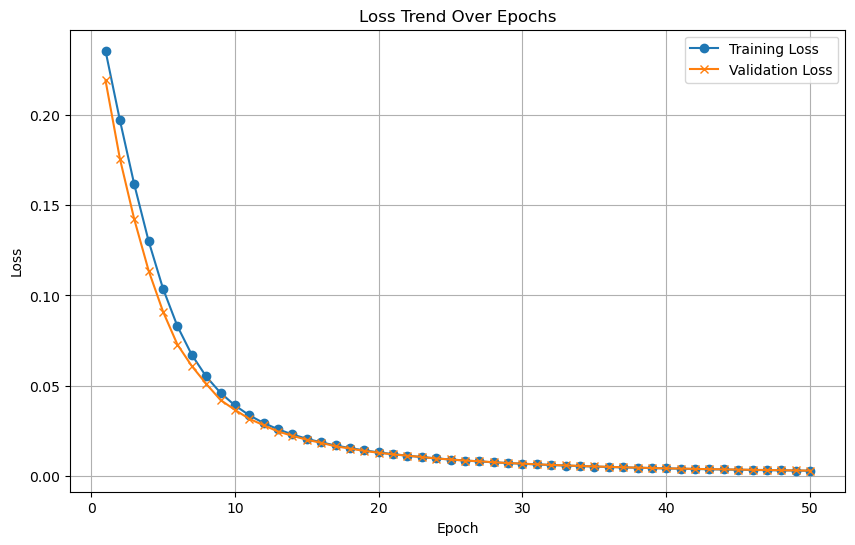

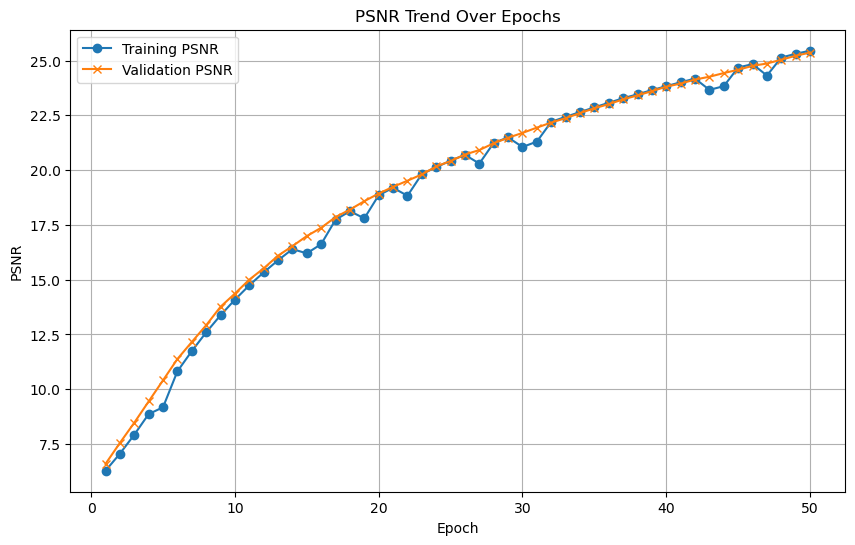

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5792
    Validation Batch [1/1], Loss: 2.5708
Validation Loss: 2.5708, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5708. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5645
    Validation Batch [1/1], Loss: 2.5708
Validation Loss: 2.5708, Validation Accuracy: 7.69%
Validation loss improved from 2.5708 to 2.5708. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5537
    Validation Batch [1/1], Loss: 2.5708
Validation Loss: 2.5708, Validation Accuracy: 7.69%
Validation loss improved from 2.5708 to 2.5708. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5432
    Validation Batch [1/1], Loss: 2.5707
Validation Loss: 2.5707, Validation Accuracy: 7.69%
Validation loss improved from 2.5708 to 2.5707. Saving model...

LOG: Epoch [5/1000] - 

Epoch [19/1000] completed, Average Training Loss: 2.4597
    Validation Batch [1/1], Loss: 2.5706
Validation Loss: 2.5706, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4485
    Validation Batch [1/1], Loss: 2.5706
Validation Loss: 2.5706, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4447
    Validation Batch [1/1], Loss: 2.5707
Validation Loss: 2.5707, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4383
    Validation Batch [1/1], Loss: 2.5707
Validation Loss: 2.5707, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4274
    Validation 

Epoch [45/1000] completed, Average Training Loss: 2.2697
    Validation Batch [1/1], Loss: 2.5687
Validation Loss: 2.5687, Validation Accuracy: 7.69%
Validation loss improved from 2.5691 to 2.5687. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.2408
    Validation Batch [1/1], Loss: 2.5681
Validation Loss: 2.5681, Validation Accuracy: 7.69%
Validation loss improved from 2.5687 to 2.5681. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.2655
    Validation Batch [1/1], Loss: 2.5675
Validation Loss: 2.5675, Validation Accuracy: 7.69%
Validation loss improved from 2.5681 to 2.5675. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.2456
    Validation Batch [1/1], Loss: 2.5670
Validation Loss: 2.5670, Validation Accuracy: 7.69%
Validation loss improved from 2.5675 to 2.5670. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/10

Epoch [70/1000] completed, Average Training Loss: 2.0681
    Validation Batch [1/1], Loss: 2.5106
Validation Loss: 2.5106, Validation Accuracy: 13.85%
Validation loss improved from 2.5173 to 2.5106. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 2.0700
    Validation Batch [1/1], Loss: 2.5036
Validation Loss: 2.5036, Validation Accuracy: 13.85%
Validation loss improved from 2.5106 to 2.5036. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 2.0593
    Validation Batch [1/1], Loss: 2.4961
Validation Loss: 2.4961, Validation Accuracy: 13.85%
Validation loss improved from 2.5036 to 2.4961. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 2.0372
    Validation Batch [1/1], Loss: 2.4883
Validation Loss: 2.4883, Validation Accuracy: 16.92%
Validation loss improved from 2.4961 to 2.4883. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 2.2043
Validation Loss: 2.2043, Validation Accuracy: 32.31%
Validation loss improved from 2.2195 to 2.2043. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.8487
    Validation Batch [1/1], Loss: 2.1914
Validation Loss: 2.1914, Validation Accuracy: 32.31%
Validation loss improved from 2.2043 to 2.1914. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.8540
    Validation Batch [1/1], Loss: 2.1797
Validation Loss: 2.1797, Validation Accuracy: 32.31%
Validation loss improved from 2.1914 to 2.1797. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.8296
    Validation Batch [1/1], Loss: 2.1692
Validation Loss: 2.1692, Validation Accuracy: 33.85%
Validation loss improved from 2.1797 to 2.1692. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.8119
    Vali

Epoch [121/1000] completed, Average Training Loss: 1.6270
    Validation Batch [1/1], Loss: 1.9756
Validation Loss: 1.9756, Validation Accuracy: 47.69%
Validation loss improved from 1.9854 to 1.9756. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.6230
    Validation Batch [1/1], Loss: 1.9679
Validation Loss: 1.9679, Validation Accuracy: 46.15%
Validation loss improved from 1.9756 to 1.9679. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6084
    Validation Batch [1/1], Loss: 1.9633
Validation Loss: 1.9633, Validation Accuracy: 46.15%
Validation loss improved from 1.9679 to 1.9633. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6149
    Validation Batch [1/1], Loss: 1.9595
Validation Loss: 1.9595, Validation Accuracy: 46.15%
Validation loss improved from 1.9633 to 1.9595. Saving model...

LOG: Epoch [125/1000] - Training


    Validation Batch [1/1], Loss: 1.7623
Validation Loss: 1.7623, Validation Accuracy: 55.38%
Validation loss improved from 1.7639 to 1.7623. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.4252
    Validation Batch [1/1], Loss: 1.7565
Validation Loss: 1.7565, Validation Accuracy: 60.00%
Validation loss improved from 1.7623 to 1.7565. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.4417
    Validation Batch [1/1], Loss: 1.7503
Validation Loss: 1.7503, Validation Accuracy: 63.08%
Validation loss improved from 1.7565 to 1.7503. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.3969
    Validation Batch [1/1], Loss: 1.7499
Validation Loss: 1.7499, Validation Accuracy: 63.08%
Validation loss improved from 1.7503 to 1.7499. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.3997


    Validation Batch [1/1], Loss: 1.5788
Validation Loss: 1.5788, Validation Accuracy: 64.62%
Validation loss improved from 1.5933 to 1.5788. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.2222
    Validation Batch [1/1], Loss: 1.5800
Validation Loss: 1.5800, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.2011
    Validation Batch [1/1], Loss: 1.5743
Validation Loss: 1.5743, Validation Accuracy: 66.15%
Validation loss improved from 1.5788 to 1.5743. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.1987
    Validation Batch [1/1], Loss: 1.5640
Validation Loss: 1.5640, Validation Accuracy: 69.23%
Validation loss improved from 1.5743 to 1.5640. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 1.1894
    Validation 

Epoch [198/1000] completed, Average Training Loss: 1.0120
    Validation Batch [1/1], Loss: 1.4151
Validation Loss: 1.4151, Validation Accuracy: 72.31%
Validation loss improved from 1.4235 to 1.4151. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 1.0176
    Validation Batch [1/1], Loss: 1.4107
Validation Loss: 1.4107, Validation Accuracy: 72.31%
Validation loss improved from 1.4151 to 1.4107. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.9931
    Validation Batch [1/1], Loss: 1.4094
Validation Loss: 1.4094, Validation Accuracy: 73.85%
Validation loss improved from 1.4107 to 1.4094. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.9975
    Validation Batch [1/1], Loss: 1.4049
Validation Loss: 1.4049, Validation Accuracy: 73.85%
Validation loss improved from 1.4094 to 1.4049. Saving model...

LOG: Epoch [202/1000] - Training


Epoch [225/1000] completed, Average Training Loss: 0.8279
    Validation Batch [1/1], Loss: 1.2942
Validation Loss: 1.2942, Validation Accuracy: 76.92%
Validation loss improved from 1.2993 to 1.2942. Saving model...

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.8135
    Validation Batch [1/1], Loss: 1.2930
Validation Loss: 1.2930, Validation Accuracy: 76.92%
Validation loss improved from 1.2942 to 1.2930. Saving model...

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.7984
    Validation Batch [1/1], Loss: 1.2910
Validation Loss: 1.2910, Validation Accuracy: 78.46%
Validation loss improved from 1.2930 to 1.2910. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.8030
    Validation Batch [1/1], Loss: 1.2868
Validation Loss: 1.2868, Validation Accuracy: 76.92%
Validation loss improved from 1.2910 to 1.2868. Saving model...

LOG: Epoch [229/1000] - Training


Epoch [251/1000] completed, Average Training Loss: 0.6284
    Validation Batch [1/1], Loss: 1.1878
Validation Loss: 1.1878, Validation Accuracy: 76.92%
Validation loss improved from 1.2148 to 1.1878. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.6553
    Validation Batch [1/1], Loss: 1.2008
Validation Loss: 1.2008, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.6385
    Validation Batch [1/1], Loss: 1.2333
Validation Loss: 1.2333, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.6458
    Validation Batch [1/1], Loss: 1.2197
Validation Loss: 1.2197, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training 

Epoch [275/1000] completed, Average Training Loss: 0.5253
    Validation Batch [1/1], Loss: 1.1524
Validation Loss: 1.1524, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.4858
    Validation Batch [1/1], Loss: 1.1569
Validation Loss: 1.1569, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.4729
    Validation Batch [1/1], Loss: 1.1666
Validation Loss: 1.1666, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.4943
    Validation Batch [1/1], Loss: 1.1623
Validation Loss: 1.1623, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4892
  

    Validation Batch [1/1], Loss: 1.1114
Validation Loss: 1.1114, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.3995
    Validation Batch [1/1], Loss: 1.1089
Validation Loss: 1.1089, Validation Accuracy: 75.38%
Validation loss improved from 1.1089 to 1.1089. Saving model...

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3960
    Validation Batch [1/1], Loss: 1.1096
Validation Loss: 1.1096, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3880
    Validation Batch [1/1], Loss: 1.1089
Validation Loss: 1.1089, Validation Accuracy: 75.38%
Validation loss improved from 1.1089 to 1.1089. Saving model...

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3963
    Validation Batch [1/1], Lo

Epoch [327/1000] completed, Average Training Loss: 0.3013
    Validation Batch [1/1], Loss: 1.1038
Validation Loss: 1.1038, Validation Accuracy: 73.85%
Validation loss improved from 1.1067 to 1.1038. Saving model...

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.2932
    Validation Batch [1/1], Loss: 1.1210
Validation Loss: 1.1210, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.2718
    Validation Batch [1/1], Loss: 1.1251
Validation Loss: 1.1251, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.2972
    Validation Batch [1/1], Loss: 1.1148
Validation Loss: 1.1148, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training 

Epoch [354/1000] completed, Average Training Loss: 0.2417
    Validation Batch [1/1], Loss: 1.1249
Validation Loss: 1.1249, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2319
    Validation Batch [1/1], Loss: 1.1257
Validation Loss: 1.1257, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2195
    Validation Batch [1/1], Loss: 1.1248
Validation Loss: 1.1248, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2009
    Validation Batch [1/1], Loss: 1.1424
Validation Loss: 1.1424, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.221

Epoch [381/1000] completed, Average Training Loss: 0.1559
    Validation Batch [1/1], Loss: 1.1377
Validation Loss: 1.1377, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.1611
    Validation Batch [1/1], Loss: 1.1802
Validation Loss: 1.1802, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.1705
    Validation Batch [1/1], Loss: 1.1953
Validation Loss: 1.1953, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.1741
    Validation Batch [1/1], Loss: 1.1582
Validation Loss: 1.1582, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.181

    Validation Batch [1/1], Loss: 1.1563
Validation Loss: 1.1563, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.1596
    Validation Batch [1/1], Loss: 1.1684
Validation Loss: 1.1684, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.1379
    Validation Batch [1/1], Loss: 1.2221
Validation Loss: 1.2221, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.1393
    Validation Batch [1/1], Loss: 1.2725
Validation Loss: 1.2725, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.1505
    Validation Batch [1/1], Loss: 1.2399
Validation Loss

Epoch [421/1000] completed, Average Training Loss: 0.1406
    Validation Batch [1/1], Loss: 1.2439
Validation Loss: 1.2439, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1281
    Validation Batch [1/1], Loss: 1.2447
Validation Loss: 1.2447, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1214
    Validation Batch [1/1], Loss: 1.2457
Validation Loss: 1.2457, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1262
    Validation Batch [1/1], Loss: 1.3094
Validation Loss: 1.3094, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.121

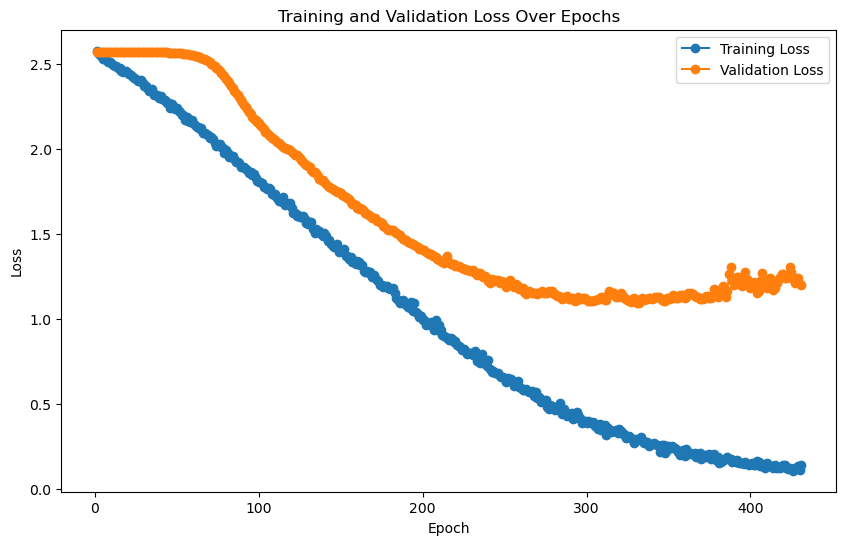

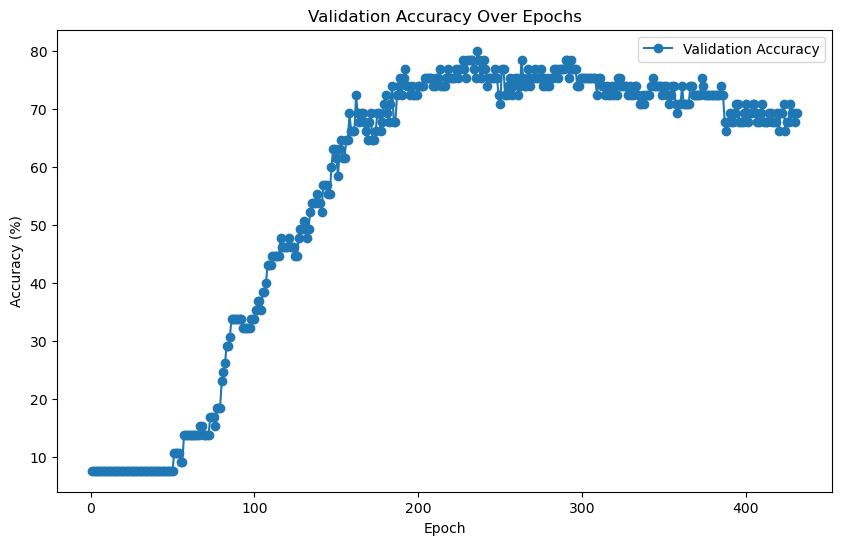


Evaluating on the test set...
    Test Batch [1/20], Loss: 0.6065

Final Test Loss: 1.2662, Test Accuracy: 81.60%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)

LOG: Training features shape: (260, 64), Training labels shape: (260,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4886, 64), Test labels shape: (4886,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 32.31%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)
Train reps shape: (260, 64)
Train labels shape: (260,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4886, 64)
Test labels shape: (4886,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6429  |  Val Loss: 2.5927
Validation loss improved from inf to 2.5927.
[Epoch 2/1000] Train Loss: 2.5781  |  Val Loss: 2.5820
Validation loss improved from 2.5927 to 2.5820.
[Epoch 3/1000] Train Loss: 2.5669  |  Val Loss: 2.5717
Validation loss improved from 2.5820 to 2.5717.
[Epoch 4/1000] Train Loss: 2.5539  |  Val Loss: 2.5544
Validation loss improved from 2.5717 to 2.5544.
[Epoch 5/1000] Train Loss: 2.5449  |  Val Loss: 2.5344
Validation loss improved from 2.5544 to 2.5344.
[Epoch 6/1000] Train Loss: 2.5303  |  Val Loss: 2.5211
Validation loss improved from 2.5344 to 2.5211.
[Epoch 7/1000] Train Loss: 2.5161  |  Val Loss: 2.5069
Validation loss improved from 2.5211 to 2.5069.
[Epoch 8/1000] Train Loss: 2.5005  |  Val Loss: 2.4891
Validation loss improved from 2.5069 to 2.4891.
[Epoch 9/1000] Train Loss: 2.4851  |  Val Loss: 2.4766
Validation loss improved from 2.4891 to 2.4766.
[Epoch 10/1000] Train Loss: 2.4780  |  Val Loss: 2.4672
Validation loss impr

[Epoch 13/1000] Train Loss: 2.4529  |  Val Loss: 2.4245
Validation loss improved from 2.4373 to 2.4245.
[Epoch 14/1000] Train Loss: 2.4534  |  Val Loss: 2.4077
Validation loss improved from 2.4245 to 2.4077.
[Epoch 15/1000] Train Loss: 2.4548  |  Val Loss: 2.4027
Validation loss improved from 2.4077 to 2.4027.
[Epoch 16/1000] Train Loss: 2.4476  |  Val Loss: 2.4081
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 17/1000] Train Loss: 2.4379  |  Val Loss: 2.4402
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 18/1000] Train Loss: 2.4396  |  Val Loss: 2.4876
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 19/1000] Train Loss: 2.4506  |  Val Loss: 2.4687
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 20/1000] Train Loss: 2.4344  |  Val Loss: 2.4355
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 21/1000] Train Loss: 2.4281  |  Val Loss: 2.4092
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 22/1000] Train Loss: 2.4208  |  Val Loss: 2.3890
Validation loss improved from 2.4027 to 2.3890.
[Epoch 23/1000] Train Loss: 2.4088  |  Val Loss: 2.3860
Validation loss improved from 2.3890 to 2.3860.
[Epoch 24/1000] Train Loss: 2.4034  |  Val Loss: 2.4062
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 25/1000] Train Loss: 2.4010  |  Val Loss: 2.4138
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 26/1000] Train Loss: 2.4001  |  Val Loss: 2.4061
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 27/1000] Train Loss: 2.3989  |  Val Loss: 2.3970
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 28/1000] Train Loss: 2.4016  |  Val Loss: 2.3961
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 29/1000] Train 

[Epoch 31/1000] Train Loss: 2.3835  |  Val Loss: 2.3688
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 2.3729  |  Val Loss: 2.3627
Validation loss improved from 2.3674 to 2.3627.
[Epoch 33/1000] Train Loss: 2.3813  |  Val Loss: 2.3652
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 2.3820  |  Val Loss: 2.3747
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 35/1000] Train Loss: 2.3707  |  Val Loss: 2.3396
Validation loss improved from 2.3627 to 2.3396.
[Epoch 36/1000] Train Loss: 2.3723  |  Val Loss: 2.3422
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 37/1000] Train Loss: 2.3733  |  Val Loss: 2.3508
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 38/1000] Train Loss: 2.3624  |  Val Loss: 2.3581
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 39/1000] Train Loss: 2.3559  |  Val Loss: 2.3629
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 40/1000] Train Loss: 2.3556  |  Val Loss: 2.3611
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 41/1000] Train Loss: 2.3518  |  Val Loss: 2.3624
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 42/1000] Train Loss: 2.3532  |  Val Loss: 2.3819
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 43/1000] Train Loss: 2.3534  |  Val Loss: 2.3446
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 44/1000] Train Loss: 2.3623  |  Val Loss: 2.3005
Validation loss improved from 2.3396 to 2.3005.
[Epoch 45/1000] Train Loss: 2.3657  |  Val Loss: 2.2909
Validation loss improved from 2.3005 to 2.2909.
[Epoch 46/1000] Train 

[Epoch 50/1000] Train Loss: 2.3211  |  Val Loss: 2.3609
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 51/1000] Train Loss: 2.3041  |  Val Loss: 2.3446
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 52/1000] Train Loss: 2.2995  |  Val Loss: 2.3216
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 53/1000] Train Loss: 2.3119  |  Val Loss: 2.3135
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 54/1000] Train Loss: 2.2973  |  Val Loss: 2.3403
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 55/1000] Train Loss: 2.2855  |  Val Loss: 2.3166
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 56/1000] Train Loss: 2.2760  |  Val Loss: 2.3096
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 57/1000] Train Loss: 2.2695  |  Val Loss: 2.2903
Validation loss improved from 2.2909 to 2.2903.


[Epoch 58/1000] Train Loss: 2.2704  |  Val Loss: 2.2706
Validation loss improved from 2.2903 to 2.2706.
[Epoch 59/1000] Train Loss: 2.2892  |  Val Loss: 2.2748
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 2.2479  |  Val Loss: 2.3813
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 2.3448  |  Val Loss: 2.2787
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 2.2386  |  Val Loss: 2.2754
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 63/1000] Train Loss: 2.2303  |  Val Loss: 2.2738
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 64/1000] Train Loss: 2.2355  |  Val Loss: 2.2502
Validation loss improved from 2.2706 to 2.2502.
[Epoch 65/1000] Train Loss: 2.2206  |  Val Loss: 2.2321
Validation loss improved from 2.2502 to 2.2321.
[Epoch 66/1000] Train Loss: 2.2028  |  Val Loss: 2.2321
Validation loss improved from 2.2321 to 2.2321.
[Epoch 67/1000] Train Loss: 2.2023

[Epoch 69/1000] Train Loss: 2.1885  |  Val Loss: 2.2546
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 70/1000] Train Loss: 2.1971  |  Val Loss: 2.2015
Validation loss improved from 2.2230 to 2.2015.
[Epoch 71/1000] Train Loss: 2.1869  |  Val Loss: 2.2121
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 2.1876  |  Val Loss: 2.1944
Validation loss improved from 2.2015 to 2.1944.
[Epoch 73/1000] Train Loss: 2.1621  |  Val Loss: 2.2156
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 74/1000] Train Loss: 2.1753  |  Val Loss: 2.2200
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 75/1000] Train Loss: 2.2288  |  Val Loss: 2.2627
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 76/1000] Train Loss: 2.2101  |  Val Loss: 2.1953
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 77/1000] Train Loss: 2.1470  |  Val Loss: 2.1661
Validation loss improved from 2.1944 to 2.1661.
[Epoch 78/1000] Train Loss: 2.1136  |  Val Loss: 2.1836
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 2.1196  |  Val Loss: 2.1913
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 2.1156  |  Val Loss: 2.1418
Validation loss improved from 2.1661 to 2.1418.
[Epoch 81/1000] Train Loss: 2.1063  |  Val Loss: 2.1337
Validation loss improved from 2.1418 to 2.1337.
[Epoch 82/1000] Train Loss: 2.1076  |  Val Loss: 2.1238
Validation loss improved from 2.1337 to 2.1238.
[Epoch 83/1000] Train Loss: 2.0951  |  Val Loss: 2.1152
Validation loss improved from 2.1238 to 2.1152.
[Epoch 84/1000] Train Loss: 2.0816  |  V

[Epoch 87/1000] Train Loss: 2.1046  |  Val Loss: 2.1435
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 88/1000] Train Loss: 2.0927  |  Val Loss: 2.1142
Validation loss improved from 2.1152 to 2.1142.
[Epoch 89/1000] Train Loss: 2.0424  |  Val Loss: 2.0971
Validation loss improved from 2.1142 to 2.0971.
[Epoch 90/1000] Train Loss: 2.0581  |  Val Loss: 2.1098
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 91/1000] Train Loss: 2.0645  |  Val Loss: 2.1101
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 92/1000] Train Loss: 2.0575  |  Val Loss: 2.0988
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 93/1000] Train Loss: 2.0193  |  Val Loss: 2.1299
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 94/1000] Train Loss: 2.0248  |  Val Loss: 2.1594
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 95/1000] Train Loss: 2.0339  |  Val Loss: 2.1758
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 96/1000] Train Loss: 2.1266  |  Val Loss: 2.0231
Validation loss improved from 2.0971 to 2.0231.
[Epoch 97/1000] Train Loss: 2.0703  |  Val Loss: 2.0368
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 2.0319  |  Val Loss: 2.0358
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 1.9856  |  Val Loss: 2.0489
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 100/1000] Train Loss: 1.9768  |  Val Loss: 2.0571
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 101/1000] Train Loss: 1.9611  |  Val Loss: 2.0521
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 102/1000] Train Loss: 1.9640  |  Val Loss: 2.0457
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 103/1000] Train Loss: 1.9532  |  Val Loss: 2.0401
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 104/1

[Epoch 106/1000] Train Loss: 1.9378  |  Val Loss: 2.0149
Validation loss improved from 2.0231 to 2.0149.
[Epoch 107/1000] Train Loss: 1.9353  |  Val Loss: 2.0213
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 108/1000] Train Loss: 1.9686  |  Val Loss: 2.0327
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 109/1000] Train Loss: 1.9453  |  Val Loss: 2.0042
Validation loss improved from 2.0149 to 2.0042.
[Epoch 110/1000] Train Loss: 1.9203  |  Val Loss: 2.1046
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 111/1000] Train Loss: 2.0542  |  Val Loss: 2.0243
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 112/1000] Train Loss: 1.9542  |  Val Loss: 2.0515
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 113/1000] Train Loss: 1.9796  |  Val Loss: 2.0425
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 114/1000] Train Loss: 2.1949  |  Val Loss: 2.0334
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 115/1000] Train Loss: 2.0231  |  Val Loss: 2.0443
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 116/1000] Train Loss: 1.9366  |  Val Loss: 2.0073
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 117/1000] Train Loss: 1.9079  |  Val Loss: 2.0313
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 118/1000] Train Loss: 1.9079  |  Val Loss: 2.0102
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 119/1000] Train Loss: 1.8959  |  Val Loss: 2.0476
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 120/1000] Train Loss: 1.9161  |  Val Loss: 1.9968
Validation loss improved from 2.0042 to 1.9968.
[Epoch 121/1000] Train Loss: 1.9095  |  Val Loss: 2.0087
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Train Loss: 1.9100  |  Val Loss: 1.9661
Validation loss improved from 1.9968 to 1.9661.
[Epoch 123/1000] Train Loss: 1.8782  |  Val Loss: 1.9716
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1

[Epoch 127/1000] Train Loss: 1.8738  |  Val Loss: 1.9686
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 128/1000] Train Loss: 1.8480  |  Val Loss: 1.9992
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 129/1000] Train Loss: 1.9064  |  Val Loss: 1.9391
Validation loss improved from 1.9625 to 1.9391.
[Epoch 130/1000] Train Loss: 1.8746  |  Val Loss: 2.0330
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 131/1000] Train Loss: 1.9676  |  Val Loss: 1.9458
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 132/1000] Train Loss: 1.8525  |  Val Loss: 1.9803
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 133/1000] Train Loss: 1.8694  |  Val Loss: 1.9936
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 134/1000] Train Loss: 1.8355  |  Val Loss: 1.9670
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 135/1000] Train Loss: 1.8434  |  Val Loss: 1.9526
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 136/1000] Train Loss: 1.8269  |  Val Loss: 1.9629
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 137/1000] Train Loss: 1.8254  |  Val Loss: 1.9644
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 138/1000] Train Loss: 1.8642  |  Val Loss: 1.9791
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 139/1000] Train Loss: 1.8438  |  Val Loss: 1.9278
Validation loss improved from 1.9391 to 1.9278.
[Epoch 140/1000] Train Loss: 1.8090  |  Val Loss: 1.9840
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 141/1000] Train Loss: 1.8823  |  Val Loss: 1.9849
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 142/1000] Train Loss: 1.8413  |  Val Loss: 1.9412
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 143/1000] Train Loss: 1.8151  |  Val Loss: 1.9328
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 144/1000] Train Loss: 1.7989  |  Val Loss: 1.9577
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 147/1000] Train Loss: 1.7929  |  Val Loss: 1.9312
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 148/1000] Train Loss: 1.8036  |  Val Loss: 1.9297
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 149/1000] Train Loss: 1.7844  |  Val Loss: 1.9221
Validation loss improved from 1.9278 to 1.9221.
[Epoch 150/1000] Train Loss: 1.7637  |  Val Loss: 1.9084
Validation loss improved from 1.9221 to 1.9084.
[Epoch 151/1000] Train Loss: 1.7695  |  Val Loss: 1.9087
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 1.7695  |  Val Loss: 1.8908
Validation loss improved from 1.9084 to 1.8908.
[Epoch 153/1000] Train Loss: 1.7481  |  Val Loss: 1.9048
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 1.7596  |  Val Loss: 1.8822
Validation loss improved from 1.8908 to 1.8822.
[Epoch 155/1000] Train Loss: 1.7639  |  Val Loss: 1.8725
Validation loss improved from 1.8822 to 1.8725.


[Epoch 156/1000] Train Loss: 1.7390  |  Val Loss: 1.8799
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 1.7329  |  Val Loss: 1.9320
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/1000] Train Loss: 1.7725  |  Val Loss: 1.9022
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 159/1000] Train Loss: 1.7483  |  Val Loss: 1.9739
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 160/1000] Train Loss: 1.7744  |  Val Loss: 1.9700
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 161/1000] Train Loss: 1.7630  |  Val Loss: 2.1419
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 162/1000] Train Loss: 1.8482  |  Val Loss: 2.5382
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 163/1000] Train Loss: 2.1374  |  Val Loss: 2.5124
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 164/1000] Train Loss: 2.3450  |  Val Loss: 1.9274
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 168/1000] Train Loss: 1.7791  |  Val Loss: 2.1111
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 169/1000] Train Loss: 1.8746  |  Val Loss: 1.9874
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 170/1000] Train Loss: 1.8509  |  Val Loss: 1.9745
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 171/1000] Train Loss: 1.7665  |  Val Loss: 1.9789
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 172/1000] Train Loss: 1.7603  |  Val Loss: 1.9564
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 173/1000] Train Loss: 1.7420  |  Val Loss: 1.9080
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 174/1000] Train Loss: 1.7369  |  Val Loss: 1.8855
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 175/1000] Train Loss: 1.7045  |  Val Loss: 1.8789
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 176/1000] Train Loss: 1.7076  |  Val Loss: 1.9015
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 177/1000] Train Loss: 1.7161  |  Val Loss: 1.8994
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 178/1000] Train Loss: 1.7270  |  Val Loss: 1.9156
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 179/1000] Train Loss: 1.7026  |  Val Loss: 1.8748
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 180/1000] Train Loss: 1.7036  |  Val Loss: 1.8697
Validation loss improved from 1.8725 to 1.8697.
[Epoch 181/1000] Train Loss: 1.6959  |  Val Loss: 1.8626
Validation loss improved from 1.8697 to 1.8626.
[Epoch 182/1000] Train Loss: 1.6893  |  Val Loss: 1.8683
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 183/1000] Train Loss: 1.6854  |  Val Loss: 1.9060
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 184/1000] Train Loss: 1.6899  |  Val Loss: 1.8942
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 18

[Epoch 186/1000] Train Loss: 1.7083  |  Val Loss: 1.9168
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 187/1000] Train Loss: 1.7051  |  Val Loss: 1.8853
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 188/1000] Train Loss: 1.6775  |  Val Loss: 1.9843
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 189/1000] Train Loss: 1.7282  |  Val Loss: 1.9280
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 190/1000] Train Loss: 1.6804  |  Val Loss: 1.9203
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 191/1000] Train Loss: 1.6741  |  Val Loss: 1.9043
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 192/1000] Train Loss: 1.6662  |  Val Loss: 1.9154
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 193/1000] Train Loss: 1.6629  |  Val Loss: 1.9066
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 194/1000] Train Loss: 1.6872  |  Val Loss: 1.9550
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 196/1000] Train Loss: 1.6678  |  Val Loss: 1.9470
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 197/1000] Train Loss: 1.7062  |  Val Loss: 1.9393
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 198/1000] Train Loss: 1.7139  |  Val Loss: 1.9191
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 199/1000] Train Loss: 1.6879  |  Val Loss: 1.8768
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 200/1000] Train Loss: 1.6859  |  Val Loss: 1.8987
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 201/1000] Train Loss: 1.6879  |  Val Loss: 1.9228
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 202/1000] Train Loss: 1.6783  |  Val Loss: 1.8785
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 203/1000] Train Loss: 1.6436  |  Val Loss: 1.8640
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 204/1000] Train Loss: 1.6430  |  Val Loss: 1.8705
!! Validation loss did NOT improve !! Patience:

[Epoch 207/1000] Train Loss: 1.6261  |  Val Loss: 1.9058
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 1.6358  |  Val Loss: 1.9260
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 209/1000] Train Loss: 1.6812  |  Val Loss: 1.9544
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 210/1000] Train Loss: 1.6478  |  Val Loss: 2.1135
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 211/1000] Train Loss: 1.8041  |  Val Loss: 2.1835
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 212/1000] Train Loss: 1.7619  |  Val Loss: 1.9868
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 213/1000] Train Loss: 1.7007  |  Val Loss: 1.9476
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 214/1000] Train Loss: 1.6642  |  Val Loss: 1.8623
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 215/1000] Train Loss: 1.6886  |  Val Loss: 1.8477
Validation loss improved from 1.8564 to 1.8477.
[Epoch 

[Epoch 218/1000] Train Loss: 1.6285  |  Val Loss: 1.9129
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 1.6217  |  Val Loss: 2.0508
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 220/1000] Train Loss: 1.7529  |  Val Loss: 1.9265
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 221/1000] Train Loss: 1.6700  |  Val Loss: 1.8866
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 222/1000] Train Loss: 1.6842  |  Val Loss: 1.8702
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 223/1000] Train Loss: 1.6237  |  Val Loss: 1.9053
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 224/1000] Train Loss: 1.6705  |  Val Loss: 1.9453
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 225/1000] Train Loss: 1.6902  |  Val Loss: 1.9627
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 226/1000] Train Loss: 1.6764  |  Val Loss: 1.8405
Validation loss improved from 1.8477 to 1.8405.
[Epoch

[Epoch 228/1000] Train Loss: 1.7026  |  Val Loss: 1.9934
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 229/1000] Train Loss: 1.7674  |  Val Loss: 1.9097
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 230/1000] Train Loss: 1.6992  |  Val Loss: 1.9485
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 231/1000] Train Loss: 1.6843  |  Val Loss: 1.8762
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 232/1000] Train Loss: 1.6232  |  Val Loss: 1.8634
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 233/1000] Train Loss: 1.5913  |  Val Loss: 1.8629
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 234/1000] Train Loss: 1.6137  |  Val Loss: 1.8760
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 235/1000] Train Loss: 1.6119  |  Val Loss: 1.8623
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 236/1000] Train Loss: 1.5999  |  Val Loss: 1.8786
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 238/1000] Train Loss: 1.6772  |  Val Loss: 1.8825
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 239/1000] Train Loss: 1.6169  |  Val Loss: 1.9353
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 240/1000] Train Loss: 1.6060  |  Val Loss: 2.0292
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 241/1000] Train Loss: 1.7064  |  Val Loss: 2.0443
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 242/1000] Train Loss: 1.6794  |  Val Loss: 1.8956
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 243/1000] Train Loss: 1.6048  |  Val Loss: 1.8952
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 244/1000] Train Loss: 1.6466  |  Val Loss: 1.8707
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 245/1000] Train Loss: 1.5901  |  Val Loss: 1.9646
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 246/1000] Train Loss: 1.7287  |  Val Loss: 1.9740
!! Validation loss did NOT improve !! Patience:

[Epoch 249/1000] Train Loss: 1.8050  |  Val Loss: 1.9497
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 250/1000] Train Loss: 1.7186  |  Val Loss: 2.0407
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 251/1000] Train Loss: 1.7734  |  Val Loss: 1.9206
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 252/1000] Train Loss: 1.7410  |  Val Loss: 1.9689
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 253/1000] Train Loss: 1.7665  |  Val Loss: 2.0118
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 254/1000] Train Loss: 1.8996  |  Val Loss: 2.1830
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 255/1000] Train Loss: 1.8637  |  Val Loss: 1.9003
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 256/1000] Train Loss: 1.6286  |  Val Loss: 1.8608
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 257/1000] Train Loss: 1.6468  |  Val Loss: 1.9241
!! Validation loss did NOT improve !! Patience:

[Epoch 258/1000] Train Loss: 1.6272  |  Val Loss: 1.9047
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 259/1000] Train Loss: 1.6322  |  Val Loss: 1.8879
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 260/1000] Train Loss: 1.6516  |  Val Loss: 1.8592
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 261/1000] Train Loss: 1.6042  |  Val Loss: 1.8577
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 262/1000] Train Loss: 1.6052  |  Val Loss: 1.8740
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 263/1000] Train Loss: 1.6005  |  Val Loss: 1.8922
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 264/1000] Train Loss: 1.6030  |  Val Loss: 1.8960
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 265/1000] Train Loss: 1.6002  |  Val Loss: 1.8631
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 266/1000] Train Loss: 1.5709  |  Val Loss: 1.8670
!! Validation loss did NOT improve !! Patience:

[Epoch 268/1000] Train Loss: 1.5880  |  Val Loss: 1.9041
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 269/1000] Train Loss: 1.6000  |  Val Loss: 1.8557
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 270/1000] Train Loss: 1.6118  |  Val Loss: 1.8486
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 271/1000] Train Loss: 1.6263  |  Val Loss: 1.8720
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 272/1000] Train Loss: 1.5791  |  Val Loss: 1.8285
Validation loss improved from 1.8405 to 1.8285.
[Epoch 273/1000] Train Loss: 1.5744  |  Val Loss: 1.8403
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 274/1000] Train Loss: 1.5620  |  Val Loss: 1.8505
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 275/1000] Train Loss: 1.5751  |  Val Loss: 1.8653
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 276/1000] Train Loss: 1.5755  |  Val Loss: 2.1016
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 277/1000] Train Loss: 1.6913  |  Val Loss: 2.1534
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 278/1000] Train Loss: 1.7013  |  Val Loss: 2.0174
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 279/1000] Train Loss: 1.6093  |  Val Loss: 1.9046
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 280/1000] Train Loss: 1.6330  |  Val Loss: 1.9389
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 281/1000] Train Loss: 1.6258  |  Val Loss: 1.8472
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 282/1000] Train Loss: 1.5628  |  Val Loss: 1.8713
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 283/1000] Train Loss: 1.5654  |  Val Loss: 1.8968
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 284/1000] Train Loss: 1.6078  |  Val Loss: 1.9625
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 286/1000] Train Loss: 1.5634  |  Val Loss: 1.8622
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 287/1000] Train Loss: 1.5574  |  Val Loss: 1.8439
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 288/1000] Train Loss: 1.5633  |  Val Loss: 1.9182
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 289/1000] Train Loss: 1.5958  |  Val Loss: 1.8668
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 290/1000] Train Loss: 1.5717  |  Val Loss: 1.8581
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 291/1000] Train Loss: 1.5781  |  Val Loss: 1.9405
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 292/1000] Train Loss: 1.6299  |  Val Loss: 1.9185
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 293/1000] Train Loss: 1.6079  |  Val Loss: 1.9209
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 294/1000] Train Loss: 1.5769  |  Val Loss: 1.9162
!! Validation loss did NOT improve !! Patience:

[Epoch 296/1000] Train Loss: 1.6101  |  Val Loss: 2.0881
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 297/1000] Train Loss: 1.6655  |  Val Loss: 2.1502
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 298/1000] Train Loss: 1.7122  |  Val Loss: 2.4926
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 299/1000] Train Loss: 2.2363  |  Val Loss: 2.2992
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 300/1000] Train Loss: 2.0439  |  Val Loss: 1.8506
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 301/1000] Train Loss: 1.7767  |  Val Loss: 1.8569
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 302/1000] Train Loss: 1.7443  |  Val Loss: 1.9512
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 303/1000] Train Loss: 1.6598  |  Val Loss: 1.9090
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 304/1000] Train Loss: 1.6004  |  Val Loss: 2.0413
!! Validation loss did NOT improve !! Patience:

[Epoch 307/1000] Train Loss: 1.6204  |  Val Loss: 1.8853
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 308/1000] Train Loss: 1.5669  |  Val Loss: 1.8901
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 309/1000] Train Loss: 1.6211  |  Val Loss: 1.8564
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 310/1000] Train Loss: 1.5748  |  Val Loss: 1.8959
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 311/1000] Train Loss: 1.6374  |  Val Loss: 1.9112
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 312/1000] Train Loss: 1.5592  |  Val Loss: 1.8867
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 313/1000] Train Loss: 1.5641  |  Val Loss: 1.9113
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 314/1000] Train Loss: 1.5461  |  Val Loss: 1.8992
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 315/1000] Train Loss: 1.5474  |  Val Loss: 1.9585
!! Validation loss did NOT improve !! Patience:

[Epoch 318/1000] Train Loss: 1.6164  |  Val Loss: 1.8808
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 319/1000] Train Loss: 1.5737  |  Val Loss: 1.8589
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 320/1000] Train Loss: 1.6222  |  Val Loss: 1.8802
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 321/1000] Train Loss: 1.5754  |  Val Loss: 1.8523
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 322/1000] Train Loss: 1.5969  |  Val Loss: 1.8776
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 323/1000] Train Loss: 1.5452  |  Val Loss: 1.8774
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 324/1000] Train Loss: 1.5307  |  Val Loss: 1.8722
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 325/1000] Train Loss: 1.5301  |  Val Loss: 1.9129
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 326/1000] Train Loss: 1.5492  |  Val Loss: 1.9002
!! Validation loss did NOT improve !! Patience:

[Epoch 328/1000] Train Loss: 1.5915  |  Val Loss: 1.8823
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 329/1000] Train Loss: 1.5624  |  Val Loss: 1.8655
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 330/1000] Train Loss: 1.5280  |  Val Loss: 1.8670
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 331/1000] Train Loss: 1.5483  |  Val Loss: 1.8648
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 332/1000] Train Loss: 1.5227  |  Val Loss: 1.8804
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 333/1000] Train Loss: 1.5861  |  Val Loss: 1.8794
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 334/1000] Train Loss: 1.6079  |  Val Loss: 1.9008
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 335/1000] Train Loss: 1.5297  |  Val Loss: 1.9019
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 336/1000] Train Loss: 1.5426  |  Val Loss: 2.0237
!! Validation loss did NOT improve !! Patience:

[Epoch 340/1000] Train Loss: 1.5291  |  Val Loss: 1.9324
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 341/1000] Train Loss: 1.5623  |  Val Loss: 1.9355
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 342/1000] Train Loss: 1.5959  |  Val Loss: 1.9383
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 343/1000] Train Loss: 1.5444  |  Val Loss: 1.9409
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 344/1000] Train Loss: 1.5495  |  Val Loss: 1.9772
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 345/1000] Train Loss: 1.5573  |  Val Loss: 1.8676
!! Validation loss did NOT improve !! Patience: 73/100


[Epoch 346/1000] Train Loss: 1.5394  |  Val Loss: 1.9091
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 347/1000] Train Loss: 1.5361  |  Val Loss: 1.8955
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 348/1000] Train Loss: 1.5371  |  Val Loss: 1.8986
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 349/1000] Train Loss: 1.5199  |  Val Loss: 2.0046
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 350/1000] Train Loss: 1.6741  |  Val Loss: 1.9243
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 351/1000] Train Loss: 1.6235  |  Val Loss: 2.0140
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 352/1000] Train Loss: 1.6614  |  Val Loss: 1.9071
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 353/1000] Train Loss: 1.5616  |  Val Loss: 1.8922
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 354/1000] Train Loss: 1.5199  |  Val Loss: 1.9126
!! Validation loss did NOT improve !! Patience:

[Epoch 356/1000] Train Loss: 1.5446  |  Val Loss: 1.9449
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 357/1000] Train Loss: 1.5292  |  Val Loss: 1.9285
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 358/1000] Train Loss: 1.5779  |  Val Loss: 1.8856
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 359/1000] Train Loss: 1.5405  |  Val Loss: 1.9424
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 360/1000] Train Loss: 1.6093  |  Val Loss: 1.8789
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 361/1000] Train Loss: 1.5741  |  Val Loss: 1.8459
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 362/1000] Train Loss: 1.5466  |  Val Loss: 1.8698
!! Validation loss did NOT improve !! Patience: 90/100


[Epoch 363/1000] Train Loss: 1.5247  |  Val Loss: 1.9250
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 364/1000] Train Loss: 1.5544  |  Val Loss: 1.9526
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 365/1000] Train Loss: 1.5895  |  Val Loss: 1.9576
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 366/1000] Train Loss: 1.5586  |  Val Loss: 1.9390
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 367/1000] Train Loss: 1.5132  |  Val Loss: 1.9133
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 368/1000] Train Loss: 1.5234  |  Val Loss: 1.8867
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 369/1000] Train Loss: 1.5379  |  Val Loss: 1.9263
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 370/1000] Train Loss: 1.5469  |  Val Loss: 1.8816
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 371/1000] Train Loss: 1.5099  |  Val Loss: 1.8820
!! Validation loss did NOT improve !! Patience:

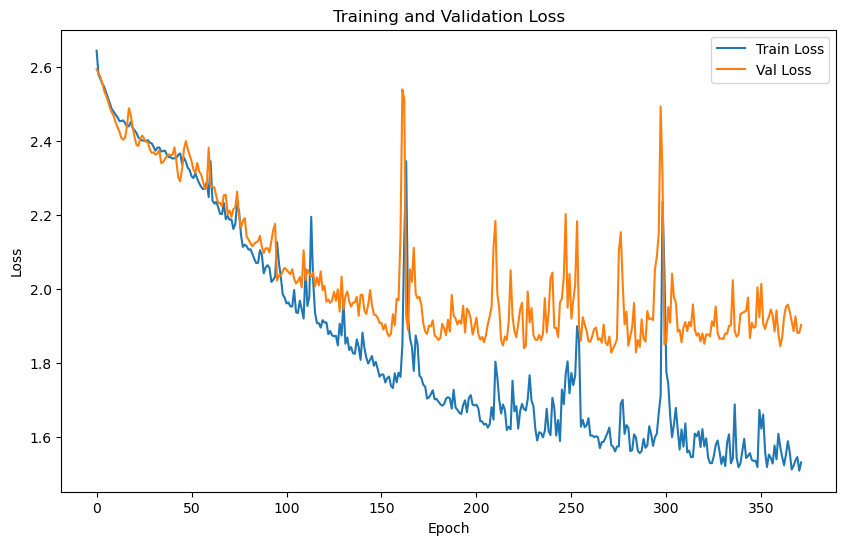

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.9394 | Test Accuracy: 33.95%


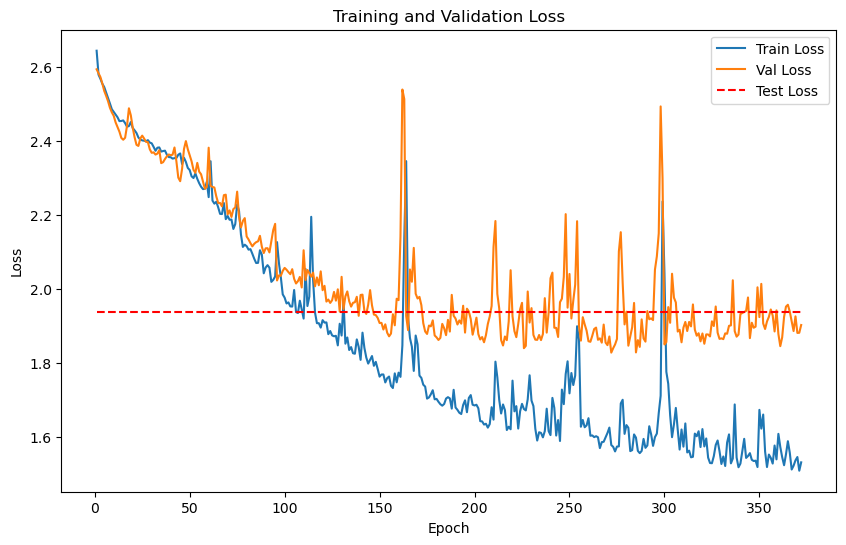

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.7078
Epoch [1/2000], Avg Train Loss: 7.7078
Epoch [1/2000], Avg Val Loss: 5.2502
Validation loss improved from inf to 5.2502. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.6027
Epoch [2/2000], Avg Train Loss: 7.6027


Epoch [2/2000], Avg Val Loss: 5.2174
Validation loss improved from 5.2502 to 5.2174. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.4775
Epoch [3/2000], Avg Train Loss: 7.4775
Epoch [3/2000], Avg Val Loss: 5.1850
Validation loss improved from 5.2174 to 5.1850. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.4681
Epoch [4/2000], Avg Train Loss: 7.4681
Epoch [4/2000], Avg Val Loss: 5.1530
Validation loss improved from 5.1850 to 5.1530. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.5111
Epoch [5/2000], Avg Train Loss: 7.5111
Epoch [5/2000], Avg Val Loss: 5.1215
Validation loss improved from 5.1530 to 5.1215. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.4019
Epoch [6/2000], Avg Train Loss: 7.4019
Epoch [6/2000], Avg Val Loss: 5.0901
Validation loss improved from 5.1215 to 5.0901. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.3221

    Batch [1/1], Train Loss: 6.9006
Epoch [18/2000], Avg Train Loss: 6.9006
Epoch [18/2000], Avg Val Loss: 4.7326
Validation loss improved from 4.7608 to 4.7326. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.9165
Epoch [19/2000], Avg Train Loss: 6.9165
Epoch [19/2000], Avg Val Loss: 4.7048
Validation loss improved from 4.7326 to 4.7048. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.7223
Epoch [20/2000], Avg Train Loss: 6.7223
Epoch [20/2000], Avg Val Loss: 4.6773
Validation loss improved from 4.7048 to 4.6773. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.7988
Epoch [21/2000], Avg Train Loss: 6.7988
Epoch [21/2000], Avg Val Loss: 4.6504
Validation loss improved from 4.6773 to 4.6504. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.7158
Epoch [22/2000], Avg Train Loss: 6.7158
Epoch [22/2000], Avg Val Loss: 4.6239
Validation loss improved from 4.6504 to 4.

    Batch [1/1], Train Loss: 6.5752
Epoch [26/2000], Avg Train Loss: 6.5752
Epoch [26/2000], Avg Val Loss: 4.5227
Validation loss improved from 4.5473 to 4.5227. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.5806
Epoch [27/2000], Avg Train Loss: 6.5806
Epoch [27/2000], Avg Val Loss: 4.4985
Validation loss improved from 4.5227 to 4.4985. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.4855
Epoch [28/2000], Avg Train Loss: 6.4855
Epoch [28/2000], Avg Val Loss: 4.4747
Validation loss improved from 4.4985 to 4.4747. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.5058
Epoch [29/2000], Avg Train Loss: 6.5058
Epoch [29/2000], Avg Val Loss: 4.4515
Validation loss improved from 4.4747 to 4.4515. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.4536
Epoch [30/2000], Avg Train Loss: 6.4536
Epoch [30/2000], Avg Val Loss: 4.4288
Validation loss improved from 4.4515 to 4.

Epoch [39/2000], Avg Val Loss: 4.2466
Validation loss improved from 4.2649 to 4.2466. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.2181
Epoch [40/2000], Avg Train Loss: 6.2181
Epoch [40/2000], Avg Val Loss: 4.2287
Validation loss improved from 4.2466 to 4.2287. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.2004
Epoch [41/2000], Avg Train Loss: 6.2004
Epoch [41/2000], Avg Val Loss: 4.2113
Validation loss improved from 4.2287 to 4.2113. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 6.1680
Epoch [42/2000], Avg Train Loss: 6.1680
Epoch [42/2000], Avg Val Loss: 4.1945
Validation loss improved from 4.2113 to 4.1945. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 6.1884
Epoch [43/2000], Avg Train Loss: 6.1884
Epoch [43/2000], Avg Val Loss: 4.1782
Validation loss improved from 4.1945 to 4.1782. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.9051
Epoch [55/2000], Avg Train Loss: 5.9051
Epoch [55/2000], Avg Val Loss: 4.0196
Validation loss improved from 4.0305 to 4.0196. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.8876
Epoch [56/2000], Avg Train Loss: 5.8876
Epoch [56/2000], Avg Val Loss: 4.0091
Validation loss improved from 4.0196 to 4.0091. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.9016
Epoch [57/2000], Avg Train Loss: 5.9016
Epoch [57/2000], Avg Val Loss: 3.9990
Validation loss improved from 4.0091 to 3.9990. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.8609
Epoch [58/2000], Avg Train Loss: 5.8609
Epoch [58/2000], Avg Val Loss: 3.9892
Validation loss improved from 3.9990 to 3.9892. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.8608
Epoch [59/2000], Avg Train Loss: 5.8608
Epoch [59/2000], Avg Val Loss: 3.9798
Validation loss improved from 3.9892 to 3.

    Batch [1/1], Train Loss: 5.8199
Epoch [63/2000], Avg Train Loss: 5.8199
Epoch [63/2000], Avg Val Loss: 3.9456
Validation loss improved from 3.9537 to 3.9456. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.7215
Epoch [64/2000], Avg Train Loss: 5.7215
Epoch [64/2000], Avg Val Loss: 3.9377
Validation loss improved from 3.9456 to 3.9377. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.8070
Epoch [65/2000], Avg Train Loss: 5.8070
Epoch [65/2000], Avg Val Loss: 3.9301
Validation loss improved from 3.9377 to 3.9301. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.7373
Epoch [66/2000], Avg Train Loss: 5.7373
Epoch [66/2000], Avg Val Loss: 3.9228
Validation loss improved from 3.9301 to 3.9228. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.7476
Epoch [67/2000], Avg Train Loss: 5.7476
Epoch [67/2000], Avg Val Loss: 3.9157
Validation loss improved from 3.9228 to 3.

Epoch [74/2000], Avg Val Loss: 3.8726
Validation loss improved from 3.8782 to 3.8726. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.7242
Epoch [75/2000], Avg Train Loss: 5.7242
Epoch [75/2000], Avg Val Loss: 3.8672
Validation loss improved from 3.8726 to 3.8672. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.6237
Epoch [76/2000], Avg Train Loss: 5.6237
Epoch [76/2000], Avg Val Loss: 3.8621
Validation loss improved from 3.8672 to 3.8621. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.6844
Epoch [77/2000], Avg Train Loss: 5.6844
Epoch [77/2000], Avg Val Loss: 3.8571
Validation loss improved from 3.8621 to 3.8571. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.5985
Epoch [78/2000], Avg Train Loss: 5.5985
Epoch [78/2000], Avg Val Loss: 3.8524
Validation loss improved from 3.8571 to 3.8524. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.5565
Epoch [93/2000], Avg Train Loss: 5.5565
Epoch [93/2000], Avg Val Loss: 3.7956
Validation loss improved from 3.7986 to 3.7956. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.5066
Epoch [94/2000], Avg Train Loss: 5.5066
Epoch [94/2000], Avg Val Loss: 3.7927
Validation loss improved from 3.7956 to 3.7927. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.4939
Epoch [95/2000], Avg Train Loss: 5.4939
Epoch [95/2000], Avg Val Loss: 3.7899
Validation loss improved from 3.7927 to 3.7899. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.5238
Epoch [96/2000], Avg Train Loss: 5.5238
Epoch [96/2000], Avg Val Loss: 3.7871
Validation loss improved from 3.7899 to 3.7871. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.5234
Epoch [97/2000], Avg Train Loss: 5.5234
Epoch [97/2000], Avg Val Loss: 3.7844
Validation loss improved from 3.7871 to 3.

Epoch [100/2000], Avg Val Loss: 3.7766
Validation loss improved from 3.7791 to 3.7766. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 5.4561
Epoch [101/2000], Avg Train Loss: 5.4561
Epoch [101/2000], Avg Val Loss: 3.7741
Validation loss improved from 3.7766 to 3.7741. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 5.4670
Epoch [102/2000], Avg Train Loss: 5.4670
Epoch [102/2000], Avg Val Loss: 3.7716
Validation loss improved from 3.7741 to 3.7716. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 5.4586
Epoch [103/2000], Avg Train Loss: 5.4586
Epoch [103/2000], Avg Val Loss: 3.7692
Validation loss improved from 3.7716 to 3.7692. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 5.4755
Epoch [104/2000], Avg Train Loss: 5.4755
Epoch [104/2000], Avg Val Loss: 3.7667
Validation loss improved from 3.7692 to 3.7667. Saving model...

LOG: Epoch [105/2000] - Training
    Bat

Epoch [112/2000], Avg Val Loss: 3.7487
Validation loss improved from 3.7509 to 3.7487. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 5.4539
Epoch [113/2000], Avg Train Loss: 5.4539
Epoch [113/2000], Avg Val Loss: 3.7467
Validation loss improved from 3.7487 to 3.7467. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 5.3939
Epoch [114/2000], Avg Train Loss: 5.3939
Epoch [114/2000], Avg Val Loss: 3.7446
Validation loss improved from 3.7467 to 3.7446. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 5.3853
Epoch [115/2000], Avg Train Loss: 5.3853
Epoch [115/2000], Avg Val Loss: 3.7426
Validation loss improved from 3.7446 to 3.7426. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 5.4015
Epoch [116/2000], Avg Train Loss: 5.4015
Epoch [116/2000], Avg Val Loss: 3.7407
Validation loss improved from 3.7426 to 3.7407. Saving model...

LOG: Epoch [117/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.3647
Epoch [128/2000], Avg Train Loss: 5.3647
Epoch [128/2000], Avg Val Loss: 3.7210
Validation loss improved from 3.7224 to 3.7210. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 5.3574
Epoch [129/2000], Avg Train Loss: 5.3574
Epoch [129/2000], Avg Val Loss: 3.7197
Validation loss improved from 3.7210 to 3.7197. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 5.3519
Epoch [130/2000], Avg Train Loss: 5.3519
Epoch [130/2000], Avg Val Loss: 3.7183
Validation loss improved from 3.7197 to 3.7183. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 5.3359
Epoch [131/2000], Avg Train Loss: 5.3359
Epoch [131/2000], Avg Val Loss: 3.7169
Validation loss improved from 3.7183 to 3.7169. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 5.3303
Epoch [132/2000], Avg Train Loss: 5.3303
Epoch [132/2000], Avg Val Loss: 3.7156
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3149
Epoch [138/2000], Avg Train Loss: 5.3149
Epoch [138/2000], Avg Val Loss: 3.7078
Validation loss improved from 3.7090 to 3.7078. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 5.3078
Epoch [139/2000], Avg Train Loss: 5.3078
Epoch [139/2000], Avg Val Loss: 3.7065
Validation loss improved from 3.7078 to 3.7065. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 5.2836
Epoch [140/2000], Avg Train Loss: 5.2836
Epoch [140/2000], Avg Val Loss: 3.7052
Validation loss improved from 3.7065 to 3.7052. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 5.3164
Epoch [141/2000], Avg Train Loss: 5.3164
Epoch [141/2000], Avg Val Loss: 3.7040
Validation loss improved from 3.7052 to 3.7040. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 5.3290
Epoch [142/2000], Avg Train Loss: 5.3290
Epoch [142/2000], Avg Val Loss: 3.7028
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2894
Epoch [151/2000], Avg Train Loss: 5.2894
Epoch [151/2000], Avg Val Loss: 3.6927
Validation loss improved from 3.6938 to 3.6927. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 5.2671
Epoch [152/2000], Avg Train Loss: 5.2671
Epoch [152/2000], Avg Val Loss: 3.6917
Validation loss improved from 3.6927 to 3.6917. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 5.2897
Epoch [153/2000], Avg Train Loss: 5.2897
Epoch [153/2000], Avg Val Loss: 3.6907
Validation loss improved from 3.6917 to 3.6907. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 5.2525
Epoch [154/2000], Avg Train Loss: 5.2525
Epoch [154/2000], Avg Val Loss: 3.6897
Validation loss improved from 3.6907 to 3.6897. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 5.3017
Epoch [155/2000], Avg Train Loss: 5.3017
Epoch [155/2000], Avg Val Loss: 3.6887
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2130
Epoch [165/2000], Avg Train Loss: 5.2130
Epoch [165/2000], Avg Val Loss: 3.6796
Validation loss improved from 3.6805 to 3.6796. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 5.2530
Epoch [166/2000], Avg Train Loss: 5.2530
Epoch [166/2000], Avg Val Loss: 3.6788
Validation loss improved from 3.6796 to 3.6788. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 5.2260
Epoch [167/2000], Avg Train Loss: 5.2260
Epoch [167/2000], Avg Val Loss: 3.6779
Validation loss improved from 3.6788 to 3.6779. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 5.2580
Epoch [168/2000], Avg Train Loss: 5.2580
Epoch [168/2000], Avg Val Loss: 3.6771
Validation loss improved from 3.6779 to 3.6771. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 5.2308
Epoch [169/2000], Avg Train Loss: 5.2308
Epoch [169/2000], Avg Val Loss: 3.6764
Validation loss improved fro

Epoch [172/2000], Avg Val Loss: 3.6742
Validation loss improved from 3.6749 to 3.6742. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 5.2442
Epoch [173/2000], Avg Train Loss: 5.2442
Epoch [173/2000], Avg Val Loss: 3.6735
Validation loss improved from 3.6742 to 3.6735. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 5.2271
Epoch [174/2000], Avg Train Loss: 5.2271
Epoch [174/2000], Avg Val Loss: 3.6728
Validation loss improved from 3.6735 to 3.6728. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 5.2600
Epoch [175/2000], Avg Train Loss: 5.2600
Epoch [175/2000], Avg Val Loss: 3.6720
Validation loss improved from 3.6728 to 3.6720. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 5.2244
Epoch [176/2000], Avg Train Loss: 5.2244
Epoch [176/2000], Avg Val Loss: 3.6713
Validation loss improved from 3.6720 to 3.6713. Saving model...

LOG: Epoch [177/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.1702
Epoch [189/2000], Avg Train Loss: 5.1702
Epoch [189/2000], Avg Val Loss: 3.6616
Validation loss improved from 3.6622 to 3.6616. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 5.2115
Epoch [190/2000], Avg Train Loss: 5.2115
Epoch [190/2000], Avg Val Loss: 3.6610
Validation loss improved from 3.6616 to 3.6610. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 5.2048
Epoch [191/2000], Avg Train Loss: 5.2048
Epoch [191/2000], Avg Val Loss: 3.6605
Validation loss improved from 3.6610 to 3.6605. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 5.2259
Epoch [192/2000], Avg Train Loss: 5.2259
Epoch [192/2000], Avg Val Loss: 3.6599
Validation loss improved from 3.6605 to 3.6599. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 5.2077
Epoch [193/2000], Avg Train Loss: 5.2077
Epoch [193/2000], Avg Val Loss: 3.6594
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1630
Epoch [202/2000], Avg Train Loss: 5.1630
Epoch [202/2000], Avg Val Loss: 3.6548
Validation loss improved from 3.6554 to 3.6548. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 5.1846
Epoch [203/2000], Avg Train Loss: 5.1846
Epoch [203/2000], Avg Val Loss: 3.6542
Validation loss improved from 3.6548 to 3.6542. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 5.1684
Epoch [204/2000], Avg Train Loss: 5.1684
Epoch [204/2000], Avg Val Loss: 3.6535
Validation loss improved from 3.6542 to 3.6535. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 5.1608
Epoch [205/2000], Avg Train Loss: 5.1608
Epoch [205/2000], Avg Val Loss: 3.6529
Validation loss improved from 3.6535 to 3.6529. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 5.1736
Epoch [206/2000], Avg Train Loss: 5.1736
Epoch [206/2000], Avg Val Loss: 3.6522
Validation loss improved fro

Epoch [210/2000], Avg Val Loss: 3.6496
Validation loss improved from 3.6502 to 3.6496. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 5.1430
Epoch [211/2000], Avg Train Loss: 5.1430
Epoch [211/2000], Avg Val Loss: 3.6491
Validation loss improved from 3.6496 to 3.6491. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 5.1504
Epoch [212/2000], Avg Train Loss: 5.1504
Epoch [212/2000], Avg Val Loss: 3.6485
Validation loss improved from 3.6491 to 3.6485. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 5.1428
Epoch [213/2000], Avg Train Loss: 5.1428
Epoch [213/2000], Avg Val Loss: 3.6480
Validation loss improved from 3.6485 to 3.6480. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 5.1282
Epoch [214/2000], Avg Train Loss: 5.1282
Epoch [214/2000], Avg Val Loss: 3.6474
Validation loss improved from 3.6480 to 3.6474. Saving model...

LOG: Epoch [215/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.1122
Epoch [227/2000], Avg Train Loss: 5.1122
Epoch [227/2000], Avg Val Loss: 3.6410
Validation loss improved from 3.6414 to 3.6410. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 5.1276
Epoch [228/2000], Avg Train Loss: 5.1276
Epoch [228/2000], Avg Val Loss: 3.6407
Validation loss improved from 3.6410 to 3.6407. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 5.1380
Epoch [229/2000], Avg Train Loss: 5.1380
Epoch [229/2000], Avg Val Loss: 3.6403
Validation loss improved from 3.6407 to 3.6403. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 5.1275
Epoch [230/2000], Avg Train Loss: 5.1275
Epoch [230/2000], Avg Val Loss: 3.6399
Validation loss improved from 3.6403 to 3.6399. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 5.1031
Epoch [231/2000], Avg Train Loss: 5.1031
Epoch [231/2000], Avg Val Loss: 3.6395
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0885
Epoch [240/2000], Avg Train Loss: 5.0885
Epoch [240/2000], Avg Val Loss: 3.6346
Validation loss improved from 3.6352 to 3.6346. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 5.1267
Epoch [241/2000], Avg Train Loss: 5.1267
Epoch [241/2000], Avg Val Loss: 3.6341
Validation loss improved from 3.6346 to 3.6341. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 5.1214
Epoch [242/2000], Avg Train Loss: 5.1214
Epoch [242/2000], Avg Val Loss: 3.6335
Validation loss improved from 3.6341 to 3.6335. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 5.1210
Epoch [243/2000], Avg Train Loss: 5.1210
Epoch [243/2000], Avg Val Loss: 3.6330
Validation loss improved from 3.6335 to 3.6330. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 5.1281
Epoch [244/2000], Avg Train Loss: 5.1281
Epoch [244/2000], Avg Val Loss: 3.6324
Validation loss improved fro

Epoch [247/2000], Avg Val Loss: 3.6305
Validation loss improved from 3.6312 to 3.6305. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 5.0863
Epoch [248/2000], Avg Train Loss: 5.0863
Epoch [248/2000], Avg Val Loss: 3.6299
Validation loss improved from 3.6305 to 3.6299. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 5.1191
Epoch [249/2000], Avg Train Loss: 5.1191
Epoch [249/2000], Avg Val Loss: 3.6293
Validation loss improved from 3.6299 to 3.6293. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 5.0742
Epoch [250/2000], Avg Train Loss: 5.0742
Epoch [250/2000], Avg Val Loss: 3.6287
Validation loss improved from 3.6293 to 3.6287. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 5.0984
Epoch [251/2000], Avg Train Loss: 5.0984
Epoch [251/2000], Avg Val Loss: 3.6281
Validation loss improved from 3.6287 to 3.6281. Saving model...

LOG: Epoch [252/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.1092
Epoch [264/2000], Avg Train Loss: 5.1092
Epoch [264/2000], Avg Val Loss: 3.6199
Validation loss improved from 3.6206 to 3.6199. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 5.0906
Epoch [265/2000], Avg Train Loss: 5.0906
Epoch [265/2000], Avg Val Loss: 3.6193
Validation loss improved from 3.6199 to 3.6193. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 5.0848
Epoch [266/2000], Avg Train Loss: 5.0848
Epoch [266/2000], Avg Val Loss: 3.6186
Validation loss improved from 3.6193 to 3.6186. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 5.0648
Epoch [267/2000], Avg Train Loss: 5.0648
Epoch [267/2000], Avg Val Loss: 3.6179
Validation loss improved from 3.6186 to 3.6179. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 5.0746
Epoch [268/2000], Avg Train Loss: 5.0746
Epoch [268/2000], Avg Val Loss: 3.6172
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0619
Epoch [276/2000], Avg Train Loss: 5.0619
Epoch [276/2000], Avg Val Loss: 3.6119
Validation loss improved from 3.6124 to 3.6119. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 5.0451
Epoch [277/2000], Avg Train Loss: 5.0451
Epoch [277/2000], Avg Val Loss: 3.6113
Validation loss improved from 3.6119 to 3.6113. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 5.0349
Epoch [278/2000], Avg Train Loss: 5.0349
Epoch [278/2000], Avg Val Loss: 3.6107
Validation loss improved from 3.6113 to 3.6107. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 5.0376
Epoch [279/2000], Avg Train Loss: 5.0376
Epoch [279/2000], Avg Val Loss: 3.6101
Validation loss improved from 3.6107 to 3.6101. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 5.0767
Epoch [280/2000], Avg Train Loss: 5.0767
Epoch [280/2000], Avg Val Loss: 3.6095
Validation loss improved fro

Epoch [286/2000], Avg Val Loss: 3.6067
Validation loss improved from 3.6070 to 3.6067. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 5.0092
Epoch [287/2000], Avg Train Loss: 5.0092
Epoch [287/2000], Avg Val Loss: 3.6062
Validation loss improved from 3.6067 to 3.6062. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 5.0661
Epoch [288/2000], Avg Train Loss: 5.0661
Epoch [288/2000], Avg Val Loss: 3.6058
Validation loss improved from 3.6062 to 3.6058. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 5.0317
Epoch [289/2000], Avg Train Loss: 5.0317
Epoch [289/2000], Avg Val Loss: 3.6053
Validation loss improved from 3.6058 to 3.6053. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 5.0798
Epoch [290/2000], Avg Train Loss: 5.0798
Epoch [290/2000], Avg Val Loss: 3.6047
Validation loss improved from 3.6053 to 3.6047. Saving model...

LOG: Epoch [291/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0374
Epoch [300/2000], Avg Train Loss: 5.0374
Epoch [300/2000], Avg Val Loss: 3.5982
Validation loss improved from 3.5988 to 3.5982. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 5.0069
Epoch [301/2000], Avg Train Loss: 5.0069
Epoch [301/2000], Avg Val Loss: 3.5975
Validation loss improved from 3.5982 to 3.5975. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 5.0470
Epoch [302/2000], Avg Train Loss: 5.0470
Epoch [302/2000], Avg Val Loss: 3.5968
Validation loss improved from 3.5975 to 3.5968. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 5.0142
Epoch [303/2000], Avg Train Loss: 5.0142
Epoch [303/2000], Avg Val Loss: 3.5962
Validation loss improved from 3.5968 to 3.5962. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 5.0458
Epoch [304/2000], Avg Train Loss: 5.0458
Epoch [304/2000], Avg Val Loss: 3.5956
Validation loss improved fro

Epoch [313/2000], Avg Val Loss: 3.5907
Validation loss improved from 3.5913 to 3.5907. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 5.0384
Epoch [314/2000], Avg Train Loss: 5.0384
Epoch [314/2000], Avg Val Loss: 3.5901
Validation loss improved from 3.5907 to 3.5901. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 5.0244
Epoch [315/2000], Avg Train Loss: 5.0244
Epoch [315/2000], Avg Val Loss: 3.5895
Validation loss improved from 3.5901 to 3.5895. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 5.0346
Epoch [316/2000], Avg Train Loss: 5.0346
Epoch [316/2000], Avg Val Loss: 3.5889
Validation loss improved from 3.5895 to 3.5889. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 5.0082
Epoch [317/2000], Avg Train Loss: 5.0082
Epoch [317/2000], Avg Val Loss: 3.5883
Validation loss improved from 3.5889 to 3.5883. Saving model...

LOG: Epoch [318/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0230
Epoch [325/2000], Avg Train Loss: 5.0230
Epoch [325/2000], Avg Val Loss: 3.5842
Validation loss improved from 3.5846 to 3.5842. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 5.0357
Epoch [326/2000], Avg Train Loss: 5.0357
Epoch [326/2000], Avg Val Loss: 3.5839
Validation loss improved from 3.5842 to 3.5839. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.9965
Epoch [327/2000], Avg Train Loss: 4.9965
Epoch [327/2000], Avg Val Loss: 3.5836
Validation loss improved from 3.5839 to 3.5836. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 5.0114
Epoch [328/2000], Avg Train Loss: 5.0114
Epoch [328/2000], Avg Val Loss: 3.5834
Validation loss improved from 3.5836 to 3.5834. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 5.0253
Epoch [329/2000], Avg Train Loss: 5.0253
Epoch [329/2000], Avg Val Loss: 3.5831
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9913
Epoch [338/2000], Avg Train Loss: 4.9913
Epoch [338/2000], Avg Val Loss: 3.5794
Validation loss improved from 3.5799 to 3.5794. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.9744
Epoch [339/2000], Avg Train Loss: 4.9744
Epoch [339/2000], Avg Val Loss: 3.5789
Validation loss improved from 3.5794 to 3.5789. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 5.0025
Epoch [340/2000], Avg Train Loss: 5.0025
Epoch [340/2000], Avg Val Loss: 3.5783
Validation loss improved from 3.5789 to 3.5783. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.9632
Epoch [341/2000], Avg Train Loss: 4.9632
Epoch [341/2000], Avg Val Loss: 3.5778
Validation loss improved from 3.5783 to 3.5778. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 5.0037
Epoch [342/2000], Avg Train Loss: 5.0037
Epoch [342/2000], Avg Val Loss: 3.5772
Validation loss improved fro

Epoch [349/2000], Avg Val Loss: 3.5736
Validation loss improved from 3.5740 to 3.5736. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.9714
Epoch [350/2000], Avg Train Loss: 4.9714
Epoch [350/2000], Avg Val Loss: 3.5733
Validation loss improved from 3.5736 to 3.5733. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.9716
Epoch [351/2000], Avg Train Loss: 4.9716
Epoch [351/2000], Avg Val Loss: 3.5729
Validation loss improved from 3.5733 to 3.5729. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 4.9762
Epoch [352/2000], Avg Train Loss: 4.9762
Epoch [352/2000], Avg Val Loss: 3.5725
Validation loss improved from 3.5729 to 3.5725. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 4.9885
Epoch [353/2000], Avg Train Loss: 4.9885
Epoch [353/2000], Avg Val Loss: 3.5721
Validation loss improved from 3.5725 to 3.5721. Saving model...

LOG: Epoch [354/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9561
Epoch [363/2000], Avg Train Loss: 4.9561
Epoch [363/2000], Avg Val Loss: 3.5673
Validation loss improved from 3.5679 to 3.5673. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 4.9580
Epoch [364/2000], Avg Train Loss: 4.9580
Epoch [364/2000], Avg Val Loss: 3.5667
Validation loss improved from 3.5673 to 3.5667. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 4.9703
Epoch [365/2000], Avg Train Loss: 4.9703
Epoch [365/2000], Avg Val Loss: 3.5661
Validation loss improved from 3.5667 to 3.5661. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 4.9413
Epoch [366/2000], Avg Train Loss: 4.9413
Epoch [366/2000], Avg Val Loss: 3.5655
Validation loss improved from 3.5661 to 3.5655. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.9904
Epoch [367/2000], Avg Train Loss: 4.9904
Epoch [367/2000], Avg Val Loss: 3.5650
Validation loss improved fro

Epoch [376/2000], Avg Val Loss: 3.5598
Validation loss improved from 3.5603 to 3.5598. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.9430
Epoch [377/2000], Avg Train Loss: 4.9430
Epoch [377/2000], Avg Val Loss: 3.5594
Validation loss improved from 3.5598 to 3.5594. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.9304
Epoch [378/2000], Avg Train Loss: 4.9304
Epoch [378/2000], Avg Val Loss: 3.5589
Validation loss improved from 3.5594 to 3.5589. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.9484
Epoch [379/2000], Avg Train Loss: 4.9484
Epoch [379/2000], Avg Val Loss: 3.5585
Validation loss improved from 3.5589 to 3.5585. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 4.9364
Epoch [380/2000], Avg Train Loss: 4.9364
Epoch [380/2000], Avg Val Loss: 3.5581
Validation loss improved from 3.5585 to 3.5581. Saving model...

LOG: Epoch [381/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9538
Epoch [389/2000], Avg Train Loss: 4.9538
Epoch [389/2000], Avg Val Loss: 3.5556
Validation loss improved from 3.5559 to 3.5556. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 4.9051
Epoch [390/2000], Avg Train Loss: 4.9051
Epoch [390/2000], Avg Val Loss: 3.5555
Validation loss improved from 3.5556 to 3.5555. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 4.9384
Epoch [391/2000], Avg Train Loss: 4.9384
Epoch [391/2000], Avg Val Loss: 3.5555
Validation loss improved from 3.5555 to 3.5555. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.9013
Epoch [392/2000], Avg Train Loss: 4.9013
Epoch [392/2000], Avg Val Loss: 3.5554
Validation loss improved from 3.5555 to 3.5554. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.9192
Epoch [393/2000], Avg Train Loss: 4.9192
Epoch [393/2000], Avg Val Loss: 3.5553
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9024
Epoch [399/2000], Avg Train Loss: 4.9024
Epoch [399/2000], Avg Val Loss: 3.5556
Validation loss did not improve. Patience: 4/100

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 4.9171
Epoch [400/2000], Avg Train Loss: 4.9171
Epoch [400/2000], Avg Val Loss: 3.5556
Validation loss did not improve. Patience: 5/100

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 4.9554
Epoch [401/2000], Avg Train Loss: 4.9554
Epoch [401/2000], Avg Val Loss: 3.5556
Validation loss did not improve. Patience: 6/100

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 4.9415
Epoch [402/2000], Avg Train Loss: 4.9415
Epoch [402/2000], Avg Val Loss: 3.5555
Validation loss did not improve. Patience: 7/100

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.9161
Epoch [403/2000], Avg Train Loss: 4.9161
Epoch [403/2000], Avg Val Loss: 3.5554
Validation loss did not improve. Patience: 8/100

LOG: Epoch [404/2000] - Training
    B

    Batch [1/1], Train Loss: 4.9174
Epoch [410/2000], Avg Train Loss: 4.9174
Epoch [410/2000], Avg Val Loss: 3.5533
Validation loss improved from 3.5538 to 3.5533. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.9165
Epoch [411/2000], Avg Train Loss: 4.9165
Epoch [411/2000], Avg Val Loss: 3.5529
Validation loss improved from 3.5533 to 3.5529. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.8490
Epoch [412/2000], Avg Train Loss: 4.8490
Epoch [412/2000], Avg Val Loss: 3.5525
Validation loss improved from 3.5529 to 3.5525. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.8912
Epoch [413/2000], Avg Train Loss: 4.8912
Epoch [413/2000], Avg Val Loss: 3.5522
Validation loss improved from 3.5525 to 3.5522. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.9145
Epoch [414/2000], Avg Train Loss: 4.9145
Epoch [414/2000], Avg Val Loss: 3.5516
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8846
Epoch [425/2000], Avg Train Loss: 4.8846
Epoch [425/2000], Avg Val Loss: 3.5466
Validation loss improved from 3.5470 to 3.5466. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.9316
Epoch [426/2000], Avg Train Loss: 4.9316
Epoch [426/2000], Avg Val Loss: 3.5463
Validation loss improved from 3.5466 to 3.5463. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.8558
Epoch [427/2000], Avg Train Loss: 4.8558
Epoch [427/2000], Avg Val Loss: 3.5458
Validation loss improved from 3.5463 to 3.5458. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.9008
Epoch [428/2000], Avg Train Loss: 4.9008
Epoch [428/2000], Avg Val Loss: 3.5453
Validation loss improved from 3.5458 to 3.5453. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.8842
Epoch [429/2000], Avg Train Loss: 4.8842
Epoch [429/2000], Avg Val Loss: 3.5448
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8608
Epoch [434/2000], Avg Train Loss: 4.8608
Epoch [434/2000], Avg Val Loss: 3.5428
Validation loss improved from 3.5433 to 3.5428. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 4.8873
Epoch [435/2000], Avg Train Loss: 4.8873
Epoch [435/2000], Avg Val Loss: 3.5424
Validation loss improved from 3.5428 to 3.5424. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 4.8998
Epoch [436/2000], Avg Train Loss: 4.8998
Epoch [436/2000], Avg Val Loss: 3.5420
Validation loss improved from 3.5424 to 3.5420. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.8961
Epoch [437/2000], Avg Train Loss: 4.8961
Epoch [437/2000], Avg Val Loss: 3.5417
Validation loss improved from 3.5420 to 3.5417. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.8787
Epoch [438/2000], Avg Train Loss: 4.8787
Epoch [438/2000], Avg Val Loss: 3.5415
Validation loss improved fro

Epoch [441/2000], Avg Val Loss: 3.5409
Validation loss improved from 3.5410 to 3.5409. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.8678
Epoch [442/2000], Avg Train Loss: 4.8678
Epoch [442/2000], Avg Val Loss: 3.5407
Validation loss improved from 3.5409 to 3.5407. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.8814
Epoch [443/2000], Avg Train Loss: 4.8814
Epoch [443/2000], Avg Val Loss: 3.5407
Validation loss did not improve. Patience: 1/100

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.8934
Epoch [444/2000], Avg Train Loss: 4.8934
Epoch [444/2000], Avg Val Loss: 3.5409
Validation loss did not improve. Patience: 2/100

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 4.8722
Epoch [445/2000], Avg Train Loss: 4.8722
Epoch [445/2000], Avg Val Loss: 3.5411
Validation loss did not improve. Patience: 3/100

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.8935
Epoch [446/2000]

Epoch [457/2000], Avg Val Loss: 3.5401
Validation loss improved from 3.5405 to 3.5401. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 4.8755
Epoch [458/2000], Avg Train Loss: 4.8755
Epoch [458/2000], Avg Val Loss: 3.5398
Validation loss improved from 3.5401 to 3.5398. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 4.8770
Epoch [459/2000], Avg Train Loss: 4.8770
Epoch [459/2000], Avg Val Loss: 3.5394
Validation loss improved from 3.5398 to 3.5394. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.8573
Epoch [460/2000], Avg Train Loss: 4.8573
Epoch [460/2000], Avg Val Loss: 3.5390
Validation loss improved from 3.5394 to 3.5390. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.8741
Epoch [461/2000], Avg Train Loss: 4.8741
Epoch [461/2000], Avg Val Loss: 3.5386
Validation loss improved from 3.5390 to 3.5386. Saving model...

LOG: Epoch [462/2000] - Training
    Bat

Epoch [470/2000], Avg Val Loss: 3.5354
Validation loss improved from 3.5356 to 3.5354. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 4.8373
Epoch [471/2000], Avg Train Loss: 4.8373
Epoch [471/2000], Avg Val Loss: 3.5353
Validation loss improved from 3.5354 to 3.5353. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.8295
Epoch [472/2000], Avg Train Loss: 4.8295
Epoch [472/2000], Avg Val Loss: 3.5353
Validation loss did not improve. Patience: 1/100

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 4.8869
Epoch [473/2000], Avg Train Loss: 4.8869
Epoch [473/2000], Avg Val Loss: 3.5354
Validation loss did not improve. Patience: 2/100

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.8628
Epoch [474/2000], Avg Train Loss: 4.8628
Epoch [474/2000], Avg Val Loss: 3.5354
Validation loss did not improve. Patience: 3/100

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 4.8316
Epoch [475/2000]

    Batch [1/1], Train Loss: 4.8378
Epoch [479/2000], Avg Train Loss: 4.8378
Epoch [479/2000], Avg Val Loss: 3.5353
Validation loss did not improve. Patience: 8/100

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.8550
Epoch [480/2000], Avg Train Loss: 4.8550
Epoch [480/2000], Avg Val Loss: 3.5352
Validation loss improved from 3.5353 to 3.5352. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.8647
Epoch [481/2000], Avg Train Loss: 4.8647
Epoch [481/2000], Avg Val Loss: 3.5350
Validation loss improved from 3.5352 to 3.5350. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 4.8076
Epoch [482/2000], Avg Train Loss: 4.8076
Epoch [482/2000], Avg Val Loss: 3.5350
Validation loss improved from 3.5350 to 3.5350. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 4.8419
Epoch [483/2000], Avg Train Loss: 4.8419
Epoch [483/2000], Avg Val Loss: 3.5349
Validation loss improved from 3.5350 to 3.5

    Batch [1/1], Train Loss: 4.8486
Epoch [494/2000], Avg Train Loss: 4.8486
Epoch [494/2000], Avg Val Loss: 3.5340
Validation loss did not improve. Patience: 3/100

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.8454
Epoch [495/2000], Avg Train Loss: 4.8454
Epoch [495/2000], Avg Val Loss: 3.5342
Validation loss did not improve. Patience: 4/100

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 4.8173
Epoch [496/2000], Avg Train Loss: 4.8173
Epoch [496/2000], Avg Val Loss: 3.5342
Validation loss did not improve. Patience: 5/100

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 4.8025
Epoch [497/2000], Avg Train Loss: 4.8025
Epoch [497/2000], Avg Val Loss: 3.5342
Validation loss did not improve. Patience: 6/100

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 4.8150
Epoch [498/2000], Avg Train Loss: 4.8150
Epoch [498/2000], Avg Val Loss: 3.5341
Validation loss did not improve. Patience: 7/100

LOG: Epoch [499/2000] - Training
    B

    Batch [1/1], Train Loss: 4.8181
Epoch [505/2000], Avg Train Loss: 4.8181
Epoch [505/2000], Avg Val Loss: 3.5341
Validation loss did not improve. Patience: 14/100

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.8198
Epoch [506/2000], Avg Train Loss: 4.8198
Epoch [506/2000], Avg Val Loss: 3.5338
Validation loss did not improve. Patience: 15/100

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.8272
Epoch [507/2000], Avg Train Loss: 4.8272
Epoch [507/2000], Avg Val Loss: 3.5335
Validation loss improved from 3.5336 to 3.5335. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 4.8068
Epoch [508/2000], Avg Train Loss: 4.8068
Epoch [508/2000], Avg Val Loss: 3.5331
Validation loss improved from 3.5335 to 3.5331. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 4.8170
Epoch [509/2000], Avg Train Loss: 4.8170
Epoch [509/2000], Avg Val Loss: 3.5327
Validation loss improved from 3.5331 to 3.5327. Saving m

Epoch [515/2000], Avg Val Loss: 3.5309
Validation loss improved from 3.5312 to 3.5309. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.8016
Epoch [516/2000], Avg Train Loss: 4.8016
Epoch [516/2000], Avg Val Loss: 3.5305
Validation loss improved from 3.5309 to 3.5305. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.8076
Epoch [517/2000], Avg Train Loss: 4.8076
Epoch [517/2000], Avg Val Loss: 3.5302
Validation loss improved from 3.5305 to 3.5302. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 4.8207
Epoch [518/2000], Avg Train Loss: 4.8207
Epoch [518/2000], Avg Val Loss: 3.5296
Validation loss improved from 3.5302 to 3.5296. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 4.8218
Epoch [519/2000], Avg Train Loss: 4.8218
Epoch [519/2000], Avg Val Loss: 3.5291
Validation loss improved from 3.5296 to 3.5291. Saving model...

LOG: Epoch [520/2000] - Training
    Bat

Epoch [531/2000], Avg Val Loss: 3.5234
Validation loss improved from 3.5236 to 3.5234. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 4.8179
Epoch [532/2000], Avg Train Loss: 4.8179
Epoch [532/2000], Avg Val Loss: 3.5232
Validation loss improved from 3.5234 to 3.5232. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 4.7798
Epoch [533/2000], Avg Train Loss: 4.7798
Epoch [533/2000], Avg Val Loss: 3.5231
Validation loss improved from 3.5232 to 3.5231. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 4.7911
Epoch [534/2000], Avg Train Loss: 4.7911
Epoch [534/2000], Avg Val Loss: 3.5232
Validation loss did not improve. Patience: 1/100

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 4.8027
Epoch [535/2000], Avg Train Loss: 4.8027
Epoch [535/2000], Avg Val Loss: 3.5236
Validation loss did not improve. Patience: 2/100

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 4.8362
E

    Batch [1/1], Train Loss: 4.8038
Epoch [542/2000], Avg Train Loss: 4.8038
Epoch [542/2000], Avg Val Loss: 3.5252
Validation loss did not improve. Patience: 9/100

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 4.7906
Epoch [543/2000], Avg Train Loss: 4.7906
Epoch [543/2000], Avg Val Loss: 3.5255
Validation loss did not improve. Patience: 10/100

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 4.8390
Epoch [544/2000], Avg Train Loss: 4.8390
Epoch [544/2000], Avg Val Loss: 3.5256
Validation loss did not improve. Patience: 11/100

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 4.7923
Epoch [545/2000], Avg Train Loss: 4.7923
Epoch [545/2000], Avg Val Loss: 3.5258
Validation loss did not improve. Patience: 12/100

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 4.8012
Epoch [546/2000], Avg Train Loss: 4.8012
Epoch [546/2000], Avg Val Loss: 3.5261
Validation loss did not improve. Patience: 13/100

LOG: Epoch [547/2000] - Training
 

Epoch [550/2000], Avg Val Loss: 3.5261
Validation loss did not improve. Patience: 17/100

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.7962
Epoch [551/2000], Avg Train Loss: 4.7962
Epoch [551/2000], Avg Val Loss: 3.5259
Validation loss did not improve. Patience: 18/100

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.8103
Epoch [552/2000], Avg Train Loss: 4.8103
Epoch [552/2000], Avg Val Loss: 3.5256
Validation loss did not improve. Patience: 19/100

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 4.7964
Epoch [553/2000], Avg Train Loss: 4.7964
Epoch [553/2000], Avg Val Loss: 3.5252
Validation loss did not improve. Patience: 20/100

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 4.7691
Epoch [554/2000], Avg Train Loss: 4.7691
Epoch [554/2000], Avg Val Loss: 3.5247
Validation loss did not improve. Patience: 21/100

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 4.8242
Epoch [555/2000], Avg Train Loss: 4.8242


    Batch [1/1], Train Loss: 4.8073
Epoch [567/2000], Avg Train Loss: 4.8073
Epoch [567/2000], Avg Val Loss: 3.5182
Validation loss improved from 3.5186 to 3.5182. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.7564
Epoch [568/2000], Avg Train Loss: 4.7564
Epoch [568/2000], Avg Val Loss: 3.5178
Validation loss improved from 3.5182 to 3.5178. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 4.7682
Epoch [569/2000], Avg Train Loss: 4.7682
Epoch [569/2000], Avg Val Loss: 3.5174
Validation loss improved from 3.5178 to 3.5174. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 4.7821
Epoch [570/2000], Avg Train Loss: 4.7821
Epoch [570/2000], Avg Val Loss: 3.5171
Validation loss improved from 3.5174 to 3.5171. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 4.7837
Epoch [571/2000], Avg Train Loss: 4.7837
Epoch [571/2000], Avg Val Loss: 3.5167
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7851
Epoch [578/2000], Avg Train Loss: 4.7851
Epoch [578/2000], Avg Val Loss: 3.5144
Validation loss did not improve. Patience: 1/100

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 4.7584
Epoch [579/2000], Avg Train Loss: 4.7584
Epoch [579/2000], Avg Val Loss: 3.5145
Validation loss did not improve. Patience: 2/100

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 4.7831
Epoch [580/2000], Avg Train Loss: 4.7831
Epoch [580/2000], Avg Val Loss: 3.5145
Validation loss did not improve. Patience: 3/100

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.7600
Epoch [581/2000], Avg Train Loss: 4.7600
Epoch [581/2000], Avg Val Loss: 3.5147
Validation loss did not improve. Patience: 4/100

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.7884
Epoch [582/2000], Avg Train Loss: 4.7884
Epoch [582/2000], Avg Val Loss: 3.5149
Validation loss did not improve. Patience: 5/100

LOG: Epoch [583/2000] - Training
    B

    Batch [1/1], Train Loss: 4.7456
Epoch [589/2000], Avg Train Loss: 4.7456
Epoch [589/2000], Avg Val Loss: 3.5150
Validation loss did not improve. Patience: 12/100

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 4.7767
Epoch [590/2000], Avg Train Loss: 4.7767
Epoch [590/2000], Avg Val Loss: 3.5151
Validation loss did not improve. Patience: 13/100

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 4.7930
Epoch [591/2000], Avg Train Loss: 4.7930
Epoch [591/2000], Avg Val Loss: 3.5150
Validation loss did not improve. Patience: 14/100

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 4.7528
Epoch [592/2000], Avg Train Loss: 4.7528
Epoch [592/2000], Avg Val Loss: 3.5151
Validation loss did not improve. Patience: 15/100

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 4.7761
Epoch [593/2000], Avg Train Loss: 4.7761
Epoch [593/2000], Avg Val Loss: 3.5150
Validation loss did not improve. Patience: 16/100

LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 4.7767
Epoch [607/2000], Avg Train Loss: 4.7767
Epoch [607/2000], Avg Val Loss: 3.5133
Validation loss did not improve. Patience: 1/100

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 4.7580
Epoch [608/2000], Avg Train Loss: 4.7580
Epoch [608/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 2/100

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 4.7464
Epoch [609/2000], Avg Train Loss: 4.7464
Epoch [609/2000], Avg Val Loss: 3.5136
Validation loss did not improve. Patience: 3/100

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 4.7855
Epoch [610/2000], Avg Train Loss: 4.7855
Epoch [610/2000], Avg Val Loss: 3.5139
Validation loss did not improve. Patience: 4/100

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 4.7415
Epoch [611/2000], Avg Train Loss: 4.7415
Epoch [611/2000], Avg Val Loss: 3.5143
Validation loss did not improve. Patience: 5/100

LOG: Epoch [612/2000] - Training
    B

    Batch [1/1], Train Loss: 4.7703
Epoch [618/2000], Avg Train Loss: 4.7703
Epoch [618/2000], Avg Val Loss: 3.5160
Validation loss did not improve. Patience: 12/100

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.7501
Epoch [619/2000], Avg Train Loss: 4.7501
Epoch [619/2000], Avg Val Loss: 3.5161
Validation loss did not improve. Patience: 13/100

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.7567
Epoch [620/2000], Avg Train Loss: 4.7567
Epoch [620/2000], Avg Val Loss: 3.5163
Validation loss did not improve. Patience: 14/100

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.7525
Epoch [621/2000], Avg Train Loss: 4.7525
Epoch [621/2000], Avg Val Loss: 3.5163
Validation loss did not improve. Patience: 15/100

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 4.7403
Epoch [622/2000], Avg Train Loss: 4.7403
Epoch [622/2000], Avg Val Loss: 3.5164
Validation loss did not improve. Patience: 16/100

LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 4.7567
Epoch [629/2000], Avg Train Loss: 4.7567
Epoch [629/2000], Avg Val Loss: 3.5145
Validation loss did not improve. Patience: 23/100

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 4.7214
Epoch [630/2000], Avg Train Loss: 4.7214
Epoch [630/2000], Avg Val Loss: 3.5142
Validation loss did not improve. Patience: 24/100

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 4.7289
Epoch [631/2000], Avg Train Loss: 4.7289
Epoch [631/2000], Avg Val Loss: 3.5138
Validation loss did not improve. Patience: 25/100

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.7484
Epoch [632/2000], Avg Train Loss: 4.7484
Epoch [632/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 26/100

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.7370
Epoch [633/2000], Avg Train Loss: 4.7370
Epoch [633/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 27/100

LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 4.6989
Epoch [646/2000], Avg Train Loss: 4.6989
Epoch [646/2000], Avg Val Loss: 3.5136
Validation loss did not improve. Patience: 40/100

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 4.7486
Epoch [647/2000], Avg Train Loss: 4.7486
Epoch [647/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 41/100

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 4.7570
Epoch [648/2000], Avg Train Loss: 4.7570
Epoch [648/2000], Avg Val Loss: 3.5134
Validation loss did not improve. Patience: 42/100

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 4.7304
Epoch [649/2000], Avg Train Loss: 4.7304
Epoch [649/2000], Avg Val Loss: 3.5133
Validation loss did not improve. Patience: 43/100

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 4.7263
Epoch [650/2000], Avg Train Loss: 4.7263
Epoch [650/2000], Avg Val Loss: 3.5132
Validation loss did not improve. Patience: 44/100

LOG: Epoch [651/2000] - Training


Epoch [659/2000], Avg Val Loss: 3.5143
Validation loss did not improve. Patience: 6/100

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 4.7253
Epoch [660/2000], Avg Train Loss: 4.7253
Epoch [660/2000], Avg Val Loss: 3.5147
Validation loss did not improve. Patience: 7/100

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 4.7172
Epoch [661/2000], Avg Train Loss: 4.7172
Epoch [661/2000], Avg Val Loss: 3.5152
Validation loss did not improve. Patience: 8/100

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 4.7493
Epoch [662/2000], Avg Train Loss: 4.7493
Epoch [662/2000], Avg Val Loss: 3.5156
Validation loss did not improve. Patience: 9/100

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 4.7355
Epoch [663/2000], Avg Train Loss: 4.7355
Epoch [663/2000], Avg Val Loss: 3.5160
Validation loss did not improve. Patience: 10/100

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.7302
Epoch [664/2000], Avg Train Loss: 4.7302
Epoc

Epoch [669/2000], Avg Val Loss: 3.5171
Validation loss did not improve. Patience: 16/100

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 4.7331
Epoch [670/2000], Avg Train Loss: 4.7331
Epoch [670/2000], Avg Val Loss: 3.5171
Validation loss did not improve. Patience: 17/100

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 4.7414
Epoch [671/2000], Avg Train Loss: 4.7414
Epoch [671/2000], Avg Val Loss: 3.5172
Validation loss did not improve. Patience: 18/100

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 4.7079
Epoch [672/2000], Avg Train Loss: 4.7079
Epoch [672/2000], Avg Val Loss: 3.5173
Validation loss did not improve. Patience: 19/100

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 4.7197
Epoch [673/2000], Avg Train Loss: 4.7197
Epoch [673/2000], Avg Val Loss: 3.5174
Validation loss did not improve. Patience: 20/100

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 4.6978
Epoch [674/2000], Avg Train Loss: 4.6978


Epoch [683/2000], Avg Val Loss: 3.5139
Validation loss did not improve. Patience: 30/100

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 4.7103
Epoch [684/2000], Avg Train Loss: 4.7103
Epoch [684/2000], Avg Val Loss: 3.5138
Validation loss did not improve. Patience: 31/100

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 4.7188
Epoch [685/2000], Avg Train Loss: 4.7188
Epoch [685/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 32/100

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 4.7010
Epoch [686/2000], Avg Train Loss: 4.7010
Epoch [686/2000], Avg Val Loss: 3.5132
Validation loss did not improve. Patience: 33/100

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 4.7237
Epoch [687/2000], Avg Train Loss: 4.7237
Epoch [687/2000], Avg Val Loss: 3.5130
Validation loss did not improve. Patience: 34/100

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 4.7108
Epoch [688/2000], Avg Train Loss: 4.7108


Epoch [696/2000], Avg Val Loss: 3.5124
Validation loss did not improve. Patience: 3/100

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 4.7487
Epoch [697/2000], Avg Train Loss: 4.7487
Epoch [697/2000], Avg Val Loss: 3.5126
Validation loss did not improve. Patience: 4/100

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 4.6793
Epoch [698/2000], Avg Train Loss: 4.6793
Epoch [698/2000], Avg Val Loss: 3.5126
Validation loss did not improve. Patience: 5/100

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 4.7039
Epoch [699/2000], Avg Train Loss: 4.7039
Epoch [699/2000], Avg Val Loss: 3.5127
Validation loss did not improve. Patience: 6/100

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 4.7280
Epoch [700/2000], Avg Train Loss: 4.7280
Epoch [700/2000], Avg Val Loss: 3.5129
Validation loss did not improve. Patience: 7/100

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 4.7096
Epoch [701/2000], Avg Train Loss: 4.7096
Epoch

    Batch [1/1], Train Loss: 4.6703
Epoch [707/2000], Avg Train Loss: 4.6703
Epoch [707/2000], Avg Val Loss: 3.5128
Validation loss did not improve. Patience: 14/100

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 4.6756
Epoch [708/2000], Avg Train Loss: 4.6756
Epoch [708/2000], Avg Val Loss: 3.5128
Validation loss did not improve. Patience: 15/100

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 4.7094
Epoch [709/2000], Avg Train Loss: 4.7094
Epoch [709/2000], Avg Val Loss: 3.5131
Validation loss did not improve. Patience: 16/100

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 4.6996
Epoch [710/2000], Avg Train Loss: 4.6996
Epoch [710/2000], Avg Val Loss: 3.5134
Validation loss did not improve. Patience: 17/100

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 4.7351
Epoch [711/2000], Avg Train Loss: 4.7351
Epoch [711/2000], Avg Val Loss: 3.5137
Validation loss did not improve. Patience: 18/100

LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 4.6924
Epoch [721/2000], Avg Train Loss: 4.6924
Epoch [721/2000], Avg Val Loss: 3.5142
Validation loss did not improve. Patience: 28/100

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 4.6602
Epoch [722/2000], Avg Train Loss: 4.6602
Epoch [722/2000], Avg Val Loss: 3.5142
Validation loss did not improve. Patience: 29/100

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 4.7206
Epoch [723/2000], Avg Train Loss: 4.7206
Epoch [723/2000], Avg Val Loss: 3.5141
Validation loss did not improve. Patience: 30/100

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 4.6989
Epoch [724/2000], Avg Train Loss: 4.6989
Epoch [724/2000], Avg Val Loss: 3.5141
Validation loss did not improve. Patience: 31/100

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 4.7264
Epoch [725/2000], Avg Train Loss: 4.7264
Epoch [725/2000], Avg Val Loss: 3.5140
Validation loss did not improve. Patience: 32/100

LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 4.6632
Epoch [734/2000], Avg Train Loss: 4.6632
Epoch [734/2000], Avg Val Loss: 3.5126
Validation loss did not improve. Patience: 41/100

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 4.7135
Epoch [735/2000], Avg Train Loss: 4.7135
Epoch [735/2000], Avg Val Loss: 3.5126
Validation loss did not improve. Patience: 42/100

LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 4.6802
Epoch [736/2000], Avg Train Loss: 4.6802
Epoch [736/2000], Avg Val Loss: 3.5125
Validation loss did not improve. Patience: 43/100

LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 4.7015
Epoch [737/2000], Avg Train Loss: 4.7015
Epoch [737/2000], Avg Val Loss: 3.5127
Validation loss did not improve. Patience: 44/100

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 4.7089
Epoch [738/2000], Avg Train Loss: 4.7089
Epoch [738/2000], Avg Val Loss: 3.5128
Validation loss did not improve. Patience: 45/100

LOG: Epoch [739/2000] - Training


Epoch [745/2000], Avg Val Loss: 3.5117
Validation loss improved from 3.5118 to 3.5117. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 4.6837
Epoch [746/2000], Avg Train Loss: 4.6837
Epoch [746/2000], Avg Val Loss: 3.5116
Validation loss improved from 3.5117 to 3.5116. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 4.6971
Epoch [747/2000], Avg Train Loss: 4.6971
Epoch [747/2000], Avg Val Loss: 3.5114
Validation loss improved from 3.5116 to 3.5114. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 4.6923
Epoch [748/2000], Avg Train Loss: 4.6923
Epoch [748/2000], Avg Val Loss: 3.5113
Validation loss improved from 3.5114 to 3.5113. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 4.6713
Epoch [749/2000], Avg Train Loss: 4.6713
Epoch [749/2000], Avg Val Loss: 3.5111
Validation loss improved from 3.5113 to 3.5111. Saving model...

LOG: Epoch [750/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6993
Epoch [763/2000], Avg Train Loss: 4.6993
Epoch [763/2000], Avg Val Loss: 3.5103
Validation loss did not improve. Patience: 4/100

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 4.6335
Epoch [764/2000], Avg Train Loss: 4.6335
Epoch [764/2000], Avg Val Loss: 3.5106
Validation loss did not improve. Patience: 5/100

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.6571
Epoch [765/2000], Avg Train Loss: 4.6571
Epoch [765/2000], Avg Val Loss: 3.5108
Validation loss did not improve. Patience: 6/100

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 4.6829
Epoch [766/2000], Avg Train Loss: 4.6829
Epoch [766/2000], Avg Val Loss: 3.5109
Validation loss did not improve. Patience: 7/100

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 4.6927
Epoch [767/2000], Avg Train Loss: 4.6927
Epoch [767/2000], Avg Val Loss: 3.5110
Validation loss did not improve. Patience: 8/100

LOG: Epoch [768/2000] - Training
    B

Epoch [774/2000], Avg Val Loss: 3.5112
Validation loss did not improve. Patience: 15/100

LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 4.6502
Epoch [775/2000], Avg Train Loss: 4.6502
Epoch [775/2000], Avg Val Loss: 3.5110
Validation loss did not improve. Patience: 16/100

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 4.6404
Epoch [776/2000], Avg Train Loss: 4.6404
Epoch [776/2000], Avg Val Loss: 3.5110
Validation loss did not improve. Patience: 17/100

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 4.6356
Epoch [777/2000], Avg Train Loss: 4.6356
Epoch [777/2000], Avg Val Loss: 3.5112
Validation loss did not improve. Patience: 18/100

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 4.6585
Epoch [778/2000], Avg Train Loss: 4.6585
Epoch [778/2000], Avg Val Loss: 3.5114
Validation loss did not improve. Patience: 19/100

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 4.6466
Epoch [779/2000], Avg Train Loss: 4.6466


    Batch [1/1], Train Loss: 4.6649
Epoch [785/2000], Avg Train Loss: 4.6649
Epoch [785/2000], Avg Val Loss: 3.5130
Validation loss did not improve. Patience: 26/100

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 4.6509
Epoch [786/2000], Avg Train Loss: 4.6509
Epoch [786/2000], Avg Val Loss: 3.5132
Validation loss did not improve. Patience: 27/100

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 4.6599
Epoch [787/2000], Avg Train Loss: 4.6599
Epoch [787/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 28/100

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 4.6431
Epoch [788/2000], Avg Train Loss: 4.6431
Epoch [788/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 29/100

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 4.6853
Epoch [789/2000], Avg Train Loss: 4.6853
Epoch [789/2000], Avg Val Loss: 3.5134
Validation loss did not improve. Patience: 30/100

LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 4.6588
Epoch [804/2000], Avg Train Loss: 4.6588
Epoch [804/2000], Avg Val Loss: 3.5169
Validation loss did not improve. Patience: 45/100

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 4.6767
Epoch [805/2000], Avg Train Loss: 4.6767
Epoch [805/2000], Avg Val Loss: 3.5173
Validation loss did not improve. Patience: 46/100

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 4.6686
Epoch [806/2000], Avg Train Loss: 4.6686
Epoch [806/2000], Avg Val Loss: 3.5176
Validation loss did not improve. Patience: 47/100

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 4.6617
Epoch [807/2000], Avg Train Loss: 4.6617
Epoch [807/2000], Avg Val Loss: 3.5178
Validation loss did not improve. Patience: 48/100

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 4.6435
Epoch [808/2000], Avg Train Loss: 4.6435
Epoch [808/2000], Avg Val Loss: 3.5179
Validation loss did not improve. Patience: 49/100

LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 4.6628
Epoch [812/2000], Avg Train Loss: 4.6628
Epoch [812/2000], Avg Val Loss: 3.5177
Validation loss did not improve. Patience: 53/100

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 4.6956
Epoch [813/2000], Avg Train Loss: 4.6956
Epoch [813/2000], Avg Val Loss: 3.5175
Validation loss did not improve. Patience: 54/100

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 4.7019
Epoch [814/2000], Avg Train Loss: 4.7019
Epoch [814/2000], Avg Val Loss: 3.5174
Validation loss did not improve. Patience: 55/100

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 4.6441
Epoch [815/2000], Avg Train Loss: 4.6441
Epoch [815/2000], Avg Val Loss: 3.5172
Validation loss did not improve. Patience: 56/100

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 4.6390
Epoch [816/2000], Avg Train Loss: 4.6390
Epoch [816/2000], Avg Val Loss: 3.5169
Validation loss did not improve. Patience: 57/100

LOG: Epoch [817/2000] - Training


Epoch [823/2000], Avg Val Loss: 3.5136
Validation loss did not improve. Patience: 64/100

LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 4.6154
Epoch [824/2000], Avg Train Loss: 4.6154
Epoch [824/2000], Avg Val Loss: 3.5133
Validation loss did not improve. Patience: 65/100

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 4.6503
Epoch [825/2000], Avg Train Loss: 4.6503
Epoch [825/2000], Avg Val Loss: 3.5130
Validation loss did not improve. Patience: 66/100

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 4.6255
Epoch [826/2000], Avg Train Loss: 4.6255
Epoch [826/2000], Avg Val Loss: 3.5127
Validation loss did not improve. Patience: 67/100

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 4.6642
Epoch [827/2000], Avg Train Loss: 4.6642
Epoch [827/2000], Avg Val Loss: 3.5125
Validation loss did not improve. Patience: 68/100

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 4.6525
Epoch [828/2000], Avg Train Loss: 4.6525


Epoch [840/2000], Avg Val Loss: 3.5083
Validation loss improved from 3.5087 to 3.5083. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 4.6380
Epoch [841/2000], Avg Train Loss: 4.6380
Epoch [841/2000], Avg Val Loss: 3.5079
Validation loss improved from 3.5083 to 3.5079. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 4.5675
Epoch [842/2000], Avg Train Loss: 4.5675
Epoch [842/2000], Avg Val Loss: 3.5078
Validation loss improved from 3.5079 to 3.5078. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 4.6645
Epoch [843/2000], Avg Train Loss: 4.6645
Epoch [843/2000], Avg Val Loss: 3.5078
Validation loss did not improve. Patience: 1/100

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 4.6537
Epoch [844/2000], Avg Train Loss: 4.6537
Epoch [844/2000], Avg Val Loss: 3.5079
Validation loss did not improve. Patience: 2/100

LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 4.6473
E

    Batch [1/1], Train Loss: 4.6305
Epoch [848/2000], Avg Train Loss: 4.6305
Epoch [848/2000], Avg Val Loss: 3.5088
Validation loss did not improve. Patience: 3/100

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 4.6149
Epoch [849/2000], Avg Train Loss: 4.6149
Epoch [849/2000], Avg Val Loss: 3.5089
Validation loss did not improve. Patience: 4/100

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 4.6359
Epoch [850/2000], Avg Train Loss: 4.6359
Epoch [850/2000], Avg Val Loss: 3.5091
Validation loss did not improve. Patience: 5/100

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 4.6095
Epoch [851/2000], Avg Train Loss: 4.6095
Epoch [851/2000], Avg Val Loss: 3.5093
Validation loss did not improve. Patience: 6/100

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 4.6288
Epoch [852/2000], Avg Train Loss: 4.6288
Epoch [852/2000], Avg Val Loss: 3.5097
Validation loss did not improve. Patience: 7/100

LOG: Epoch [853/2000] - Training
    B

    Batch [1/1], Train Loss: 4.6457
Epoch [861/2000], Avg Train Loss: 4.6457
Epoch [861/2000], Avg Val Loss: 3.5140
Validation loss did not improve. Patience: 16/100

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 4.5915
Epoch [862/2000], Avg Train Loss: 4.5915
Epoch [862/2000], Avg Val Loss: 3.5143
Validation loss did not improve. Patience: 17/100

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 4.6491
Epoch [863/2000], Avg Train Loss: 4.6491
Epoch [863/2000], Avg Val Loss: 3.5146
Validation loss did not improve. Patience: 18/100

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 4.6149
Epoch [864/2000], Avg Train Loss: 4.6149
Epoch [864/2000], Avg Val Loss: 3.5148
Validation loss did not improve. Patience: 19/100

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 4.5987
Epoch [865/2000], Avg Train Loss: 4.5987
Epoch [865/2000], Avg Val Loss: 3.5152
Validation loss did not improve. Patience: 20/100

LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 4.6014
Epoch [879/2000], Avg Train Loss: 4.6014
Epoch [879/2000], Avg Val Loss: 3.5149
Validation loss did not improve. Patience: 34/100

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 4.6246
Epoch [880/2000], Avg Train Loss: 4.6246
Epoch [880/2000], Avg Val Loss: 3.5150
Validation loss did not improve. Patience: 35/100

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 4.6413
Epoch [881/2000], Avg Train Loss: 4.6413
Epoch [881/2000], Avg Val Loss: 3.5149
Validation loss did not improve. Patience: 36/100

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 4.6033
Epoch [882/2000], Avg Train Loss: 4.6033
Epoch [882/2000], Avg Val Loss: 3.5149
Validation loss did not improve. Patience: 37/100

LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 4.6278
Epoch [883/2000], Avg Train Loss: 4.6278
Epoch [883/2000], Avg Val Loss: 3.5149
Validation loss did not improve. Patience: 38/100

LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 4.6157
Epoch [887/2000], Avg Train Loss: 4.6157
Epoch [887/2000], Avg Val Loss: 3.5144
Validation loss did not improve. Patience: 42/100

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 4.6217
Epoch [888/2000], Avg Train Loss: 4.6217
Epoch [888/2000], Avg Val Loss: 3.5140
Validation loss did not improve. Patience: 43/100

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 4.5918
Epoch [889/2000], Avg Train Loss: 4.5918
Epoch [889/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 44/100

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 4.6224
Epoch [890/2000], Avg Train Loss: 4.6224
Epoch [890/2000], Avg Val Loss: 3.5128
Validation loss did not improve. Patience: 45/100

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 4.6154
Epoch [891/2000], Avg Train Loss: 4.6154
Epoch [891/2000], Avg Val Loss: 3.5122
Validation loss did not improve. Patience: 46/100

LOG: Epoch [892/2000] - Training


Epoch [901/2000], Avg Val Loss: 3.5093
Validation loss did not improve. Patience: 56/100

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 4.6024
Epoch [902/2000], Avg Train Loss: 4.6024
Epoch [902/2000], Avg Val Loss: 3.5093
Validation loss did not improve. Patience: 57/100

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 4.6245
Epoch [903/2000], Avg Train Loss: 4.6245
Epoch [903/2000], Avg Val Loss: 3.5095
Validation loss did not improve. Patience: 58/100

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 4.6317
Epoch [904/2000], Avg Train Loss: 4.6317
Epoch [904/2000], Avg Val Loss: 3.5098
Validation loss did not improve. Patience: 59/100

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 4.6303
Epoch [905/2000], Avg Train Loss: 4.6303
Epoch [905/2000], Avg Val Loss: 3.5101
Validation loss did not improve. Patience: 60/100

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 4.5900
Epoch [906/2000], Avg Train Loss: 4.5900


    Batch [1/1], Train Loss: 4.6230
Epoch [918/2000], Avg Train Loss: 4.6230
Epoch [918/2000], Avg Val Loss: 3.5157
Validation loss did not improve. Patience: 73/100

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 4.5952
Epoch [919/2000], Avg Train Loss: 4.5952
Epoch [919/2000], Avg Val Loss: 3.5159
Validation loss did not improve. Patience: 74/100

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 4.5655
Epoch [920/2000], Avg Train Loss: 4.5655
Epoch [920/2000], Avg Val Loss: 3.5158
Validation loss did not improve. Patience: 75/100

LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 4.5927
Epoch [921/2000], Avg Train Loss: 4.5927
Epoch [921/2000], Avg Val Loss: 3.5156
Validation loss did not improve. Patience: 76/100

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 4.5798
Epoch [922/2000], Avg Train Loss: 4.5798
Epoch [922/2000], Avg Val Loss: 3.5156
Validation loss did not improve. Patience: 77/100

LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 4.6101
Epoch [923/2000], Avg Train Loss: 4.6101
Epoch [923/2000], Avg Val Loss: 3.5156
Validation loss did not improve. Patience: 78/100

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 4.5934
Epoch [924/2000], Avg Train Loss: 4.5934
Epoch [924/2000], Avg Val Loss: 3.5159
Validation loss did not improve. Patience: 79/100

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 4.5936
Epoch [925/2000], Avg Train Loss: 4.5936
Epoch [925/2000], Avg Val Loss: 3.5158
Validation loss did not improve. Patience: 80/100

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 4.5876
Epoch [926/2000], Avg Train Loss: 4.5876
Epoch [926/2000], Avg Val Loss: 3.5157
Validation loss did not improve. Patience: 81/100

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 4.5868
Epoch [927/2000], Avg Train Loss: 4.5868
Epoch [927/2000], Avg Val Loss: 3.5158
Validation loss did not improve. Patience: 82/100

LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 4.5845
Epoch [939/2000], Avg Train Loss: 4.5845
Epoch [939/2000], Avg Val Loss: 3.5137
Validation loss did not improve. Patience: 94/100

LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 4.5845
Epoch [940/2000], Avg Train Loss: 4.5845
Epoch [940/2000], Avg Val Loss: 3.5134
Validation loss did not improve. Patience: 95/100

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 4.5766
Epoch [941/2000], Avg Train Loss: 4.5766
Epoch [941/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 96/100

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 4.5567
Epoch [942/2000], Avg Train Loss: 4.5567
Epoch [942/2000], Avg Val Loss: 3.5132
Validation loss did not improve. Patience: 97/100

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 4.5876
Epoch [943/2000], Avg Train Loss: 4.5876
Epoch [943/2000], Avg Val Loss: 3.5132
Validation loss did not improve. Patience: 98/100

LOG: Epoch [944/2000] - Training


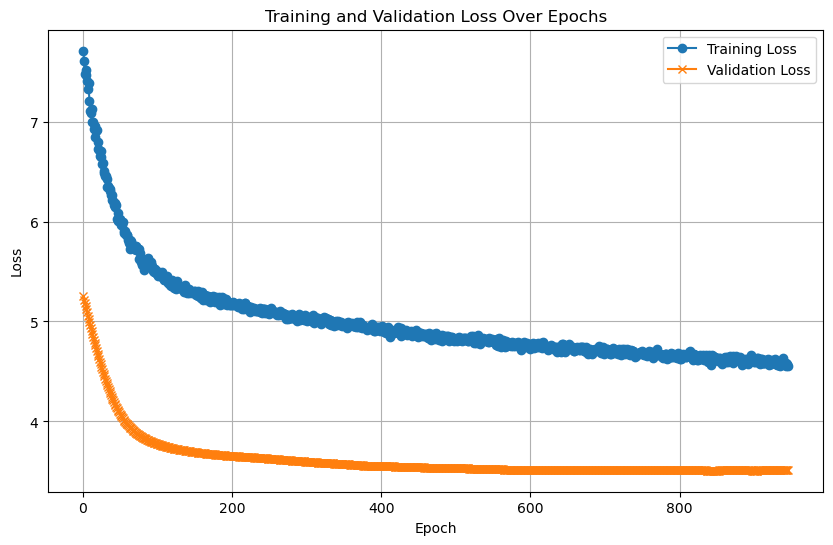

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 5.9658
Test Batch [20/20], Loss: 4.9966

Test Loss: 5.3317


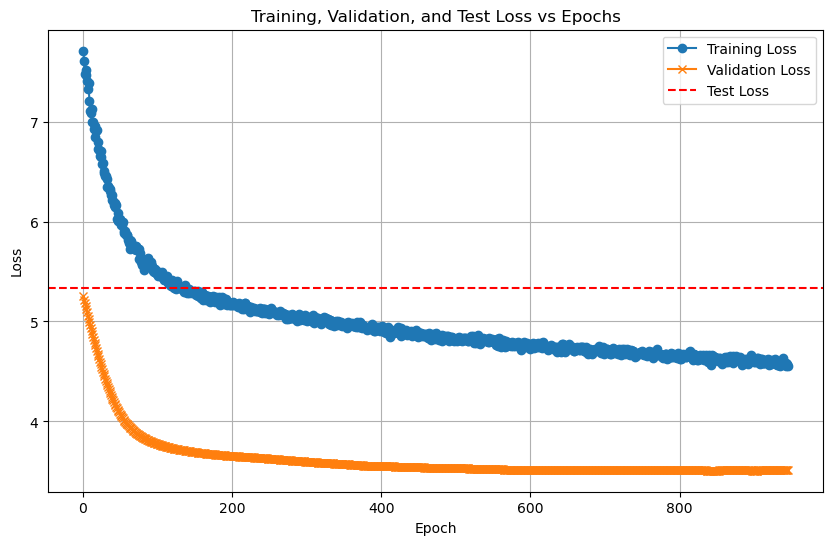

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 40.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.67      0.40      0.50         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.40      0.40      0.40         5
           6       0.27      0.60      0.38         5
           7       0.33      0.40      0.36         5
           8       0.56      1.00      0.71         5
           9       0.20      0.20      0.20         5
          10       0.80      0.80      0.80         5
          11       0.67      0.40      0.50         5
          12       0.50      0.40      0.44         5

    accuracy         

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6316  |  Val Loss: 2.6072
Validation loss improved from inf to 2.6072.
[Epoch 2/1000] Train Loss: 2.6090  |  Val Loss: 2.5868
Validation loss improved from 2.6072 to 2.5868.
[Epoch 3/1000] Train Loss: 2.5900  |  Val Loss: 2.5708
Validation loss improved from 2.5868 to 2.5708.
[Epoch 4/1000] Train Loss: 2.5754  |  Val Loss: 2.5587
Validation loss improved from 2.5708 to 2.5587.
[Epoch 5/1000] Train Loss: 2.5626  |  Val Loss: 2.5473
Validation loss improved from 2.5587 to 2.5473.
[Epoch 6/1000] Train Loss: 2.5516  |  Val Loss: 2.5377
Validation loss improved from 2.5473 to 2.5377.
[Epoch 7/1000] Train Loss: 2.5383  |  Val Loss: 2.5292
Validation loss improved from 2.5377 to 2.5292.
[Epoch 8/1000] Train Loss: 2.5289  |  Val Loss: 2.5204
Validation loss improved from 2.5292 to 2.5204.
[Epoch 9/1000] Train Loss: 2.5192  |  Val Loss: 2.5130
Validation loss improved from 2.5204 to 2.5130.


[Epoch 10/1000] Train Loss: 2.5114  |  Val Loss: 2.5072
Validation loss improved from 2.5130 to 2.5072.
[Epoch 11/1000] Train Loss: 2.5052  |  Val Loss: 2.5022
Validation loss improved from 2.5072 to 2.5022.
[Epoch 12/1000] Train Loss: 2.4974  |  Val Loss: 2.4981
Validation loss improved from 2.5022 to 2.4981.
[Epoch 13/1000] Train Loss: 2.4926  |  Val Loss: 2.4939
Validation loss improved from 2.4981 to 2.4939.
[Epoch 14/1000] Train Loss: 2.4874  |  Val Loss: 2.4911
Validation loss improved from 2.4939 to 2.4911.
[Epoch 15/1000] Train Loss: 2.4823  |  Val Loss: 2.4890
Validation loss improved from 2.4911 to 2.4890.
[Epoch 16/1000] Train Loss: 2.4779  |  Val Loss: 2.4870
Validation loss improved from 2.4890 to 2.4870.
[Epoch 17/1000] Train Loss: 2.4731  |  Val Loss: 2.4853
Validation loss improved from 2.4870 to 2.4853.
[Epoch 18/1000] Train Loss: 2.4680  |  Val Loss: 2.4835
Validation loss improved from 2.4853 to 2.4835.


[Epoch 19/1000] Train Loss: 2.4638  |  Val Loss: 2.4793
Validation loss improved from 2.4835 to 2.4793.
[Epoch 20/1000] Train Loss: 2.4585  |  Val Loss: 2.4773
Validation loss improved from 2.4793 to 2.4773.
[Epoch 21/1000] Train Loss: 2.4540  |  Val Loss: 2.4765
Validation loss improved from 2.4773 to 2.4765.
[Epoch 22/1000] Train Loss: 2.4495  |  Val Loss: 2.4759
Validation loss improved from 2.4765 to 2.4759.
[Epoch 23/1000] Train Loss: 2.4452  |  Val Loss: 2.4760
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 2.4423  |  Val Loss: 2.4754
Validation loss improved from 2.4759 to 2.4754.
[Epoch 25/1000] Train Loss: 2.4394  |  Val Loss: 2.4742
Validation loss improved from 2.4754 to 2.4742.
[Epoch 26/1000] Train Loss: 2.4358  |  Val Loss: 2.4709
Validation loss improved from 2.4742 to 2.4709.
[Epoch 27/1000] Train Loss: 2.4321  |  Val Loss: 2.4677
Validation loss improved from 2.4709 to 2.4677.
[Epoch 28/1000] Train Loss: 2.4291  |  Val Loss: 2.4646
Va

[Epoch 32/1000] Train Loss: 2.4156  |  Val Loss: 2.4535
Validation loss improved from 2.4556 to 2.4535.
[Epoch 33/1000] Train Loss: 2.4122  |  Val Loss: 2.4503
Validation loss improved from 2.4535 to 2.4503.
[Epoch 34/1000] Train Loss: 2.4083  |  Val Loss: 2.4485
Validation loss improved from 2.4503 to 2.4485.
[Epoch 35/1000] Train Loss: 2.4054  |  Val Loss: 2.4474
Validation loss improved from 2.4485 to 2.4474.
[Epoch 36/1000] Train Loss: 2.4020  |  Val Loss: 2.4459
Validation loss improved from 2.4474 to 2.4459.
[Epoch 37/1000] Train Loss: 2.3987  |  Val Loss: 2.4442
Validation loss improved from 2.4459 to 2.4442.
[Epoch 38/1000] Train Loss: 2.3958  |  Val Loss: 2.4403
Validation loss improved from 2.4442 to 2.4403.
[Epoch 39/1000] Train Loss: 2.3932  |  Val Loss: 2.4376
Validation loss improved from 2.4403 to 2.4376.


[Epoch 40/1000] Train Loss: 2.3912  |  Val Loss: 2.4358
Validation loss improved from 2.4376 to 2.4358.
[Epoch 41/1000] Train Loss: 2.3880  |  Val Loss: 2.4348
Validation loss improved from 2.4358 to 2.4348.
[Epoch 42/1000] Train Loss: 2.3846  |  Val Loss: 2.4342
Validation loss improved from 2.4348 to 2.4342.
[Epoch 43/1000] Train Loss: 2.3811  |  Val Loss: 2.4325
Validation loss improved from 2.4342 to 2.4325.
[Epoch 44/1000] Train Loss: 2.3773  |  Val Loss: 2.4313
Validation loss improved from 2.4325 to 2.4313.
[Epoch 45/1000] Train Loss: 2.3740  |  Val Loss: 2.4309
Validation loss improved from 2.4313 to 2.4309.
[Epoch 46/1000] Train Loss: 2.3705  |  Val Loss: 2.4300
Validation loss improved from 2.4309 to 2.4300.
[Epoch 47/1000] Train Loss: 2.3672  |  Val Loss: 2.4296
Validation loss improved from 2.4300 to 2.4296.
[Epoch 48/1000] Train Loss: 2.3641  |  Val Loss: 2.4285
Validation loss improved from 2.4296 to 2.4285.
[Epoch 49/1000] Train Loss: 2.3610  |  Val Loss: 2.4270
Validati

[Epoch 51/1000] Train Loss: 2.3549  |  Val Loss: 2.4235
Validation loss improved from 2.4256 to 2.4235.
[Epoch 52/1000] Train Loss: 2.3517  |  Val Loss: 2.4213
Validation loss improved from 2.4235 to 2.4213.
[Epoch 53/1000] Train Loss: 2.3484  |  Val Loss: 2.4193
Validation loss improved from 2.4213 to 2.4193.
[Epoch 54/1000] Train Loss: 2.3451  |  Val Loss: 2.4168
Validation loss improved from 2.4193 to 2.4168.
[Epoch 55/1000] Train Loss: 2.3417  |  Val Loss: 2.4136
Validation loss improved from 2.4168 to 2.4136.
[Epoch 56/1000] Train Loss: 2.3382  |  Val Loss: 2.4102
Validation loss improved from 2.4136 to 2.4102.
[Epoch 57/1000] Train Loss: 2.3348  |  Val Loss: 2.4065
Validation loss improved from 2.4102 to 2.4065.
[Epoch 58/1000] Train Loss: 2.3314  |  Val Loss: 2.4037
Validation loss improved from 2.4065 to 2.4037.
[Epoch 59/1000] Train Loss: 2.3280  |  Val Loss: 2.4015
Validation loss improved from 2.4037 to 2.4015.


[Epoch 60/1000] Train Loss: 2.3247  |  Val Loss: 2.4013
Validation loss improved from 2.4015 to 2.4013.
[Epoch 61/1000] Train Loss: 2.3216  |  Val Loss: 2.4041
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 2.3180  |  Val Loss: 2.4035
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 63/1000] Train Loss: 2.3147  |  Val Loss: 2.4014
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 64/1000] Train Loss: 2.3106  |  Val Loss: 2.3973
Validation loss improved from 2.4013 to 2.3973.
[Epoch 65/1000] Train Loss: 2.3067  |  Val Loss: 2.3933
Validation loss improved from 2.3973 to 2.3933.
[Epoch 66/1000] Train Loss: 2.3027  |  Val Loss: 2.3888
Validation loss improved from 2.3933 to 2.3888.
[Epoch 67/1000] Train Loss: 2.2990  |  Val Loss: 2.3835
Validation loss improved from 2.3888 to 2.3835.
[Epoch 68/1000] Train Loss: 2.2952  |  Val Loss: 2.3767
Validation loss improved from 2.3835 to 2.3767.
[Epoch 69/1000] Train Loss: 2.2922  |  Val Los

[Epoch 70/1000] Train Loss: 2.2884  |  Val Loss: 2.3689
Validation loss improved from 2.3719 to 2.3689.
[Epoch 71/1000] Train Loss: 2.2846  |  Val Loss: 2.3676
Validation loss improved from 2.3689 to 2.3676.
[Epoch 72/1000] Train Loss: 2.2804  |  Val Loss: 2.3675
Validation loss improved from 2.3676 to 2.3675.
[Epoch 73/1000] Train Loss: 2.2768  |  Val Loss: 2.3716
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 74/1000] Train Loss: 2.2732  |  Val Loss: 2.3709
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 75/1000] Train Loss: 2.2695  |  Val Loss: 2.3676
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 76/1000] Train Loss: 2.2657  |  Val Loss: 2.3605
Validation loss improved from 2.3675 to 2.3605.
[Epoch 77/1000] Train Loss: 2.2618  |  Val Loss: 2.3549
Validation loss improved from 2.3605 to 2.3549.
[Epoch 78/1000] Train Loss: 2.2582  |  Val Loss: 2.3517
Validation loss improved from 2.3549 to 2.3517.


[Epoch 79/1000] Train Loss: 2.2546  |  Val Loss: 2.3524
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 80/1000] Train Loss: 2.2512  |  Val Loss: 2.3511
Validation loss improved from 2.3517 to 2.3511.
[Epoch 81/1000] Train Loss: 2.2471  |  Val Loss: 2.3471
Validation loss improved from 2.3511 to 2.3471.
[Epoch 82/1000] Train Loss: 2.2430  |  Val Loss: 2.3390
Validation loss improved from 2.3471 to 2.3390.
[Epoch 83/1000] Train Loss: 2.2425  |  Val Loss: 2.3337
Validation loss improved from 2.3390 to 2.3337.
[Epoch 84/1000] Train Loss: 2.2400  |  Val Loss: 2.3317
Validation loss improved from 2.3337 to 2.3317.
[Epoch 85/1000] Train Loss: 2.2354  |  Val Loss: 2.3320
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 2.2308  |  Val Loss: 2.3340
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 2.2260  |  Val Loss: 2.3340
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 88/1000] Train Loss: 2.2220  |  V

[Epoch 93/1000] Train Loss: 2.2039  |  Val Loss: 2.3037
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 2.1988  |  Val Loss: 2.3095
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 95/1000] Train Loss: 2.1941  |  Val Loss: 2.3115
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 96/1000] Train Loss: 2.1904  |  Val Loss: 2.3123
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 97/1000] Train Loss: 2.1863  |  Val Loss: 2.3088
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 98/1000] Train Loss: 2.1824  |  Val Loss: 2.3058
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 99/1000] Train Loss: 2.1778  |  Val Loss: 2.3032
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 100/1000] Train Loss: 2.1735  |  Val Loss: 2.2997
Validation loss improved from 2.3026 to 2.2997.
[Epoch 101/1000] Train Loss: 2.1692  |  Val Loss: 2.2947
Validation loss improved from 2.2997 to 2.2947.
[Epoch 102/1000] Train Loss: 2.1646  |  Val Loss: 2.2883
Validation loss improved from 2.2947 to 2.2883.
[Epoch 103/1000] Train Loss: 2.1601  |  Val Loss: 2.2769
Validation loss improved from 2.2883 to 2.2769.
[Epoch 104/1000] Train Loss: 2.1560  |  Val Loss: 2.2687
Validation loss improved from 2.2769 to 2.2687.
[Epoch 105/1000] Train Loss: 2.1517  |  Val Loss: 2.2617
Validation loss improved from 2.2687 to 2.2617.
[Epoch 106/1000] Train Loss: 2.1486  |  Val Loss: 2.2573
Validation loss improved from 2.2617 to 2.2573.
[Epoch 107/1000] Train Loss: 2.1438  |  Val Loss: 2.2537
Validation loss improved from 2.2573 to 2.2537.
[Epoch 108/1000] Train Loss: 2.1394  |  Val Loss: 2.2504
Validation loss improved from 2.2537 to 2.2504.
[Epoch 109/1000] Train Loss: 2.1347  |  Val Loss: 2.247

[Epoch 114/1000] Train Loss: 2.1159  |  Val Loss: 2.2113
Validation loss improved from 2.2186 to 2.2113.
[Epoch 115/1000] Train Loss: 2.1110  |  Val Loss: 2.2065
Validation loss improved from 2.2113 to 2.2065.
[Epoch 116/1000] Train Loss: 2.1042  |  Val Loss: 2.2054
Validation loss improved from 2.2065 to 2.2054.
[Epoch 117/1000] Train Loss: 2.0976  |  Val Loss: 2.2066
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118/1000] Train Loss: 2.0922  |  Val Loss: 2.2074
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 119/1000] Train Loss: 2.0875  |  Val Loss: 2.2091
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 120/1000] Train Loss: 2.0822  |  Val Loss: 2.2153
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 121/1000] Train Loss: 2.0772  |  Val Loss: 2.2133
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 122/1000] Train Loss: 2.0721  |  Val Loss: 2.2078
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 123/1000] Train Loss: 2.0672  |  Val Loss: 2.2049
Validation loss improved from 2.2054 to 2.2049.
[Epoch 124/1000] Train Loss: 2.0620  |  Val Loss: 2.2053
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 125/1000] Train Loss: 2.0572  |  Val Loss: 2.2033
Validation loss improved from 2.2049 to 2.2033.
[Epoch 126/1000] Train Loss: 2.0524  |  Val Loss: 2.2004
Validation loss improved from 2.2033 to 2.2004.
[Epoch 127/1000] Train Loss: 2.0475  |  Val Loss: 2.1962
Validation loss improved from 2.2004 to 2.1962.
[Epoch 128/1000] Train Lo

[Epoch 132/1000] Train Loss: 2.0246  |  Val Loss: 2.1807
Validation loss improved from 2.1844 to 2.1807.
[Epoch 133/1000] Train Loss: 2.0194  |  Val Loss: 2.1771
Validation loss improved from 2.1807 to 2.1771.
[Epoch 134/1000] Train Loss: 2.0141  |  Val Loss: 2.1741
Validation loss improved from 2.1771 to 2.1741.
[Epoch 135/1000] Train Loss: 2.0095  |  Val Loss: 2.1760
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 136/1000] Train Loss: 2.0047  |  Val Loss: 2.1701
Validation loss improved from 2.1741 to 2.1701.
[Epoch 137/1000] Train Loss: 1.9994  |  Val Loss: 2.1636
Validation loss improved from 2.1701 to 2.1636.
[Epoch 138/1000] Train Loss: 1.9939  |  Val Loss: 2.1574
Validation loss improved from 2.1636 to 2.1574.
[Epoch 139/1000] Train Loss: 1.9883  |  Val Loss: 2.1504
Validation loss improved from 2.1574 to 2.1504.
[Epoch 140/1000] Train Loss: 1.9828  |  Val Loss: 2.1436
Validation loss improved from 2.1504 to 2.1436.
[Epoch 141/1000] Train Loss: 1.9784  |  Val Loss: 2.1406
Validation loss improved from 2.1436 to 2.1406.
[Epoch 142/1000] Train Loss: 1.9726  |  Val Loss: 2.1410
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 143/1000] Train Loss: 1.9669  |  Val Loss: 2.1413
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 144/1000] Train Loss: 1.9610  |  Val Loss: 2.1452
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 145/1000] Train Loss: 1.9555  

[Epoch 151/1000] Train Loss: 1.9210  |  Val Loss: 2.1092
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 1.9154  |  Val Loss: 2.1090
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 153/1000] Train Loss: 1.9099  |  Val Loss: 2.1053
Validation loss improved from 2.1088 to 2.1053.


[Epoch 154/1000] Train Loss: 1.9041  |  Val Loss: 2.0980
Validation loss improved from 2.1053 to 2.0980.
[Epoch 155/1000] Train Loss: 1.9006  |  Val Loss: 2.0908
Validation loss improved from 2.0980 to 2.0908.
[Epoch 156/1000] Train Loss: 1.8976  |  Val Loss: 2.0908
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 1.8928  |  Val Loss: 2.0957
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/1000] Train Loss: 1.8871  |  Val Loss: 2.0991
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 159/1000] Train Loss: 1.8802  |  Val Loss: 2.1006
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 160/1000] Train Loss: 1.8747  |  Val Loss: 2.0962
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 161/1000] Train Loss: 1.8694  |  Val Loss: 2.0890
Validation loss improved from 2.0908 to 2.0890.
[Epoch 162/1000] Train Loss: 1.8642  |  Val Loss: 2.0807
Validation loss improved from 2.0890 to 2.0807.
[Epoch 163/1000] Train Lo

[Epoch 169/1000] Train Loss: 1.8250  |  Val Loss: 2.0616
Validation loss improved from 2.0672 to 2.0616.
[Epoch 170/1000] Train Loss: 1.8193  |  Val Loss: 2.0579
Validation loss improved from 2.0616 to 2.0579.
[Epoch 171/1000] Train Loss: 1.8141  |  Val Loss: 2.0534
Validation loss improved from 2.0579 to 2.0534.
[Epoch 172/1000] Train Loss: 1.8085  |  Val Loss: 2.0469
Validation loss improved from 2.0534 to 2.0469.


[Epoch 173/1000] Train Loss: 1.8027  |  Val Loss: 2.0370
Validation loss improved from 2.0469 to 2.0370.
[Epoch 174/1000] Train Loss: 1.7986  |  Val Loss: 2.0222
Validation loss improved from 2.0370 to 2.0222.
[Epoch 175/1000] Train Loss: 1.7933  |  Val Loss: 2.0246
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 176/1000] Train Loss: 1.7879  |  Val Loss: 2.0305
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 177/1000] Train Loss: 1.7821  |  Val Loss: 2.0368
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 178/1000] Train Loss: 1.7768  |  Val Loss: 2.0393
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 179/1000] Train Loss: 1.7715  |  Val Loss: 2.0393
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 180/1000] Train Loss: 1.7661  |  Val Loss: 2.0378
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 181/1000] Train Loss: 1.7609  |  Val Loss: 2.0342
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 182/10

[Epoch 192/1000] Train Loss: 1.7016  |  Val Loss: 1.9970
Validation loss improved from 2.0016 to 1.9970.
[Epoch 193/1000] Train Loss: 1.6964  |  Val Loss: 1.9945
Validation loss improved from 1.9970 to 1.9945.
[Epoch 194/1000] Train Loss: 1.6910  |  Val Loss: 1.9955
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 195/1000] Train Loss: 1.6858  |  Val Loss: 1.9977
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 196/1000] Train Loss: 1.6804  |  Val Loss: 1.9983
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 197/1000] Train Loss: 1.6756  |  Val Loss: 1.9975
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 198/1000] Train Loss: 1.6709  |  Val Loss: 1.9950
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 199/1000] Train Loss: 1.6653  |  Val Loss: 1.9950
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 200/1000] Train Loss: 1.6601  |  Val Loss: 1.9890
Validation loss improved from 1.9945 to 1.9890.
[Epoch 201/1000] Tr

[Epoch 212/1000] Train Loss: 1.6118  |  Val Loss: 2.0310
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 213/1000] Train Loss: 1.6038  |  Val Loss: 2.0148
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 214/1000] Train Loss: 1.5946  |  Val Loss: 1.9920
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 215/1000] Train Loss: 1.5876  |  Val Loss: 1.9731
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 216/1000] Train Loss: 1.5826  |  Val Loss: 1.9606
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 217/1000] Train Loss: 1.5778  |  Val Loss: 1.9533
Validation loss improved from 1.9540 to 1.9533.
[Epoch 218/1000] Train Loss: 1.5729  |  Val Loss: 1.9482
Validation loss improved from 1.9533 to 1.9482.
[Epoch 219/1000] Train Loss: 1.5679  |  Val Loss: 1.9487
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 220/1000] Train Loss: 1.5631  |  Val Loss: 1.9515
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 221/

[Epoch 229/1000] Train Loss: 1.5224  |  Val Loss: 1.9437
Validation loss improved from 1.9482 to 1.9437.
[Epoch 230/1000] Train Loss: 1.5187  |  Val Loss: 1.9236
Validation loss improved from 1.9437 to 1.9236.
[Epoch 231/1000] Train Loss: 1.5209  |  Val Loss: 1.9207
Validation loss improved from 1.9236 to 1.9207.
[Epoch 232/1000] Train Loss: 1.5185  |  Val Loss: 1.9190
Validation loss improved from 1.9207 to 1.9190.
[Epoch 233/1000] Train Loss: 1.5081  |  Val Loss: 1.9224
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 1.5015  |  Val Loss: 1.9333
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 1.4960  |  Val Loss: 1.9416
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 236/1000] Train Loss: 1.4922  |  Val Loss: 1.9418
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 237/1000] Train Loss: 1.4882  |  Val Loss: 1.9364
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 238/1000] Train Lo

[Epoch 249/1000] Train Loss: 1.4421  |  Val Loss: 1.9316
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 250/1000] Train Loss: 1.4379  |  Val Loss: 1.9366
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 251/1000] Train Loss: 1.4342  |  Val Loss: 1.9424
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 252/1000] Train Loss: 1.4310  |  Val Loss: 1.9501
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 253/1000] Train Loss: 1.4271  |  Val Loss: 1.9522
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 254/1000] Train Loss: 1.4236  |  Val Loss: 1.9538
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 255/1000] Train Loss: 1.4203  |  Val Loss: 1.9619
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 256/1000] Train Loss: 1.4178  |  Val Loss: 1.9684
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 257/1000] Train Loss: 1.4145  |  Val Loss: 1.9757
!! Validation loss did NOT improve !! Patience:

[Epoch 270/1000] Train Loss: 1.3725  |  Val Loss: 2.0362
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 271/1000] Train Loss: 1.3729  |  Val Loss: 2.0448
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 272/1000] Train Loss: 1.3717  |  Val Loss: 1.9985
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 273/1000] Train Loss: 1.3666  |  Val Loss: 1.9539
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 274/1000] Train Loss: 1.3602  |  Val Loss: 1.9288
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 275/1000] Train Loss: 1.3567  |  Val Loss: 1.9224
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 276/1000] Train Loss: 1.3532  |  Val Loss: 1.9271
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 277/1000] Train Loss: 1.3494  |  Val Loss: 1.9343
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 278/1000] Train Loss: 1.3471  |  Val Loss: 1.9459
!! Validation loss did NOT improve !! Patience:

[Epoch 291/1000] Train Loss: 1.3108  |  Val Loss: 1.9884
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 292/1000] Train Loss: 1.3076  |  Val Loss: 1.9979
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 293/1000] Train Loss: 1.3084  |  Val Loss: 2.0023
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 294/1000] Train Loss: 1.3067  |  Val Loss: 1.9923
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 295/1000] Train Loss: 1.3015  |  Val Loss: 1.9824
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 296/1000] Train Loss: 1.2982  |  Val Loss: 1.9764
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 297/1000] Train Loss: 1.2947  |  Val Loss: 1.9867
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 298/1000] Train Loss: 1.2905  |  Val Loss: 2.0614
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 299/1000] Train Loss: 1.2920  |  Val Loss: 2.1083
!! Validation loss did NOT improve !! Patience:

[Epoch 310/1000] Train Loss: 1.2628  |  Val Loss: 2.0094
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 311/1000] Train Loss: 1.2605  |  Val Loss: 2.0116
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 312/1000] Train Loss: 1.2579  |  Val Loss: 2.0074
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 313/1000] Train Loss: 1.2566  |  Val Loss: 2.0091
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 314/1000] Train Loss: 1.2555  |  Val Loss: 2.0029
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 315/1000] Train Loss: 1.2526  |  Val Loss: 1.9889
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 316/1000] Train Loss: 1.2486  |  Val Loss: 1.9826
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 317/1000] Train Loss: 1.2462  |  Val Loss: 1.9799
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 318/1000] Train Loss: 1.2439  |  Val Loss: 1.9851
!! Validation loss did NOT improve !! Patience:

[Epoch 327/1000] Train Loss: 1.2236  |  Val Loss: 2.0065
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 328/1000] Train Loss: 1.2222  |  Val Loss: 2.0121
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 329/1000] Train Loss: 1.2209  |  Val Loss: 2.0287
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 330/1000] Train Loss: 1.2195  |  Val Loss: 2.0402
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 331/1000] Train Loss: 1.2178  |  Val Loss: 2.0477
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 332/1000] Train Loss: 1.2152  |  Val Loss: 2.0465
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 332 !!
No improvement for 100 epochs.


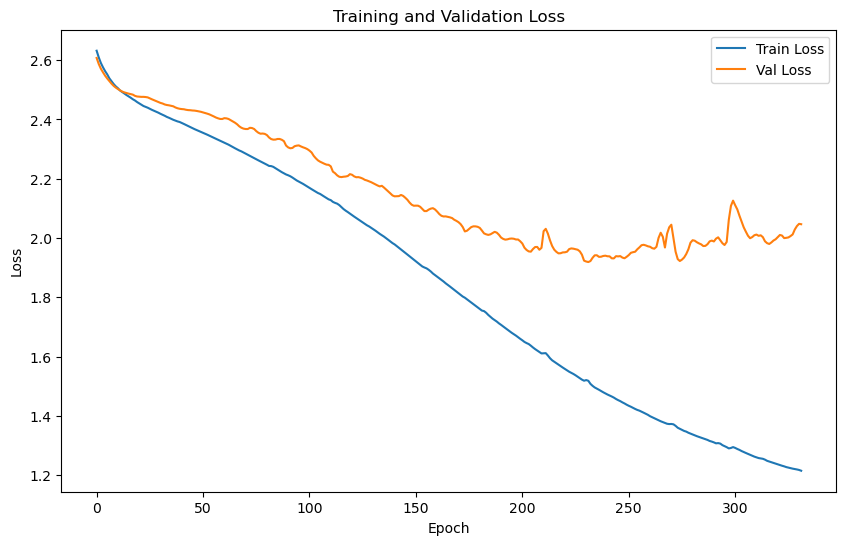

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.8010 | Test Accuracy: 52.54%


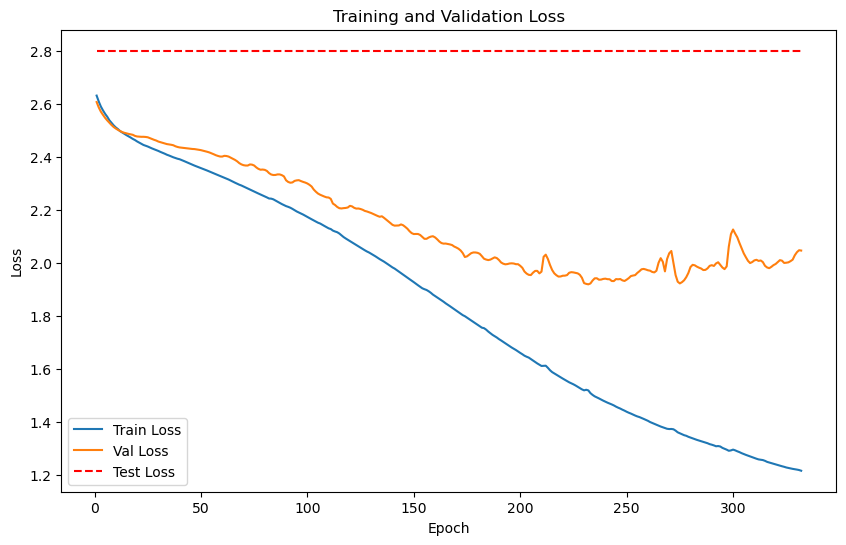

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5210
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6173
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5210, Avg Val Loss: 0.5587

Validation loss improved from inf to 0.5587. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5228
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.6171
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5228, Avg Val Loss: 0.5586

Validation loss improved from 0.5587 to 0.5586. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5212
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.6166
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5212, Avg Val Loss: 0.5583

Validation loss improved from 0.5586 to 0.5583. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5196
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6154
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5196, Avg Val Loss: 0.5577

Validation loss improved from 0.5583 to 0.5577. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5162
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6146
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5162, Avg Val Loss: 0.5573

Validation loss improved from 0.5577 to 0.5573. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.5174
LOG: Epoch [6/2000] - Validation


    Batch [1/2], Val Loss: 0.6132
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5174, Avg Val Loss: 0.5566

Validation loss improved from 0.5573 to 0.5566. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5170
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.6118
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5170, Avg Val Loss: 0.5559

Validation loss improved from 0.5566 to 0.5559. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5184
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.6108
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5184, Avg Val Loss: 0.5554

Validation loss improved from 0.5559 to 0.5554. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5154
LOG: Epoch [9/2000] - Validation


    Batch [1/2], Val Loss: 0.6101
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5154, Avg Val Loss: 0.5551

Validation loss improved from 0.5554 to 0.5551. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.5144
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.6092
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5144, Avg Val Loss: 0.5546

Validation loss improved from 0.5551 to 0.5546. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5148
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.6081
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5148, Avg Val Loss: 0.5540

Validation loss improved from 0.5546 to 0.5540. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5149
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.6065
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5149, Avg Val Loss: 0.5533

Validation loss improved from 0.5540 to 0.5533. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5125
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.6053
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5125, Avg Val Loss: 0.5526

Validation loss improved from 0.5533 to 0.5526. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.5134
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.6036
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5134, Avg Val Loss: 0.5518

Validation loss improved from 0.5526 to 0.5518. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5110
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.6014
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5110, Avg Val Loss: 0.5507

Validation loss improved from 0.5518 to 0.5507. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.5126
LOG: Epoch [16/2000] - Validation


    Batch [1/2], Val Loss: 0.5990
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5126, Avg Val Loss: 0.5495

Validation loss improved from 0.5507 to 0.5495. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5134
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5966
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5134, Avg Val Loss: 0.5483

Validation loss improved from 0.5495 to 0.5483. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.5086
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5941
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5086, Avg Val Loss: 0.5471

Validation loss improved from 0.5483 to 0.5471. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5089
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.5916
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5089, Avg Val Loss: 0.5458

Validation loss improved from 0.5471 to 0.5458. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.5078
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.5887
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5078, Avg Val Loss: 0.5443

Validation loss improved from 0.5458 to 0.5443. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.5121
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5860
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5121, Avg Val Loss: 0.5430

Validation loss improved from 0.5443 to 0.5430. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.5082
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5837
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5082, Avg Val Loss: 0.5419

Validation loss improved from 0.5430 to 0.5419. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.5101
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5814
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5101, Avg Val Loss: 0.5407

Validation loss improved from 0.5419 to 0.5407. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5102
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.5792
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5102, Avg Val Loss: 0.5396

Validation loss improved from 0.5407 to 0.5396. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.5775
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.5388

Validation loss improved from 0.5396 to 0.5388. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5756
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5378

Validation loss improved from 0.5388 to 0.5378. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.5069
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5733
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5069, Avg Val Loss: 0.5366

Validation loss improved from 0.5378 to 0.5366. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.5065
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.5710
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5065, Avg Val Loss: 0.5355

Validation loss improved from 0.5366 to 0.5355. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5062
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5683
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5062, Avg Val Loss: 0.5341

Validation loss improved from 0.5355 to 0.5341. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.5081
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5654
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5081, Avg Val Loss: 0.5327

Validation loss improved from 0.5341 to 0.5327. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5038
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.5628
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5038, Avg Val Loss: 0.5314

Validation loss improved from 0.5327 to 0.5314. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5608
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5304

Validation loss improved from 0.5314 to 0.5304. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5590
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5295

Validation loss improved from 0.5304 to 0.5295. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.5043
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5574
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5043, Avg Val Loss: 0.5287

Validation loss improved from 0.5295 to 0.5287. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5559
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5279

Validation loss improved from 0.5287 to 0.5279. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5045
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.5543
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.5272

Validation loss improved from 0.5279 to 0.5272. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5528
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5264

Validation loss improved from 0.5272 to 0.5264. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.5010
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5513
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5010, Avg Val Loss: 0.5257

Validation loss improved from 0.5264 to 0.5257. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5017
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.5499
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5017, Avg Val Loss: 0.5250

Validation loss improved from 0.5257 to 0.5250. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.5485
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5242

Validation loss improved from 0.5250 to 0.5242. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5019
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.5472
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5019, Avg Val Loss: 0.5236

Validation loss improved from 0.5242 to 0.5236. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.5459
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5230

Validation loss improved from 0.5236 to 0.5230. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5448
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5224

Validation loss improved from 0.5230 to 0.5224. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5437
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5219

Validation loss improved from 0.5224 to 0.5219. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [45/2000] - Validation


    Batch [1/2], Val Loss: 0.5428
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.5214

Validation loss improved from 0.5219 to 0.5214. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5419
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5209

Validation loss improved from 0.5214 to 0.5209. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5411
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5206

Validation loss improved from 0.5209 to 0.5206. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5404
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.5202

Validation loss improved from 0.5206 to 0.5202. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5397
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5198

Validation loss improved from 0.5202 to 0.5198. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5391
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.5195

Validation loss improved from 0.5198 to 0.5195. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5385
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5192

Validation loss improved from 0.5195 to 0.5192. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5380
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5190

Validation loss improved from 0.5192 to 0.5190. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5376
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5188

Validation loss improved from 0.5190 to 0.5188. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5373
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5186

Validation loss improved from 0.5188 to 0.5186. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5370
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5185

Validation loss improved from 0.5186 to 0.5185. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5367
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5183

Validation loss improved from 0.5185 to 0.5183. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5182

Validation loss improved from 0.5183 to 0.5182. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.5360
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5180

Validation loss improved from 0.5182 to 0.5180. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4982
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5357
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5179

Validation loss improved from 0.5180 to 0.5179. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5354
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5177

Validation loss improved from 0.5179 to 0.5177. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5351
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5175

Validation loss improved from 0.5177 to 0.5175. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5348
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.5174

Validation loss improved from 0.5175 to 0.5174. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5344
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5172

Validation loss improved from 0.5174 to 0.5172. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.5341
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5170

Validation loss improved from 0.5172 to 0.5170. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5337
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5169

Validation loss improved from 0.5170 to 0.5169. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5335
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5167

Validation loss improved from 0.5169 to 0.5167. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.5333
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5166

Validation loss improved from 0.5167 to 0.5166. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5330
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5165

Validation loss improved from 0.5166 to 0.5165. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4966
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5328
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4966, Avg Val Loss: 0.5164

Validation loss improved from 0.5165 to 0.5164. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.5325
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5163

Validation loss improved from 0.5164 to 0.5163. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5323
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5162

Validation loss improved from 0.5163 to 0.5162. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5321
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.5160

Validation loss improved from 0.5162 to 0.5160. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.5320
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5160

Validation loss improved from 0.5160 to 0.5160. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5318
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5159

Validation loss improved from 0.5160 to 0.5159. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5317
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5159

Validation loss improved from 0.5159 to 0.5159. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.5317
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5158

Validation loss improved from 0.5159 to 0.5158. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5316
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5158

Validation loss improved from 0.5158 to 0.5158. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5314
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5157

Validation loss improved from 0.5158 to 0.5157. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5312
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5156

Validation loss improved from 0.5157 to 0.5156. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.5310
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5155

Validation loss improved from 0.5156 to 0.5155. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5154

Validation loss improved from 0.5155 to 0.5154. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5306
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5153

Validation loss improved from 0.5154 to 0.5153. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5303
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5152

Validation loss improved from 0.5153 to 0.5152. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5301
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5151

Validation loss improved from 0.5152 to 0.5151. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5299
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5150

Validation loss improved from 0.5151 to 0.5150. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5148

Validation loss improved from 0.5150 to 0.5148. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5293
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5147

Validation loss improved from 0.5148 to 0.5147. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.5290
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5145

Validation loss improved from 0.5147 to 0.5145. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5144

Validation loss improved from 0.5145 to 0.5144. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5142

Validation loss improved from 0.5144 to 0.5142. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5141

Validation loss improved from 0.5142 to 0.5141. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5139

Validation loss improved from 0.5141 to 0.5139. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.5277
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5138

Validation loss improved from 0.5139 to 0.5138. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5275
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5138

Validation loss improved from 0.5138 to 0.5138. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5274
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.5137

Validation loss improved from 0.5138 to 0.5137. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5272
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5136

Validation loss improved from 0.5137 to 0.5136. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.5269
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5135

Validation loss improved from 0.5136 to 0.5135. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5267
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5133

Validation loss improved from 0.5135 to 0.5133. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5132

Validation loss improved from 0.5133 to 0.5132. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.5260
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5130

Validation loss improved from 0.5132 to 0.5130. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5128

Validation loss improved from 0.5130 to 0.5128. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5253


    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.5126

Validation loss improved from 0.5128 to 0.5126. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [103/2000] - Validation


    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5125

Validation loss improved from 0.5126 to 0.5125. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5246
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5123

Validation loss improved from 0.5125 to 0.5123. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5243
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5121

Validation loss improved from 0.5123 to 0.5121. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5241
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5121

Validation loss improved from 0.5121 to 0.5121. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5241
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.5120

Validation loss improved from 0.5121 to 0.5120. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.5120

Validation loss improved from 0.5120 to 0.5120. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.5119

Validation loss improved from 0.5120 to 0.5119. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5239


    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.5120

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5238
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.5119

Validation loss improved from 0.5119 to 0.5119. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5238
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5119

Validation loss improved from 0.5119 to 0.5119. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.5118

Validation loss improved from 0.5119 to 0.5118. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5118

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.5236
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.5118

Validation loss improved from 0.5118 to 0.5118. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.5235
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.5118

Validation loss improved from 0.5118 to 0.5118. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5235
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.5118

Validation loss improved from 0.5118 to 0.5118. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.5234
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.5117

Validation loss improved from 0.5118 to 0.5117. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5233
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5117

Validation loss improved from 0.5117 to 0.5117. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5232
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.5116

Validation loss improved from 0.5117 to 0.5116. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.5231
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.5116

Validation loss improved from 0.5116 to 0.5116. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.5230
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.5115

Validation loss improved from 0.5116 to 0.5115. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5228
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.5114

Validation loss improved from 0.5115 to 0.5114. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.5225
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.5113

Validation loss improved from 0.5114 to 0.5113. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5111

Validation loss improved from 0.5113 to 0.5111. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5220
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.5110

Validation loss improved from 0.5111 to 0.5110. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.5109

Validation loss improved from 0.5110 to 0.5109. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.5108

Validation loss improved from 0.5109 to 0.5108. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.5214
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.5107

Validation loss improved from 0.5108 to 0.5107. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.5106

Validation loss improved from 0.5107 to 0.5106. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5105

Validation loss improved from 0.5106 to 0.5105. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5105

Validation loss improved from 0.5105 to 0.5105. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5104

Validation loss improved from 0.5105 to 0.5104. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.5103

Validation loss improved from 0.5104 to 0.5103. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5102

Validation loss improved from 0.5103 to 0.5102. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.5102

Validation loss improved from 0.5102 to 0.5102. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.5102

Validation loss improved from 0.5102 to 0.5102. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5205
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5103

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.5103

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [148/2000] - Validation


    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.5105

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.5106

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.5214
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.5107

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.5108

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.5107

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.5106

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.5105

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.5103

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.5101

Validation loss improved from 0.5102 to 0.5101. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.5099

Validation loss improved from 0.5101 to 0.5099. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.5097

Validation loss improved from 0.5099 to 0.5097. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.5096

Validation loss improved from 0.5097 to 0.5096. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5094

Validation loss improved from 0.5096 to 0.5094. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.5184
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.5092

Validation loss improved from 0.5094 to 0.5092. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.5090

Validation loss improved from 0.5092 to 0.5090. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5088

Validation loss improved from 0.5090 to 0.5088. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.5086

Validation loss improved from 0.5088 to 0.5086. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [165/2000] - Validation


    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.5084

Validation loss improved from 0.5086 to 0.5084. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5082

Validation loss improved from 0.5084 to 0.5082. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.5080

Validation loss improved from 0.5082 to 0.5080. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5078

Validation loss improved from 0.5080 to 0.5078. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5075

Validation loss improved from 0.5078 to 0.5075. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5072

Validation loss improved from 0.5075 to 0.5072. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5070

Validation loss improved from 0.5072 to 0.5070. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.5067

Validation loss improved from 0.5070 to 0.5067. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5065

Validation loss improved from 0.5067 to 0.5065. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5063

Validation loss improved from 0.5065 to 0.5063. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.5061

Validation loss improved from 0.5063 to 0.5061. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5061

Validation loss improved from 0.5061 to 0.5061. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5060

Validation loss improved from 0.5061 to 0.5060. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5058

Validation loss improved from 0.5060 to 0.5058. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5056

Validation loss improved from 0.5058 to 0.5056. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5054

Validation loss improved from 0.5056 to 0.5054. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.5102
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5051

Validation loss improved from 0.5054 to 0.5051. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5049

Validation loss improved from 0.5051 to 0.5049. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5046

Validation loss improved from 0.5049 to 0.5046. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.5043

Validation loss improved from 0.5046 to 0.5043. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5040

Validation loss improved from 0.5043 to 0.5040. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.5038

Validation loss improved from 0.5040 to 0.5038. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5037

Validation loss improved from 0.5038 to 0.5037. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5035

Validation loss improved from 0.5037 to 0.5035. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.5034

Validation loss improved from 0.5035 to 0.5034. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5033

Validation loss improved from 0.5034 to 0.5033. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5033

Validation loss improved from 0.5033 to 0.5033. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5032

Validation loss improved from 0.5033 to 0.5032. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5032

Validation loss improved from 0.5032 to 0.5032. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.5031

Validation loss improved from 0.5032 to 0.5031. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5031

Validation loss improved from 0.5031 to 0.5031. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5029

Validation loss improved from 0.5030 to 0.5029. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.5055
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5028

Validation loss improved from 0.5029 to 0.5028. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5053
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.5026

Validation loss improved from 0.5028 to 0.5026. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5025

Validation loss improved from 0.5026 to 0.5025. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5024

Validation loss improved from 0.5025 to 0.5024. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5023

Validation loss improved from 0.5024 to 0.5023. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5022

Validation loss improved from 0.5023 to 0.5022. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.5021

Validation loss improved from 0.5022 to 0.5021. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5020

Validation loss improved from 0.5021 to 0.5020. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5019

Validation loss improved from 0.5020 to 0.5019. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5018

Validation loss improved from 0.5019 to 0.5018. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5018

Validation loss improved from 0.5018 to 0.5018. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5018

Validation loss improved from 0.5018 to 0.5018. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [211/2000] - Validation


    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5018

Validation loss improved from 0.5018 to 0.5018. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5017

Validation loss improved from 0.5018 to 0.5017. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5016

Validation loss improved from 0.5017 to 0.5016. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.5015

Validation loss improved from 0.5016 to 0.5015. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5014

Validation loss improved from 0.5015 to 0.5014. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5013

Validation loss improved from 0.5014 to 0.5013. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [217/2000] - Validation


    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5011

Validation loss improved from 0.5013 to 0.5011. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.5020
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5010

Validation loss improved from 0.5011 to 0.5010. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.5009

Validation loss improved from 0.5010 to 0.5009. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5007

Validation loss improved from 0.5009 to 0.5007. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5006

Validation loss improved from 0.5007 to 0.5006. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.5005

Validation loss improved from 0.5006 to 0.5005. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.5004

Validation loss improved from 0.5005 to 0.5004. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.5002

Validation loss improved from 0.5004 to 0.5002. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.5002
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5001

Validation loss improved from 0.5002 to 0.5001. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.5000

Validation loss improved from 0.5001 to 0.5000. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4998

Validation loss improved from 0.5000 to 0.4998. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4997

Validation loss improved from 0.4998 to 0.4997. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4995

Validation loss improved from 0.4997 to 0.4995. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4993

Validation loss improved from 0.4995 to 0.4993. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4992

Validation loss improved from 0.4993 to 0.4992. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4991

Validation loss improved from 0.4992 to 0.4991. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4990

Validation loss improved from 0.4991 to 0.4990. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4979
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4989

Validation loss improved from 0.4990 to 0.4989. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4988

Validation loss improved from 0.4989 to 0.4988. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4987

Validation loss improved from 0.4988 to 0.4987. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [239/2000] - Validation


    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4987

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4988

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4988

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4988

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4989

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4989

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4989

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4988

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4988

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4986

Validation loss improved from 0.4987 to 0.4986. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4984

Validation loss improved from 0.4986 to 0.4984. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4982

Validation loss improved from 0.4984 to 0.4982. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4980

Validation loss improved from 0.4982 to 0.4980. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4978

Validation loss improved from 0.4980 to 0.4978. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4977

Validation loss improved from 0.4978 to 0.4977. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.4976

Validation loss improved from 0.4977 to 0.4976. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4975

Validation loss improved from 0.4976 to 0.4975. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4975

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4951


    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4975

Validation loss improved from 0.4975 to 0.4975. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4975

Validation loss improved from 0.4975 to 0.4975. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4975

Validation loss improved from 0.4975 to 0.4975. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4975

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.4975

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.4974

Validation loss improved from 0.4975 to 0.4974. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4972

Validation loss improved from 0.4974 to 0.4972. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4970

Validation loss improved from 0.4972 to 0.4970. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4969

Validation loss improved from 0.4970 to 0.4969. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4968

Validation loss improved from 0.4969 to 0.4968. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4968

Validation loss improved from 0.4968 to 0.4968. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4968

Validation loss improved from 0.4968 to 0.4968. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.4967

Validation loss improved from 0.4968 to 0.4967. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4967

Validation loss improved from 0.4967 to 0.4967. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4969

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [277/2000] - Validation


    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4969

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4939


    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4969

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.4967

Validation loss improved from 0.4967 to 0.4967. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4966

Validation loss improved from 0.4967 to 0.4966. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4964

Validation loss improved from 0.4966 to 0.4964. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4961

Validation loss improved from 0.4964 to 0.4961. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4959

Validation loss improved from 0.4961 to 0.4959. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4957

Validation loss improved from 0.4959 to 0.4957. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4956

Validation loss improved from 0.4957 to 0.4956. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.4955

Validation loss improved from 0.4956 to 0.4955. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4954

Validation loss improved from 0.4955 to 0.4954. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4953

Validation loss improved from 0.4954 to 0.4953. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [290/2000] - Validation


    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.4952

Validation loss improved from 0.4953 to 0.4952. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4951

Validation loss improved from 0.4952 to 0.4951. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4950

Validation loss improved from 0.4951 to 0.4950. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4948

Validation loss improved from 0.4950 to 0.4948. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.4947

Validation loss improved from 0.4948 to 0.4947. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4945

Validation loss improved from 0.4947 to 0.4945. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4943

Validation loss improved from 0.4945 to 0.4943. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.4942

Validation loss improved from 0.4943 to 0.4942. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.4942

Validation loss improved from 0.4942 to 0.4942. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.4941

Validation loss improved from 0.4942 to 0.4941. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4941

Validation loss improved from 0.4941 to 0.4941. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.4941

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4940

Validation loss improved from 0.4941 to 0.4940. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4939

Validation loss improved from 0.4940 to 0.4939. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.4939

Validation loss improved from 0.4939 to 0.4939. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4938

Validation loss improved from 0.4939 to 0.4938. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.4938

Validation loss improved from 0.4938 to 0.4938. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.4937

Validation loss improved from 0.4938 to 0.4937. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.4936

Validation loss improved from 0.4937 to 0.4936. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4936

Validation loss improved from 0.4936 to 0.4936. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.4936

Validation loss improved from 0.4936 to 0.4936. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [318/2000] - Validation


    Batch [1/2], Val Loss: 0.4870
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4935

Validation loss improved from 0.4936 to 0.4935. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.4935

Validation loss improved from 0.4935 to 0.4935. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4934

Validation loss improved from 0.4935 to 0.4934. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4932

Validation loss improved from 0.4934 to 0.4932. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4931

Validation loss improved from 0.4932 to 0.4931. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.4929

Validation loss improved from 0.4931 to 0.4929. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4928

Validation loss improved from 0.4929 to 0.4928. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.4927

Validation loss improved from 0.4928 to 0.4927. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.4927

Validation loss improved from 0.4927 to 0.4927. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.4926

Validation loss improved from 0.4927 to 0.4926. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.4925

Validation loss improved from 0.4926 to 0.4925. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.4925

Validation loss improved from 0.4925 to 0.4925. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [330/2000] - Validation


    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4924

Validation loss improved from 0.4925 to 0.4924. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.4924

Validation loss improved from 0.4924 to 0.4924. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.4924

Validation loss improved from 0.4924 to 0.4924. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [334/2000] - Validation


    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4925

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.4925

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4925

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.4923

Validation loss improved from 0.4924 to 0.4923. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4921

Validation loss improved from 0.4923 to 0.4921. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4920

Validation loss improved from 0.4921 to 0.4920. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [341/2000] - Validation


    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.4919

Validation loss improved from 0.4920 to 0.4919. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [342/2000] - Validation


    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4919

Validation loss improved from 0.4919 to 0.4919. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [345/2000] - Validation


    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [346/2000] - Validation


    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [349/2000] - Validation


    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [351/2000] - Validation


    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.4919

Validation loss improved from 0.4919 to 0.4919. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4836


    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.4918

Validation loss improved from 0.4919 to 0.4918. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.4917

Validation loss improved from 0.4918 to 0.4917. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.4915

Validation loss improved from 0.4917 to 0.4915. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4914

Validation loss improved from 0.4915 to 0.4914. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4913

Validation loss improved from 0.4914 to 0.4913. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.4913

Validation loss improved from 0.4913 to 0.4913. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.4912

Validation loss improved from 0.4913 to 0.4912. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.4911

Validation loss improved from 0.4912 to 0.4911. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [360/2000] - Validation


    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.4910

Validation loss improved from 0.4911 to 0.4910. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4910

Validation loss improved from 0.4910 to 0.4910. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [364/2000] - Validation


    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.4911

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [367/2000] - Validation


    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.4910

Validation loss improved from 0.4910 to 0.4910. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.4909

Validation loss improved from 0.4910 to 0.4909. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.4907

Validation loss improved from 0.4909 to 0.4907. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [370/2000] - Validation


    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4905

Validation loss improved from 0.4907 to 0.4905. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.4904

Validation loss improved from 0.4905 to 0.4904. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.4904

Validation loss improved from 0.4904 to 0.4904. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [379/2000] - Validation


    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [383/2000] - Validation


    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [384/2000] - Validation


    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.4904

Validation loss improved from 0.4904 to 0.4904. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4902

Validation loss improved from 0.4904 to 0.4902. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4900

Validation loss improved from 0.4902 to 0.4900. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.4898

Validation loss improved from 0.4900 to 0.4898. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [388/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.4898

Validation loss improved from 0.4898 to 0.4898. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.4897

Validation loss improved from 0.4898 to 0.4897. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.4897

Validation loss improved from 0.4897 to 0.4897. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.4897

Validation loss improved from 0.4897 to 0.4897. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.4897

Validation loss improved from 0.4897 to 0.4897. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.4896

Validation loss improved from 0.4897 to 0.4896. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.4896

Validation loss improved from 0.4896 to 0.4896. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.4898

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.4899

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.4901

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.4902

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.4902

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.4903

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [409/2000] - Validation


    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.4909

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.4909

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [413/2000] - Validation


    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.4911

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.4902

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.4899

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.4895

Validation loss improved from 0.4896 to 0.4895. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.4893

Validation loss improved from 0.4895 to 0.4893. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [425/2000] - Validation


    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.4891

Validation loss improved from 0.4893 to 0.4891. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.4890

Validation loss improved from 0.4891 to 0.4890. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.4889

Validation loss improved from 0.4890 to 0.4889. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.4888

Validation loss improved from 0.4889 to 0.4888. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [429/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.4888

Validation loss improved from 0.4888 to 0.4888. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.4887

Validation loss improved from 0.4888 to 0.4887. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [431/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [434/2000] - Validation


    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [435/2000] - Validation


    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.4889

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.4889

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [438/2000] - Validation


    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.4890

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [439/2000] - Validation


    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.4890

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4890

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.4890

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [449/2000] - Validation


    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [450/2000] - Validation


    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [455/2000] - Validation


    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [456/2000] - Validation


    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [457/2000] - Validation


    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [460/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [464/2000] - Validation


    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [465/2000] - Validation


    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [468/2000] - Validation


    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [471/2000] - Validation


    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [478/2000] - Validation


    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [479/2000] - Validation


    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [480/2000] - Validation


    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [484/2000] - Validation


    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [485/2000] - Validation


    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [495/2000] - Validation


    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [496/2000] - Validation


    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [497/2000] - Validation


    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [500/2000] - Validation


    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [505/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [510/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4795


    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [512/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [527/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [530/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 531!!
No improvement for 100 epochs


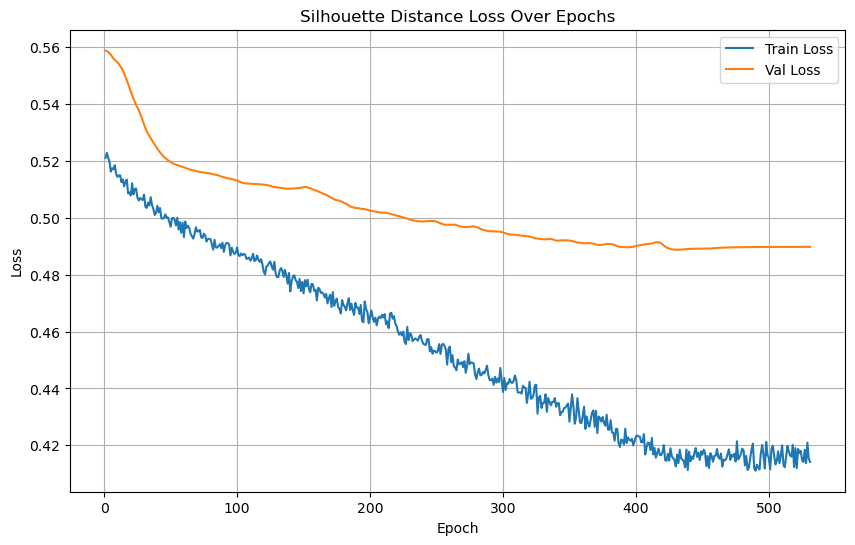

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/77], Loss: 0.4326
Test Batch [20/77], Loss: 0.0643
Test Batch [30/77], Loss: 0.1706
Test Batch [40/77], Loss: 0.5000
Test Batch [50/77], Loss: 0.1751
Test Batch [60/77], Loss: 0.3529


Test Batch [70/77], Loss: 0.5000

Test Loss: 0.3324


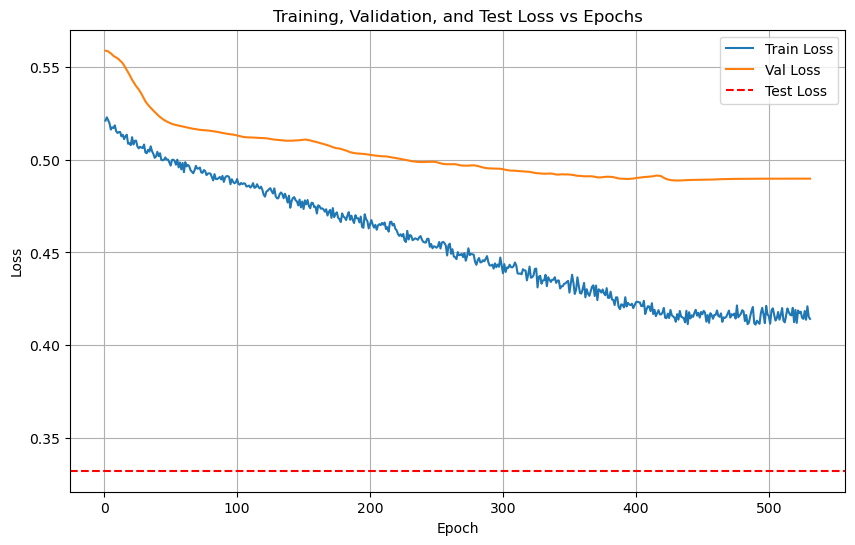

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/77 for test dataset.


  Processed batch 20/77 for test dataset.
  Processed batch 30/77 for test dataset.


  Processed batch 40/77 for test dataset.
  Processed batch 50/77 for test dataset.


  Processed batch 60/77 for test dataset.


  Processed batch 70/77 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 52.31%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.50      0.20      0.29         5
           2       0.40      0.40      0.40         5
           3       0.20      0.20      0.20         5
           4       0.00      0.00      0.00         5
           5       0.60      0.60      0.60         5
           6       0.57      0.80      0.67         5
           7       0.17      0.20      0.18         5
           8       0.56      1.00      0.71         5
           9       0.00      0.00      0.00         5
          10       0.80      0.80      0.80         5
          11       0.80      0.80      0.80         5
          12       0.80      0.80      0.80         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5510  |  Val Loss: 2.5205
Validation loss improved from inf to 2.5205.
[Epoch 2/1000] Train Loss: 2.5363  |  Val Loss: 2.5148
Validation loss improved from 2.5205 to 2.5148.
[Epoch 3/1000] Train Loss: 2.5244  |  Val Loss: 2.5097
Validation loss improved from 2.5148 to 2.5097.
[Epoch 4/1000] Train Loss: 2.5152  |  Val Loss: 2.5050
Validation loss improved from 2.5097 to 2.5050.
[Epoch 5/1000] Train Loss: 2.5055  |  Val Loss: 2.5005
Validation loss improved from 2.5050 to 2.5005.
[Epoch 6/1000] Train Loss: 2.4950  |  Val Loss: 2.4965
Validation loss improved from 2.5005 to 2.4965.
[Epoch 7/1000] Train Loss: 2.4861  |  Val Loss: 2.4926
Validation loss improved from 2.4965 to 2.4926.
[Epoch 8/1000] Train Loss: 2.4764  |  Val Loss: 2.4881
Validation loss improved from 2.4926 to 2.4881.
[Epoch 9/1000] Train Loss: 2.4677  |  Val Loss: 2.4843
Validation loss improved from 2.4881 to 2.4843.
[Epoch 10/1000] Train Loss: 2.4585  |  Val Loss: 2.4810
Validation loss impr

[Epoch 11/1000] Train Loss: 2.4504  |  Val Loss: 2.4779
Validation loss improved from 2.4810 to 2.4779.
[Epoch 12/1000] Train Loss: 2.4432  |  Val Loss: 2.4747
Validation loss improved from 2.4779 to 2.4747.
[Epoch 13/1000] Train Loss: 2.4349  |  Val Loss: 2.4718
Validation loss improved from 2.4747 to 2.4718.
[Epoch 14/1000] Train Loss: 2.4274  |  Val Loss: 2.4690
Validation loss improved from 2.4718 to 2.4690.
[Epoch 15/1000] Train Loss: 2.4212  |  Val Loss: 2.4664
Validation loss improved from 2.4690 to 2.4664.


[Epoch 16/1000] Train Loss: 2.4141  |  Val Loss: 2.4635
Validation loss improved from 2.4664 to 2.4635.
[Epoch 17/1000] Train Loss: 2.4083  |  Val Loss: 2.4597
Validation loss improved from 2.4635 to 2.4597.
[Epoch 18/1000] Train Loss: 2.4019  |  Val Loss: 2.4563
Validation loss improved from 2.4597 to 2.4563.
[Epoch 19/1000] Train Loss: 2.3956  |  Val Loss: 2.4538
Validation loss improved from 2.4563 to 2.4538.
[Epoch 20/1000] Train Loss: 2.3892  |  Val Loss: 2.4518
Validation loss improved from 2.4538 to 2.4518.
[Epoch 21/1000] Train Loss: 2.3830  |  Val Loss: 2.4496
Validation loss improved from 2.4518 to 2.4496.


[Epoch 22/1000] Train Loss: 2.3768  |  Val Loss: 2.4471
Validation loss improved from 2.4496 to 2.4471.
[Epoch 23/1000] Train Loss: 2.3711  |  Val Loss: 2.4447
Validation loss improved from 2.4471 to 2.4447.
[Epoch 24/1000] Train Loss: 2.3655  |  Val Loss: 2.4422
Validation loss improved from 2.4447 to 2.4422.
[Epoch 25/1000] Train Loss: 2.3607  |  Val Loss: 2.4391
Validation loss improved from 2.4422 to 2.4391.
[Epoch 26/1000] Train Loss: 2.3558  |  Val Loss: 2.4360
Validation loss improved from 2.4391 to 2.4360.
[Epoch 27/1000] Train Loss: 2.3512  |  Val Loss: 2.4334
Validation loss improved from 2.4360 to 2.4334.
[Epoch 28/1000] Train Loss: 2.3468  |  Val Loss: 2.4308
Validation loss improved from 2.4334 to 2.4308.
[Epoch 29/1000] Train Loss: 2.3428  |  Val Loss: 2.4283
Validation loss improved from 2.4308 to 2.4283.
[Epoch 30/1000] Train Loss: 2.3387  |  Val Loss: 2.4260
Validation loss improved from 2.4283 to 2.4260.
[Epoch 31/1000] Train Loss: 2.3344  |  Val Loss: 2.4237
Validati

[Epoch 32/1000] Train Loss: 2.3305  |  Val Loss: 2.4213
Validation loss improved from 2.4237 to 2.4213.
[Epoch 33/1000] Train Loss: 2.3261  |  Val Loss: 2.4187
Validation loss improved from 2.4213 to 2.4187.
[Epoch 34/1000] Train Loss: 2.3214  |  Val Loss: 2.4162
Validation loss improved from 2.4187 to 2.4162.
[Epoch 35/1000] Train Loss: 2.3170  |  Val Loss: 2.4139
Validation loss improved from 2.4162 to 2.4139.


[Epoch 36/1000] Train Loss: 2.3128  |  Val Loss: 2.4118
Validation loss improved from 2.4139 to 2.4118.
[Epoch 37/1000] Train Loss: 2.3086  |  Val Loss: 2.4096
Validation loss improved from 2.4118 to 2.4096.
[Epoch 38/1000] Train Loss: 2.3043  |  Val Loss: 2.4079
Validation loss improved from 2.4096 to 2.4079.
[Epoch 39/1000] Train Loss: 2.3001  |  Val Loss: 2.4062
Validation loss improved from 2.4079 to 2.4062.
[Epoch 40/1000] Train Loss: 2.2961  |  Val Loss: 2.4049
Validation loss improved from 2.4062 to 2.4049.


[Epoch 41/1000] Train Loss: 2.2919  |  Val Loss: 2.4035
Validation loss improved from 2.4049 to 2.4035.
[Epoch 42/1000] Train Loss: 2.2878  |  Val Loss: 2.4019
Validation loss improved from 2.4035 to 2.4019.
[Epoch 43/1000] Train Loss: 2.2840  |  Val Loss: 2.4001
Validation loss improved from 2.4019 to 2.4001.
[Epoch 44/1000] Train Loss: 2.2798  |  Val Loss: 2.3984
Validation loss improved from 2.4001 to 2.3984.
[Epoch 45/1000] Train Loss: 2.2760  |  Val Loss: 2.3964
Validation loss improved from 2.3984 to 2.3964.
[Epoch 46/1000] Train Loss: 2.2721  |  Val Loss: 2.3948
Validation loss improved from 2.3964 to 2.3948.
[Epoch 47/1000] Train Loss: 2.2680  |  Val Loss: 2.3928
Validation loss improved from 2.3948 to 2.3928.
[Epoch 48/1000] Train Loss: 2.2643  |  Val Loss: 2.3903
Validation loss improved from 2.3928 to 2.3903.
[Epoch 49/1000] Train Loss: 2.2604  |  Val Loss: 2.3879
Validation loss improved from 2.3903 to 2.3879.
[Epoch 50/1000] Train Loss: 2.2565  |  Val Loss: 2.3861
Validati

[Epoch 54/1000] Train Loss: 2.2403  |  Val Loss: 2.3748
Validation loss improved from 2.3780 to 2.3748.
[Epoch 55/1000] Train Loss: 2.2359  |  Val Loss: 2.3725
Validation loss improved from 2.3748 to 2.3725.
[Epoch 56/1000] Train Loss: 2.2314  |  Val Loss: 2.3706
Validation loss improved from 2.3725 to 2.3706.
[Epoch 57/1000] Train Loss: 2.2272  |  Val Loss: 2.3686
Validation loss improved from 2.3706 to 2.3686.
[Epoch 58/1000] Train Loss: 2.2228  |  Val Loss: 2.3666
Validation loss improved from 2.3686 to 2.3666.


[Epoch 59/1000] Train Loss: 2.2185  |  Val Loss: 2.3651
Validation loss improved from 2.3666 to 2.3651.
[Epoch 60/1000] Train Loss: 2.2142  |  Val Loss: 2.3629
Validation loss improved from 2.3651 to 2.3629.
[Epoch 61/1000] Train Loss: 2.2096  |  Val Loss: 2.3588
Validation loss improved from 2.3629 to 2.3588.
[Epoch 62/1000] Train Loss: 2.2051  |  Val Loss: 2.3553
Validation loss improved from 2.3588 to 2.3553.


[Epoch 63/1000] Train Loss: 2.2004  |  Val Loss: 2.3526
Validation loss improved from 2.3553 to 2.3526.
[Epoch 64/1000] Train Loss: 2.1954  |  Val Loss: 2.3506
Validation loss improved from 2.3526 to 2.3506.
[Epoch 65/1000] Train Loss: 2.1910  |  Val Loss: 2.3494
Validation loss improved from 2.3506 to 2.3494.
[Epoch 66/1000] Train Loss: 2.1863  |  Val Loss: 2.3487
Validation loss improved from 2.3494 to 2.3487.
[Epoch 67/1000] Train Loss: 2.1818  |  Val Loss: 2.3478
Validation loss improved from 2.3487 to 2.3478.
[Epoch 68/1000] Train Loss: 2.1769  |  Val Loss: 2.3471
Validation loss improved from 2.3478 to 2.3471.
[Epoch 69/1000] Train Loss: 2.1719  |  Val Loss: 2.3458
Validation loss improved from 2.3471 to 2.3458.
[Epoch 70/1000] Train Loss: 2.1672  |  Val Loss: 2.3448
Validation loss improved from 2.3458 to 2.3448.
[Epoch 71/1000] Train Loss: 2.1624  |  Val Loss: 2.3436
Validation loss improved from 2.3448 to 2.3436.
[Epoch 72/1000] Train Loss: 2.1577  |  Val Loss: 2.3424
Validati

[Epoch 74/1000] Train Loss: 2.1484  |  Val Loss: 2.3389
Validation loss improved from 2.3406 to 2.3389.
[Epoch 75/1000] Train Loss: 2.1437  |  Val Loss: 2.3379
Validation loss improved from 2.3389 to 2.3379.
[Epoch 76/1000] Train Loss: 2.1392  |  Val Loss: 2.3368
Validation loss improved from 2.3379 to 2.3368.


[Epoch 77/1000] Train Loss: 2.1342  |  Val Loss: 2.3349
Validation loss improved from 2.3368 to 2.3349.
[Epoch 78/1000] Train Loss: 2.1290  |  Val Loss: 2.3331
Validation loss improved from 2.3349 to 2.3331.
[Epoch 79/1000] Train Loss: 2.1239  |  Val Loss: 2.3309
Validation loss improved from 2.3331 to 2.3309.
[Epoch 80/1000] Train Loss: 2.1184  |  Val Loss: 2.3287
Validation loss improved from 2.3309 to 2.3287.
[Epoch 81/1000] Train Loss: 2.1127  |  Val Loss: 2.3270
Validation loss improved from 2.3287 to 2.3270.


[Epoch 82/1000] Train Loss: 2.1070  |  Val Loss: 2.3253
Validation loss improved from 2.3270 to 2.3253.
[Epoch 83/1000] Train Loss: 2.1012  |  Val Loss: 2.3236
Validation loss improved from 2.3253 to 2.3236.
[Epoch 84/1000] Train Loss: 2.0956  |  Val Loss: 2.3223
Validation loss improved from 2.3236 to 2.3223.
[Epoch 85/1000] Train Loss: 2.0900  |  Val Loss: 2.3214
Validation loss improved from 2.3223 to 2.3214.
[Epoch 86/1000] Train Loss: 2.0843  |  Val Loss: 2.3201
Validation loss improved from 2.3214 to 2.3201.
[Epoch 87/1000] Train Loss: 2.0786  |  Val Loss: 2.3193
Validation loss improved from 2.3201 to 2.3193.
[Epoch 88/1000] Train Loss: 2.0727  |  Val Loss: 2.3189
Validation loss improved from 2.3193 to 2.3189.
[Epoch 89/1000] Train Loss: 2.0666  |  Val Loss: 2.3183
Validation loss improved from 2.3189 to 2.3183.
[Epoch 90/1000] Train Loss: 2.0605  |  Val Loss: 2.3174
Validation loss improved from 2.3183 to 2.3174.
[Epoch 91/1000] Train Loss: 2.0546  |  Val Loss: 2.3170
Validati

[Epoch 93/1000] Train Loss: 2.0428  |  Val Loss: 2.3163
Validation loss improved from 2.3169 to 2.3163.
[Epoch 94/1000] Train Loss: 2.0371  |  Val Loss: 2.3159
Validation loss improved from 2.3163 to 2.3159.
[Epoch 95/1000] Train Loss: 2.0314  |  Val Loss: 2.3162
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 96/1000] Train Loss: 2.0252  |  Val Loss: 2.3168
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 2.0191  |  Val Loss: 2.3173
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 98/1000] Train Loss: 2.0124  |  Val Loss: 2.3173
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 99/1000] Train Loss: 2.0063  |  Val Loss: 2.3172
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 100/1000] Train Loss: 1.9998  |  Val Loss: 2.3173
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 101/1000] Train Loss: 1.9935  |  Val Loss: 2.3180
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 102/1000] Train Loss: 1.9866  |  Val Loss: 2.3177
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 103/1000] Train Loss: 1.9794  |  Val Loss: 2.3178
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 104/1000] Train Loss: 1.9718  |  Val Loss: 2.3194
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 105/1000] Train Loss: 1.9643  |  Val Loss: 2.3209
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 106/1000] Train Loss: 1.9569  |  Val Loss: 2.3221
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 107/1000] Train Loss: 1.9495  |  Val Loss: 2.3230
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 108/1000] Train Loss: 1.9419  |  Val Loss: 2.3239
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 109/1000] Train Loss: 1.9347  |  Val Loss: 2.3253
!! Validation loss did NOT improve !! Patience: 15

[Epoch 112/1000] Train Loss: 1.9142  |  Val Loss: 2.3293
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 113/1000] Train Loss: 1.9078  |  Val Loss: 2.3306
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 114/1000] Train Loss: 1.9010  |  Val Loss: 2.3322
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 115/1000] Train Loss: 1.8939  |  Val Loss: 2.3337
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 116/1000] Train Loss: 1.8869  |  Val Loss: 2.3357
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 117/1000] Train Loss: 1.8803  |  Val Loss: 2.3378
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 118/1000] Train Loss: 1.8737  |  Val Loss: 2.3405
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 119/1000] Train Loss: 1.8670  |  Val Loss: 2.3437
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 120/1000] Train Loss: 1.8605  |  Val Loss: 2.3480
!! Validation loss did NOT improve !! Patience:

[Epoch 121/1000] Train Loss: 1.8546  |  Val Loss: 2.3526
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 122/1000] Train Loss: 1.8488  |  Val Loss: 2.3574
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 123/1000] Train Loss: 1.8430  |  Val Loss: 2.3620
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 124/1000] Train Loss: 1.8368  |  Val Loss: 2.3658
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 125/1000] Train Loss: 1.8305  |  Val Loss: 2.3701
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 126/1000] Train Loss: 1.8236  |  Val Loss: 2.3748
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 127/1000] Train Loss: 1.8169  |  Val Loss: 2.3800
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 128/1000] Train Loss: 1.8103  |  Val Loss: 2.3858
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 129/1000] Train Loss: 1.8034  |  Val Loss: 2.3919
!! Validation loss did NOT improve !! Patience:

[Epoch 133/1000] Train Loss: 1.7782  |  Val Loss: 2.4082
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 134/1000] Train Loss: 1.7719  |  Val Loss: 2.4137
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 135/1000] Train Loss: 1.7657  |  Val Loss: 2.4193
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 136/1000] Train Loss: 1.7593  |  Val Loss: 2.4241
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 137/1000] Train Loss: 1.7527  |  Val Loss: 2.4294
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 138/1000] Train Loss: 1.7466  |  Val Loss: 2.4355
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 139/1000] Train Loss: 1.7406  |  Val Loss: 2.4417
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 140/1000] Train Loss: 1.7346  |  Val Loss: 2.4465
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 141/1000] Train Loss: 1.7284  |  Val Loss: 2.4506
!! Validation loss did NOT improve !! Patience:

[Epoch 143/1000] Train Loss: 1.7160  |  Val Loss: 2.4584
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 144/1000] Train Loss: 1.7096  |  Val Loss: 2.4616
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 145/1000] Train Loss: 1.7034  |  Val Loss: 2.4650
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 146/1000] Train Loss: 1.6970  |  Val Loss: 2.4693
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 147/1000] Train Loss: 1.6910  |  Val Loss: 2.4738
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 148/1000] Train Loss: 1.6850  |  Val Loss: 2.4797
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 149/1000] Train Loss: 1.6794  |  Val Loss: 2.4860
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 150/1000] Train Loss: 1.6736  |  Val Loss: 2.4905
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 151/1000] Train Loss: 1.6677  |  Val Loss: 2.4932
!! Validation loss did NOT improve !! Patience:

[Epoch 155/1000] Train Loss: 1.6440  |  Val Loss: 2.5029
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 156/1000] Train Loss: 1.6382  |  Val Loss: 2.5051
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 157/1000] Train Loss: 1.6324  |  Val Loss: 2.5085
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 158/1000] Train Loss: 1.6267  |  Val Loss: 2.5112
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 159/1000] Train Loss: 1.6210  |  Val Loss: 2.5147
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 160/1000] Train Loss: 1.6153  |  Val Loss: 2.5206
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 161/1000] Train Loss: 1.6092  |  Val Loss: 2.5265
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 162/1000] Train Loss: 1.6029  |  Val Loss: 2.5313
!! Validation loss did NOT improve !! Patience: 68/100


[Epoch 163/1000] Train Loss: 1.5964  |  Val Loss: 2.5375
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 164/1000] Train Loss: 1.5902  |  Val Loss: 2.5424
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 165/1000] Train Loss: 1.5837  |  Val Loss: 2.5452
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 166/1000] Train Loss: 1.5774  |  Val Loss: 2.5481
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 167/1000] Train Loss: 1.5715  |  Val Loss: 2.5492
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 168/1000] Train Loss: 1.5655  |  Val Loss: 2.5520
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 169/1000] Train Loss: 1.5593  |  Val Loss: 2.5572
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 170/1000] Train Loss: 1.5535  |  Val Loss: 2.5628
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 171/1000] Train Loss: 1.5477  |  Val Loss: 2.5668
!! Validation loss did NOT improve !! Patience:

[Epoch 174/1000] Train Loss: 1.5309  |  Val Loss: 2.5866
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 175/1000] Train Loss: 1.5255  |  Val Loss: 2.5925
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 176/1000] Train Loss: 1.5201  |  Val Loss: 2.5979
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 177/1000] Train Loss: 1.5143  |  Val Loss: 2.6027
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 178/1000] Train Loss: 1.5087  |  Val Loss: 2.6075
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 179/1000] Train Loss: 1.5029  |  Val Loss: 2.6137
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 180/1000] Train Loss: 1.4971  |  Val Loss: 2.6204
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 181/1000] Train Loss: 1.4912  |  Val Loss: 2.6268
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 182/1000] Train Loss: 1.4855  |  Val Loss: 2.6340
!! Validation loss did NOT improve !! Patience:

[Epoch 183/1000] Train Loss: 1.4791  |  Val Loss: 2.6414
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 184/1000] Train Loss: 1.4728  |  Val Loss: 2.6467
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 185/1000] Train Loss: 1.4667  |  Val Loss: 2.6511
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 186/1000] Train Loss: 1.4604  |  Val Loss: 2.6566
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 187/1000] Train Loss: 1.4548  |  Val Loss: 2.6615
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 188/1000] Train Loss: 1.4492  |  Val Loss: 2.6644
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 189/1000] Train Loss: 1.4434  |  Val Loss: 2.6696
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 190/1000] Train Loss: 1.4382  |  Val Loss: 2.6726
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 191/1000] Train Loss: 1.4325  |  Val Loss: 2.6761
!! Validation loss did NOT improve !! Patience:

[Epoch 194/1000] Train Loss: 1.4164  |  Val Loss: 2.6909
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 194 !!
No improvement for 100 epochs.


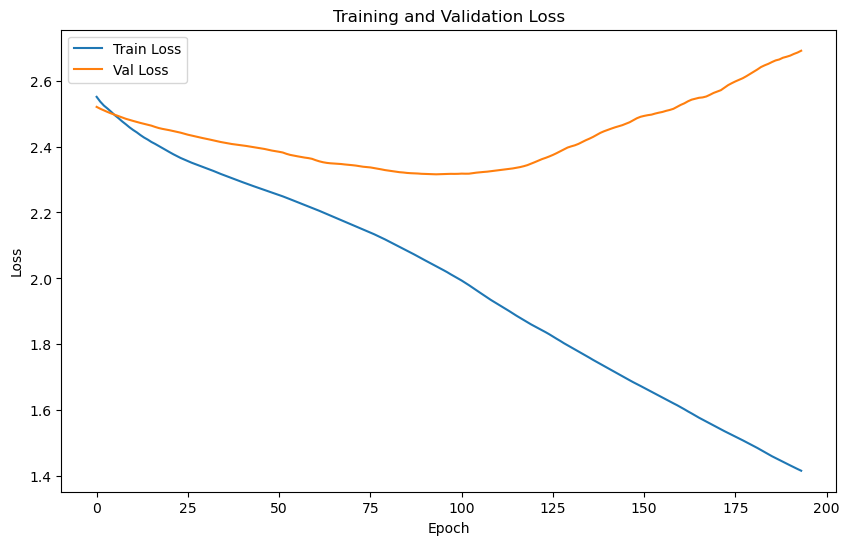

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.6526 | Test Accuracy: 55.67%


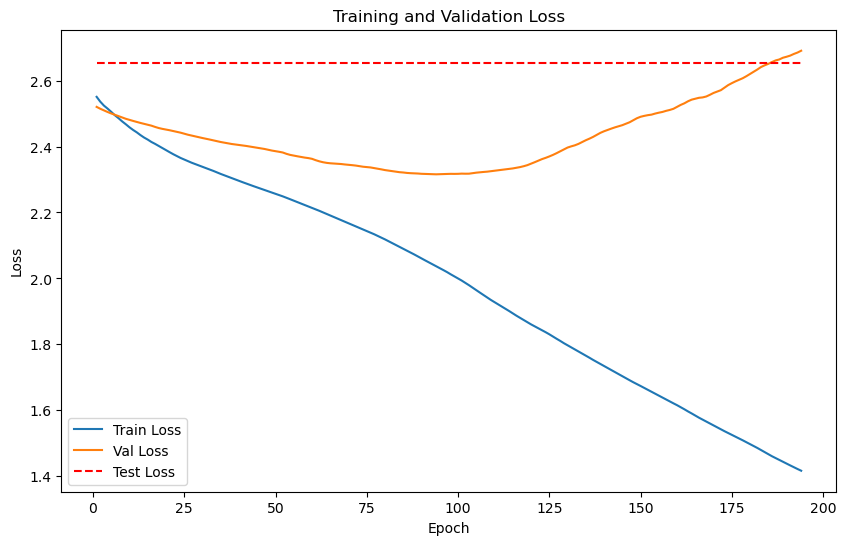

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


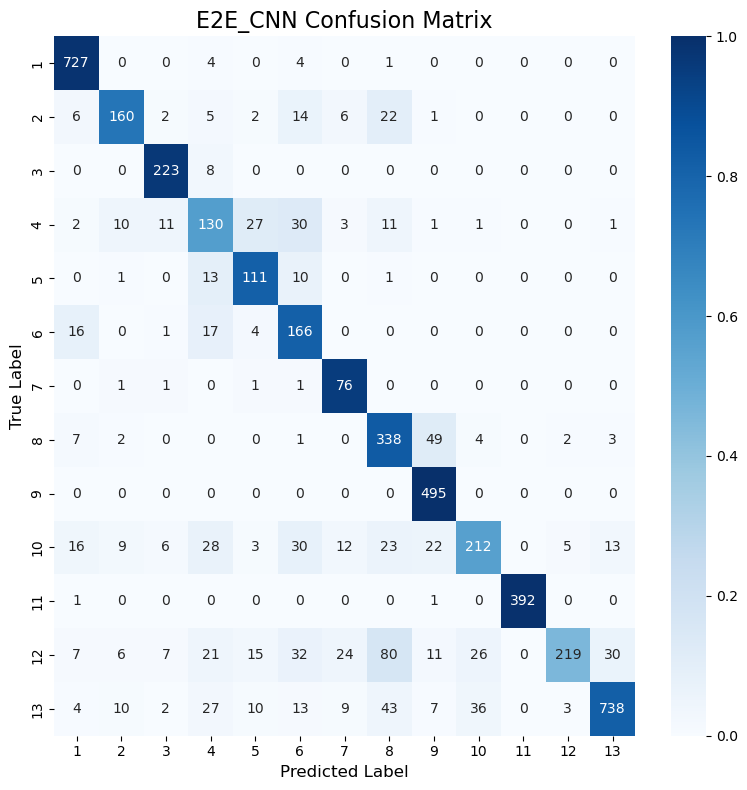

Classification Accuracy: 81.60%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


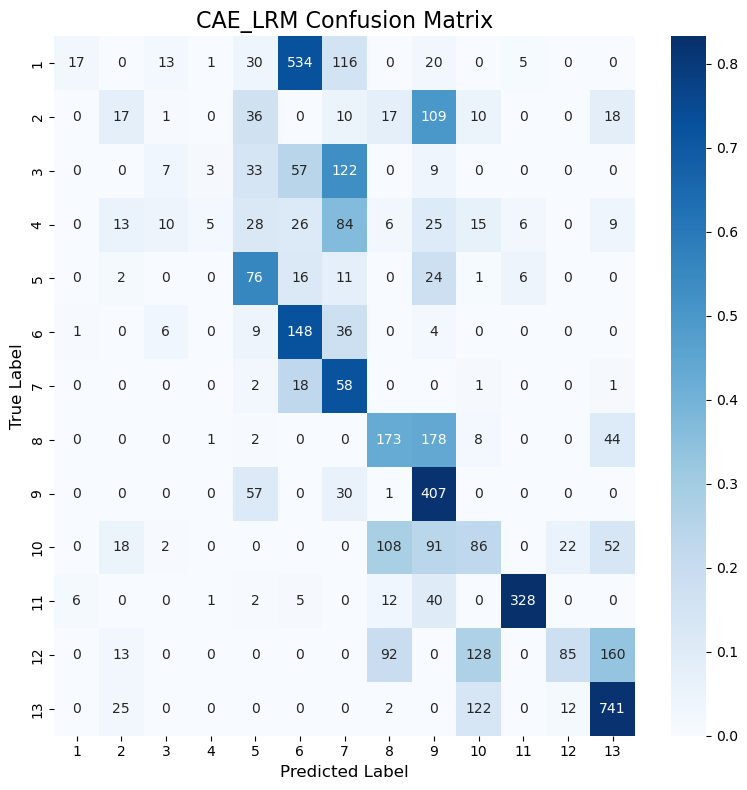

Classification Accuracy: 43.96%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


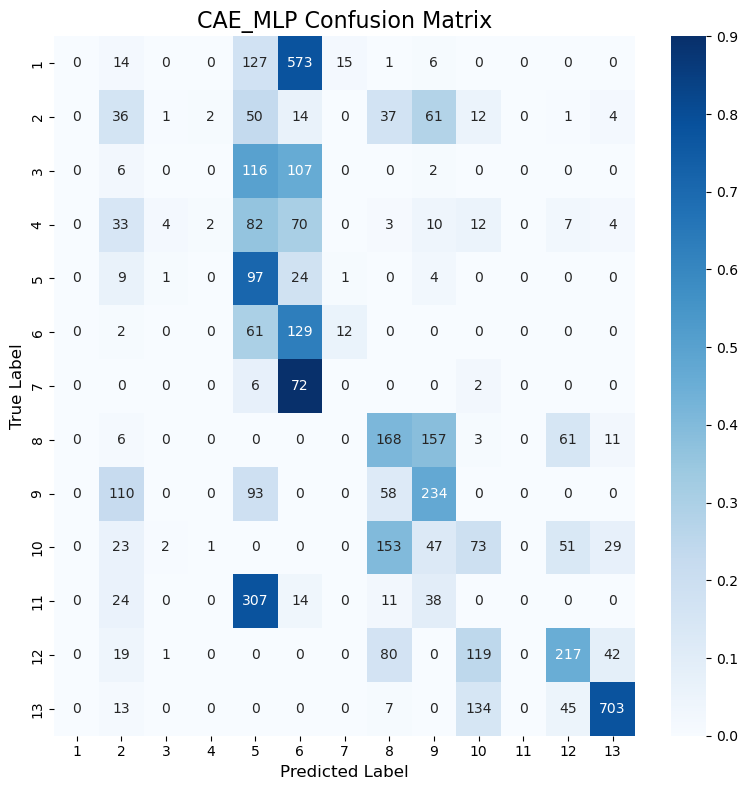

Classification Accuracy: 33.95%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


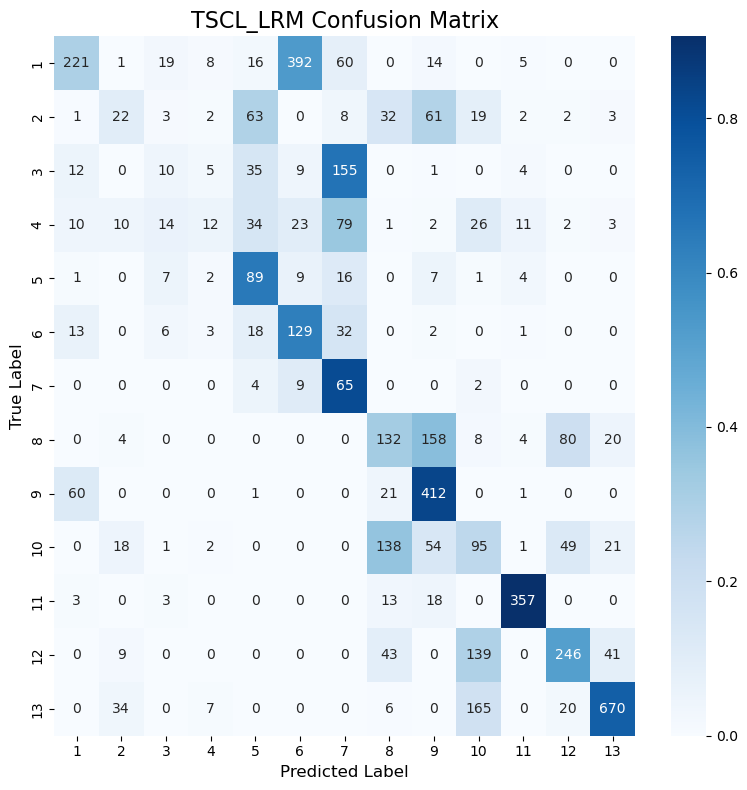

Classification Accuracy: 50.35%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


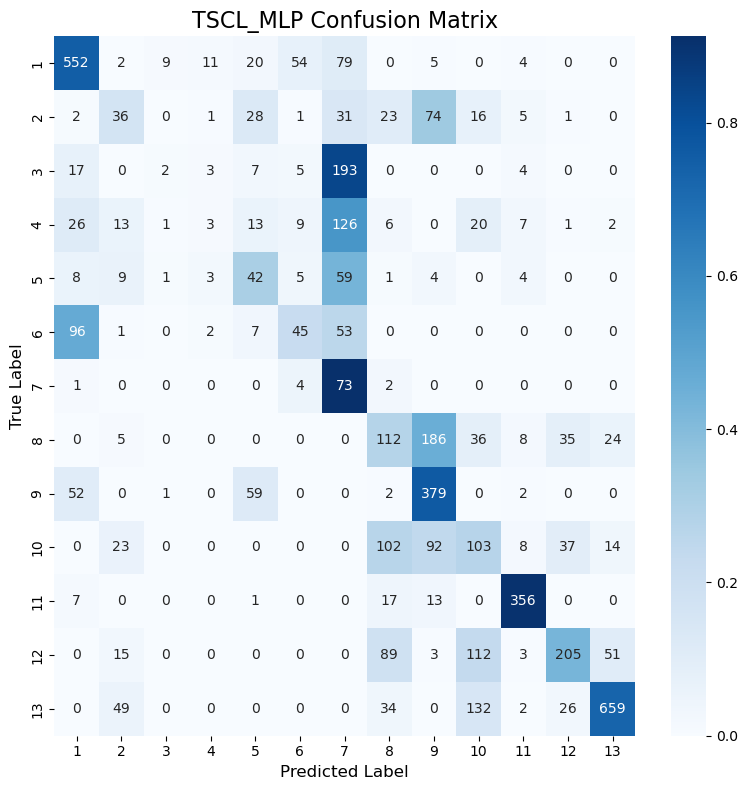

Classification Accuracy: 52.54%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


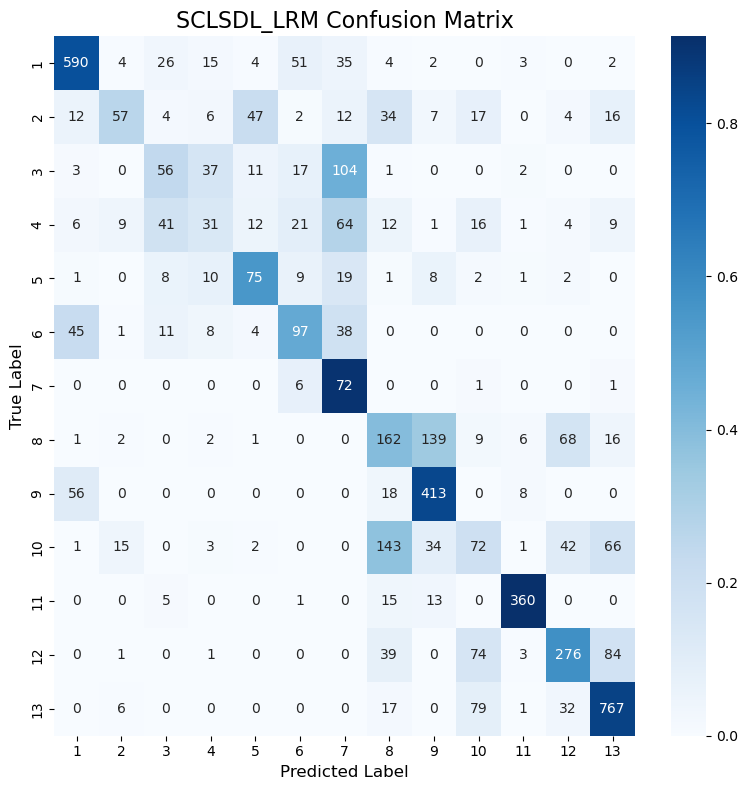

Classification Accuracy: 61.97%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


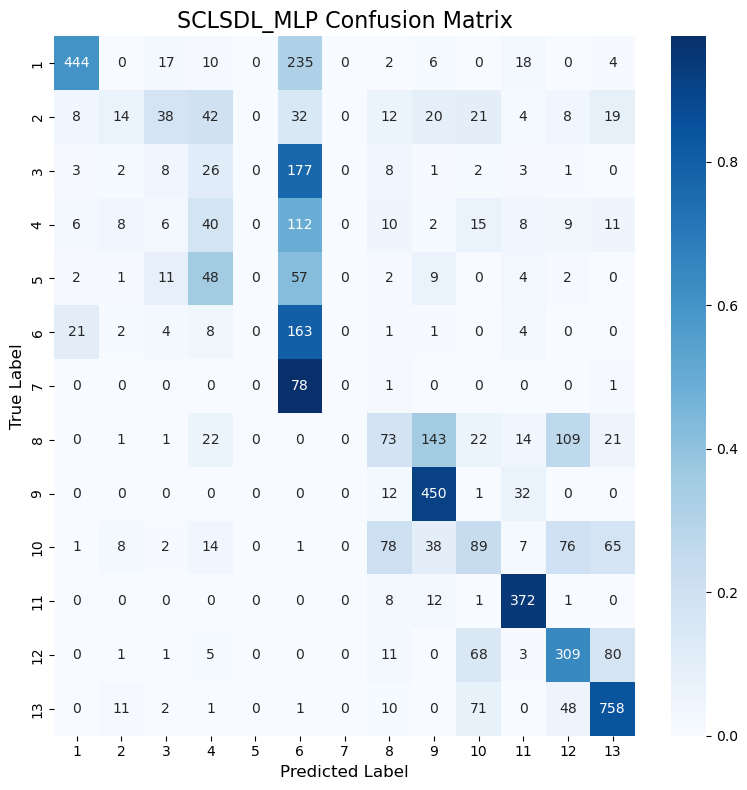

Classification Accuracy: 55.67%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          81.60
1    LRM (CAE)          43.96
2    MLP (CAE)          33.95
3     TSCL LRM          50.35
4     TSCL MLP          52.54
5  SCL_SDL LRM          61.97
6  SCL_SDL MLP          55.67

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          81.60
5  SCL_SDL LRM          61.97
6  SCL_SDL MLP          55.67
4     TSCL MLP          52.54
3     TSCL LRM          50.35
1    LRM (CAE)          43.96
2    MLP (CAE)          33.95
